In [1]:
# Load
from tqdm import tqdm,tnrange
from scipy.linalg import expm
from ortools.linear_solver import pywraplp
from ortools.sat.python import cp_model

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# import elitism

import os , time , copy
import pickle , json

# set the random seed:
RANDOM_SEED = 10
random.seed(RANDOM_SEED)

Criteria = "MC"
num_catchments = 10
num_years = 10
Ucost = 3
a = 0.1
budgetb = 100000
Tol=0.05



# Flushing Transition Matrix
FlushTran = np.array([[1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0]])


dfCL = pd.read_pickle('Sewer_data.pkl')

dfCL = dfCL.iloc[0:num_catchments]
catchments = dfCL.index
dfCL_org = dfCL.copy()
S = np.array([1,2,3,4,5])

dfCL = dfCL_org.copy()


In [2]:
dfCL

,Len,Tran,Init,Next,Mean,MeanLen,PPA,PPALen,TPR
Catchment_Group,,,,,,,,,
PS4NS,34643.29,"[[0.6167815793810465, 0.35663497525045296, 0.0...","[0.287079475602867, 0.32580523109723375, 0.201...",,,,,,
PS4SN_5,30783.54,"[[0.8450577715813271, 0.1402653713597138, 0.01...","[0.8074170734583418, 0.10576973365987109, 0.04...",,,,,,
YRJD,12934.21,"[[0.6953929978776733, 0.2613830033096466, 0.03...","[0.790189250497519, 0.09236302571945035, 0.030...",,,,,,
YRHS_26,11667.71,"[[0.7161603246231628, 0.24113094843613966, 0.0...","[0.8426259069879856, 0.07790883238742037, 0.02...",,,,,,
24,11423.13,"[[0.8041419644973112, 0.1784927901776691, 0.01...","[0.8139816442443045, 0.11904453424283377, 0.02...",,,,,,
23,11393.38,"[[0.8107375947451438, 0.17163507060289937, 0.0...","[0.7351121487534396, 0.13317329845918888, 0.06...",,,,,,
7,8479.24,"[[0.8601307080797921, 0.128670524050624, 0.010...","[0.7997789893657796, 0.1187277618368649, 0.040...",,,,,,
17,7359.18,"[[0.8821924297293807, 0.10937657417810501, 0.0...","[1.0, 0.0, 0.0, 0.0, 0.0]",,,,,,
6,6411.50,"[[0.8486754432344751, 0.1393647554662364, 0.01...","[0.8329873399163066, 0.07579517397671989, 0.04...",,,,,,


In [20]:



def getCatchmentPlan(plan):
    """
    Converts the entire network plan into a dictionary with a separate plan for each catchment
    :param schedule: a list of binary values describing the given schedule
    :return: a dictionary with each catchment as a key and the corresponding plan as the value
    """
    
    catchmentplanDict = {}
    shiftIndex = 0

    for catchment in catchments:
        catchmentplanDict[catchment] = plan[shiftIndex:shiftIndex + num_years]
        shiftIndex += num_years

    return catchmentplanDict

def condition(CatchmentPlan,catchment):
    """
    Calculate the states of each catchment throughout the period according to the plan
    :param CatchmentPlan: a list of binary values describing the catchment plan
    :return: a list of numpy arrays presenting the states in each year
    """
    
    state_list = []
    state = dfCL.Init[catchment]
    for i in range(len(CatchmentPlan)):
        new_state = (1-CatchmentPlan[i])*np.dot(state,dfCL.Tran[catchment])+ CatchmentPlan[i]*np.dot(state,FlushTran)
        state_list.append(new_state)
        state = new_state.copy()
    return state_list

# def nextcond():
#     dfCL.Next = dfCL.apply(lambda x: np.dot(x.Init, x.Tran), axis=1)
#     dfCL.Mean = dfCL.apply(lambda x: (np.dot(S, x.Next.T)), axis=1)
#     dfCL.MeanLen = dfCL.Mean*dfCL.Len
#     dfCL.PPA = dfCL.apply(lambda x: x.Next[0,3]+x.Next[0,4], axis=1)
#     dfCL.PPALen = dfCL.PPA*dfCL.Len
    
def nextcond(dfCL):
    dfCL.Next = dfCL.apply(lambda x: np.dot(x.Init, x.Tran), axis=1)
    dfCL.Mean = dfCL.apply(lambda x: sum((np.dot(S, x.Next.T))), axis=1)
    dfCL.MeanLen = dfCL.Mean*dfCL.Len
    dfCL.PPA = dfCL.apply(lambda x: x.Next[3]+x.Next[4], axis=1)
    dfCL.PPALen = dfCL.PPA*dfCL.Len
    return dfCL
    

def getObjCatchment(CatchmentStates):
    MeanC_Catchment = []
    PPA_Catchment = []
    for i in range(len(CatchmentStates)):
        MeanC_Catchment.append(np.dot(S,CatchmentStates[i].T))
        PPA_Catchment.append(CatchmentStates[i][3]+CatchmentStates[i][4])

    return sum(MeanC_Catchment)/num_years , sum(PPA_Catchment)/num_years , MeanC_Catchment , PPA_Catchment


def getObjCatchment2(CatchmentPlan,catchment):
    dfC = dfT.loc[dfT['Catchment_Group'] == catchment].copy()
    condition_list=[]
    for i in range(len(CatchmentPlan)):
        if CatchmentPlan[i]==1:
            dfC.Next = dfC.apply(lambda x: np.dot(x.Init, FlushTran), axis=1)
        else:
            dfC.Next = dfC.apply(lambda x: np.dot(x.Init, x.Tran), axis=1)
        dfC.Mean = dfC.apply(lambda x: sum(sum((np.dot(S, x.Next.T)))), axis=1)
        obj = sum(dfC.Len*dfC.Mean)/sum(dfC.Len)
        condition_list.append(obj)
        dfC.Init = dfC.Next.copy()
    return sum(condition_list)/len(condition_list)


def BudgetConstraint(catchmentplanDict):
    num_hard_violation = 0
    percent = 0
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        if cost > budgetb*(1+Tol):
            num_hard_violation +=1
            percent += abs(cost-budgetb*(1+Tol))/(budgetb*(1+Tol))
        if cost < budgetb*(1-Tol):
            num_hard_violation +=1
            percent += abs(cost-budgetb*(1-Tol))/(budgetb*(1-Tol))
    
    return num_hard_violation, percent

def BudgetConstraintTotal(catchmentplanDict):
    num_budget_violation = 0
    total_budget_percent = 0
    costT = 0
    budgetTotal = budgetb*num_years
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        costT += cost
    if costT > budgetTotal:
        num_budget_violation +=1
        total_budget_percent += (costT-budgetTotal)/budgetTotal

    
    return num_budget_violation, total_budget_percent

def OneFlushConstraint(catchmentplanDict):
    num_soft_violation = 0
    soft = 0
    for C in catchments:
        if sum(catchmentplanDict[C]) == 0:
            num_soft_violation +=1
            soft += dfCL.Len[C]
    soft_percent = soft/dfCL.Len.sum()       
    return num_soft_violation, soft_percent  



def getObj(plan):
    """
    Calculates the total cost of the various violations in the given network plan
    ...
    :param plan: a list of binary values describing the given network plan
    :return: the calculated cost
    """
    # convert entire schedule into a dictionary with a separate schedule for each catchment:
    catchmentplanDict = getCatchmentPlan(plan)
    MeanC_Catchment_List = []
    PPA_Catchment_List = []
    for C in catchments:
        CatchmentStates = condition(catchmentplanDict[C],C)
        MeanC_Catchment , PPA_Catchment , _ , _  = getObjCatchment(CatchmentStates)
        MeanC_Catchment_List.append(MeanC_Catchment) 
        PPA_Catchment_List.append(PPA_Catchment)
    #print(Obj_Catchment_List)
    if Criteria == "PPA":
        Obj_Network = (sum(np.array(dfCL.Len)*np.array(PPA_Catchment_List)))/sum(dfCL.Len)
    else:
        Obj_Network = (sum(np.array(dfCL.Len)*np.array(MeanC_Catchment_List)))/sum(dfCL.Len)
    
    
    #add penalty for violating constraint
    num_hard_violation , percent_hard_violation = BudgetConstraint(catchmentplanDict)
    num_soft_violation , percent_soft_violation = OneFlushConstraint(catchmentplanDict)
    num_budget_violation, total_budget_percent = BudgetConstraintTotal(catchmentplanDict)
    
    #Obj_Network_WC = Obj_Network+num_hard_violation*HARD_CONSTRAINT_PENALTY+num_soft_violation*SOFT_CONSTRAINT_PENALTY
#     Obj_Network_WC = Obj_Network+percent_hard_violation*HARD_CONSTRAINT_PENALTY+percent_soft_violation*SOFT_CONSTRAINT_PENALTY+BUDGET_TOTAL_PENALTY*total_budget_percent
    
    return Obj_Network

def getPerformance(plan):
    """
    Calculates the total cost of the various violations in the given network plan
    ...
    :param plan: a list of binary values describing the given network plan
    :return: the calculated cost
    """
    # convert entire schedule into a dictionary with a separate schedule for each catchment:
    
    performance = pd.DataFrame(columns = [i for i in range(1,num_years+1)], index = catchments)
    
    catchmentplanDict = getCatchmentPlan(plan)
    for C in catchments:
        CatchmentStates = condition(catchmentplanDict[C],C)
        _, _, MeanC_Catchment , PPA_Catchment = getObjCatchment(CatchmentStates)
        if Criteria == "PPA":
            performance.loc[C] = [i*dfCL.Len[C]/dfCL.Len.sum() for i in PPA_Catchment]
        else:
            performance.loc[C] = [i*dfCL.Len[C]/dfCL.Len.sum() for i in MeanC_Catchment]
    return performance.sum().tolist()    


def printPlanInfo(plan):
    """
    Prints the plan and violations details
    :param schedule: a list of binary values describing the given plan
    """
    catchmentplanDict = getCatchmentPlan(plan)

    print("Plan for each Catchment:")
    for catchment in catchmentplanDict: 
        print(catchment, ":", catchmentplanDict[catchment])
    print()
    print("Yearly Budget violations = ", BudgetConstraint(catchmentplanDict))
    print()
    print("Total Budget violations = ", BudgetConstraintTotal(catchmentplanDict))
    print()
    print("Minimum flush violations = ", OneFlushConstraint(catchmentplanDict))
    print()
    
    required_budget = []
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        required_budget.append(cost)
    print("Required budget for this plan: ", [round(num, 1) for num in required_budget] )
    print()
    print("Total required budget: ", round(sum(required_budget), 1))
    print()
    Obj_Network = getObj(plan)
    print("Network objective without penalty: ", Obj_Network )
    print()
    print(pd.DataFrame(np.array(plan).reshape(num_catchments,num_years),index=catchments, columns=range(1,1+num_years)))
    
def printPlanInfo2(plan):
    """
    Prints the plan and violations details
    :param schedule: a list of binary values describing the given plan
    """
    catchmentplanDict = getCatchmentPlan(plan)

    required_budget = []
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        required_budget.append(cost)
        
    Obj_Network = getObj(plan)
    
    print(BudgetConstraint(catchmentplanDict),BudgetConstraintTotal(catchmentplanDict),OneFlushConstraint(catchmentplanDict),Obj_Network , round(sum(required_budget), 1))
    print(required_budget)


def planlist(plan):
    sol = []
    for c in catchments:
        for year in range(1,num_years+1):
            sol.append(plan[str(year)][c])
    return sol




Tplan = []
for i in range(2**num_years):
    strplan = (format(i, '0'+str(num_years)+'b'))
    plan = [int(j) for j in strplan]
    Tplan.append(plan)
    


# for C in tqdm(catchments):
#     TPR = []
#     for p in Tplan:
#         dfCL = dfCL_org.copy()
#         CatchmentStates = condition(p,C)
#         MeanC_Catchment , _ , _ , _  = getObjCatchment(CatchmentStates)
#         TPR.append(MeanC_Catchment)
#     dfCL_org.TPR[C] = np.array(TPR)

    
Cost = {}
for x in range(1, num_years+1):
    y = []
    for p in Tplan:
        y.append(p[x-1])
    Cost["{0}".format(x)] = y
    
    
def PlanInfo(plan):
    """
    Prints the plan and violations details
    :param schedule: a list of binary values describing the given plan
    """
    catchmentplanDict = getCatchmentPlan(plan)
    
    required_budget = []
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        required_budget.append(cost)
        
    _ , Obj_Network = getObj(plan)
    return Obj_Network , round(sum(required_budget), 3)


# Surpress warnings: 
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn



In [4]:
dfCL = dfCL_org.copy()
dfCL

,Len,Tran,Init,Next,Mean,MeanLen,PPA,PPALen,TPR
Catchment_Group,,,,,,,,,
PS4NS,34643.29,"[[0.6167815793810465, 0.35663497525045296, 0.0...","[0.287079475602867, 0.32580523109723375, 0.201...",,,,,,
PS4SN_5,30783.54,"[[0.8450577715813271, 0.1402653713597138, 0.01...","[0.8074170734583418, 0.10576973365987109, 0.04...",,,,,,
YRJD,12934.21,"[[0.6953929978776733, 0.2613830033096466, 0.03...","[0.790189250497519, 0.09236302571945035, 0.030...",,,,,,
YRHS_26,11667.71,"[[0.7161603246231628, 0.24113094843613966, 0.0...","[0.8426259069879856, 0.07790883238742037, 0.02...",,,,,,
24,11423.13,"[[0.8041419644973112, 0.1784927901776691, 0.01...","[0.8139816442443045, 0.11904453424283377, 0.02...",,,,,,
23,11393.38,"[[0.8107375947451438, 0.17163507060289937, 0.0...","[0.7351121487534396, 0.13317329845918888, 0.06...",,,,,,
7,8479.24,"[[0.8601307080797921, 0.128670524050624, 0.010...","[0.7997789893657796, 0.1187277618368649, 0.040...",,,,,,
17,7359.18,"[[0.8821924297293807, 0.10937657417810501, 0.0...","[1.0, 0.0, 0.0, 0.0, 0.0]",,,,,,
6,6411.50,"[[0.8486754432344751, 0.1393647554662364, 0.01...","[0.8329873399163066, 0.07579517397671989, 0.04...",,,,,,


In [5]:
import numpy as np
import random
import gym
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
import gym.spaces
import argparse
from torch.utils.tensorboard import SummaryWriter
import time

from gym import Env
from gym.spaces import Discrete, Box, Dict

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_size=256, init_w=3e-3, log_std_min=-20, log_std_max=0):
        """Initialize parameters and build model."""
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.init_w = init_w  # Store init_w as an instance variable

        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        self.mu = nn.Linear(hidden_size, action_size)
        self.log_std_linear = nn.Linear(hidden_size, action_size)

#         self.reset_parameters()

#     def reset_parameters(self):
#         self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
#         self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
#         self.mu.weight.data.uniform_(-self.init_w, self.init_w) 
#         self.log_std_linear.weight.data.uniform_(-self.init_w, self.init_w) 

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        # Small random init for mu, with bias = 0
        nn.init.normal_(self.mu.weight, mean=0.0, std=1e-2)
        nn.init.constant_(self.mu.bias, 0.0)
        nn.init.uniform_(self.log_std_linear.weight, -self.init_w, self.init_w)
        nn.init.uniform_(self.log_std_linear.bias, -self.init_w, self.init_w)        
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        
        dist = Normal(0, 1)
        e = dist.sample().to(device)
        action = torch.tanh(mu + e * std)
        log_prob = Normal(mu, std).log_prob(mu + e * std) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob
        
    
    def get_action(self, state, add_noise=True):
        """
        returns the action based on a squashed gaussian policy. That means the samples are obtained according to:
        a(s,e)= tanh(mu(s)+sigma(s)+e)
        """
        #state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mu, log_std = self.forward(state.unsqueeze(0))
        std = log_std.exp()
        
        dist = Normal(0, 1)
        e      = dist.sample().to(device)
        
        action = torch.tanh(mu + e * std).cpu()
        
        if add_noise != True:
            action = torch.tanh(mu).cpu()
            
        return action[0]
    


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, hidden_size=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (int): Number of nodes in the network layers

        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size+action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)





class HDRL_Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size_primary, action_size_secondary, random_seed, action_prior="uniform"):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size_primary (int): dimension of primary action (budget)
            action_size_secondary (int): dimension of secondary action (maintenance)
            random_seed (int): random seed
            action_prior (str): type of action prior ("uniform" or "normal")
        """
        self.state_size = state_size
        self.action_size_primary = action_size_primary
        self.action_size_secondary = action_size_secondary
        self.seed = random.seed(random_seed)
        
        self.actor1_losses = []  # Loss for Actor1
        self.actor2_losses = []  # Loss for Actor2
        self.critic_losses = []  # Maximum Critic Loss
        self.alphas = []
        self.entropy_losses_1 = []
        self.q_losses_1 = []
        self.entropy_losses_2 = []
        self.q_losses_2 = []
  
        
        # Entropy Regularization Parameters
        self.target_entropy = -action_size_primary - action_size_secondary  # -dim(A)
        self.log_alpha = torch.tensor([np.log(0.1)], requires_grad=True, device=device)
        self.alpha = torch.exp(self.log_alpha).detach()  # Initialize alpha
        self.alpha_optimizer = optim.Adam(params=[self.log_alpha], lr=LR_ALPHA) 
        self._action_prior = action_prior
        
        print("Using device:", device)
        
        # Primary Actor (Budget Planner)
        self.actor1 = Actor(state_size, action_size_primary, random_seed, log_std_max=1).to(device)   
        self.actor_optimizer = optim.Adam(self.actor1.parameters(), lr=LR_ACTOR)     
        
        # Secondary Actor (Maintenance Planner)
        # Input state concatenated with primary action
        self.actor2 = Actor(state_size + action_size_primary, action_size_secondary, random_seed, log_std_max=-5).to(device)   
        self.actor2_optimizer = optim.Adam(self.actor2.parameters(), lr=LR_ACTOR2)
        
        # Critic Networks (shared for both actors)
        total_action_size = action_size_primary + action_size_secondary
        self.critic1 = Critic(state_size, total_action_size, random_seed).to(device)
        self.critic2 = Critic(state_size, total_action_size, random_seed).to(device)
        
        self.critic1_target = Critic(state_size, total_action_size, random_seed).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())

        self.critic2_target = Critic(state_size, total_action_size, random_seed).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY) 

        # Replay memory
        self.memory = ReplayBuffer(buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, seed=random_seed)
        
        self.actor_scheduler = optim.lr_scheduler.StepLR(self.actor_optimizer, step_size=100, gamma=0.99)
        self.actor2_scheduler = optim.lr_scheduler.StepLR(self.actor2_optimizer, step_size=100, gamma=0.99)
        self.critic1_scheduler = optim.lr_scheduler.StepLR(self.critic1_optimizer, step_size=100, gamma=0.99)
        self.critic2_scheduler = optim.lr_scheduler.StepLR(self.critic2_optimizer, step_size=100, gamma=0.99)
        self.alpha_scheduler = optim.lr_scheduler.StepLR(self.alpha_optimizer, step_size=1000, gamma=0.99)

    def add_sample(self, state, budget_action, reward, next_state, done, maintenance_plan):
        """Save experience in replay memory."""
        self.memory.add(state, budget_action, reward, next_state, done, maintenance_plan)

        
    def step(self,):
        """Perform a learning step if enough samples are available."""
        if len(self.memory) < BATCH_SIZE:
            return
        experiences = self.memory.sample()
        self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state_tensor = torch.from_numpy(state).unsqueeze(0).float().to(device)
        
        # Get budget action from primary actor
        budget_action = self.actor1.get_action(state_tensor).detach().to(device)
        
        # Prepare input for actor2 (concatenate state and budget_action)
        observation_actor2 = torch.cat([state_tensor, budget_action], dim=1)
        
        # Get maintenance plan from actor2
        maintenance_plan = self.actor2.get_action(observation_actor2).detach().squeeze(0)
        
        return budget_action.cpu().numpy(), maintenance_plan.cpu().numpy()

    def learn(self, experiences, gamma):
        """Updates actor, actors, critics, and entropy_alpha parameters using given batch of experience tuples.
        
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a_budget, r, s', done, a_maintenance) tuples 
            gamma (float): discount factor
        """
#         states, actions_budget, rewards, next_states, dones, plans, idx, weights = experiences
        states, actions_budget, rewards, next_states, dones, plans = experiences
        states = torch.FloatTensor(np.float32(states)).to(device)
        next_states = torch.FloatTensor(np.float32(next_states)).to(device)
        actions_budget = torch.cat(actions_budget).to(device)
        rewards = torch.FloatTensor(rewards).to(device).unsqueeze(1) 
        dones = torch.FloatTensor(dones).to(device).unsqueeze(1)
        plans = torch.FloatTensor(plans).to(device) 
        
        # ---------------------------- Update Critic ---------------------------- #
        with torch.no_grad():
            # Next actions from primary actor
            next_actions_budget, log_pis_next_budget = self.actor1.evaluate(next_states)
            # Next actions from secondary actor
            next_observations_actor2 = torch.cat([next_states, next_actions_budget], dim=1)
            next_actions_maintenance, log_pis_next_maintenance = self.actor2.evaluate(next_observations_actor2)
            # Combine actions
            next_actions_combined = torch.cat([next_actions_budget, next_actions_maintenance], dim=1)
            # Target Q-values
            Q_target1_next = self.critic1_target(next_states, next_actions_combined)
            Q_target2_next = self.critic2_target(next_states, next_actions_combined)
            Q_target_next = torch.min(Q_target1_next, Q_target2_next)
            # Compute Q targets for current states (y_i)
            Q_targets = rewards + (gamma * (1 - dones) * (Q_target_next - self.alpha * (log_pis_next_budget + log_pis_next_maintenance).mean(dim=1, keepdim=True)))

        # Current Q estimates
        # Concatenate current budget and maintenance actions from experiences
        actions_combined = torch.cat([actions_budget, plans.squeeze(1)], dim=1)

        Q_1 = self.critic1(states, actions_combined)
        Q_2 = self.critic2(states, actions_combined)
        td_error1 = Q_targets.detach() - Q_1
        td_error2 = Q_targets.detach() - Q_2
        critic1_loss = 0.5 * (td_error1.pow(2)).mean()
        critic2_loss = 0.5 * (td_error2.pow(2)).mean()

        self.critic_losses.append(max(critic1_loss.item(), critic2_loss.item()))
        
        
        prios = abs(((td_error1 + td_error2)/2.0 + 1e-5).squeeze())

        # Update Critics
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic1.parameters(), max_norm=1.0)
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic2.parameters(), max_norm=1.0)
        self.critic2_optimizer.step()

#         self.memory.update_priorities(idx, prios.data.cpu().numpy())

        # ---------------------------- Update Alpha ---------------------------- #
        alpha = torch.exp(self.log_alpha)
        alpha_loss = - (self.log_alpha * (log_pis_next_budget + log_pis_next_maintenance + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = alpha.detach()

        # ---------------------------- Update Primary Actor ---------------------------- #
        if self._action_prior == "normal":
            policy_prior = MultivariateNormal(loc=torch.zeros(self.action_size_primary).to(device), scale_tril=torch.eye(self.action_size_primary).to(device))
            policy_prior_log_probs = policy_prior.log_prob(actions_budget)
        elif self._action_prior == "uniform":
            policy_prior_log_probs = 0.0

        # Compute actor_loss using current actor's actions
        actions_pred_budget, log_pis_budget = self.actor1.evaluate(states)
        actions_pred_maintenance, log_pis_maintenance = self.actor2.evaluate(torch.cat([states, actions_pred_budget], dim=1))
        actions_combined_pred = torch.cat([actions_pred_budget, actions_pred_maintenance.detach()], dim=1)
        
        
        # Compute Q-values for Actor1
        Q_critic1_actor1 = self.critic1(states, actions_combined_pred)
        Q_critic2_actor1 = self.critic2(states, actions_combined_pred)
        Q_critic_actor1 = torch.min(Q_critic1_actor1, Q_critic2_actor1)

        # Compute Actor1 loss with min of critics
        actor_loss = ((self.alpha * log_pis_budget - Q_critic_actor1)).mean()
        
        self.q_losses_1.append(-1 * Q_critic_actor1.mean().item())
        self.entropy_losses_1.append((alpha * log_pis_budget).mean().item())   
        
        # Update Primary Actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor1.parameters(), max_norm=0.1)
        self.actor_optimizer.step()

        # ---------------------------- Update Secondary Actor ---------------------------- #
        # Prepare observations for actor2: concatenate states and budget actions
        observations_actor2 = torch.cat([states, actions_budget.detach()], dim=1)  # Detach actions_budget to prevent backprop to actor1
        
        # Evaluate actions from actor2
        maintenance_actions, log_pis_actor2 = self.actor2.evaluate(observations_actor2)

        # Concatenate actions (budget_action is detached)
        actions_combined_actor2 = torch.cat([actions_budget.detach(), maintenance_actions], dim=1)
        
        # Compute Q-values using shared Critic
        Q_critic1_actor2 = self.critic1(states, actions_combined_actor2)
        Q_critic2_actor2 = self.critic2(states, actions_combined_actor2)
        Q_critic_actor2 = torch.min(Q_critic1_actor2, Q_critic2_actor2)

        # Compute actor2 loss (maximize Q-values, minimize entropy)
        actor2_loss = (self.alpha * log_pis_actor2.mean(dim=1, keepdim=True) - Q_critic_actor2)
        actor2_loss = actor2_loss.mean()
        
        self.q_losses_2.append(-1 * Q_critic_actor2.mean().item())
        self.entropy_losses_2.append((self.alpha * log_pis_actor2.mean(dim=1, keepdim=True)).mean().item())   

        # Update actor2
        self.actor2_optimizer.zero_grad()
        actor2_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor2.parameters(), max_norm=0.1) 
        self.actor2_optimizer.step()
        
        self.actor1_losses.append(actor_loss.item())
        self.actor2_losses.append(actor2_loss.item())
        self.alphas.append(self.alpha.item())
        
        
        # Step the schedulers
        self.actor_scheduler.step()
        self.actor2_scheduler.step()
        self.critic1_scheduler.step()
        self.critic2_scheduler.step()
#         self.alpha_scheduler.step()

        # ----------------------- Soft Update of Target Networks ----------------------- #
        self.soft_update(self.critic1, self.critic1_target, TAU)
        self.soft_update(self.critic2, self.critic2_target, TAU)
        # Optionally, add soft update for actors if you have target actors
        # self.soft_update(self.actor1, self.actor1_target, TAU)
        # self.soft_update(self.actor2, self.actor2_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
            
            
    def evaluate(self, state):
        """Returns deterministic actions for given state without noise for evaluation."""
        state_tensor = torch.from_numpy(state).unsqueeze(0).float().to(device)

        # Get deterministic budget action from primary actor
        with torch.no_grad():
            budget_action = self.actor1.get_action(state_tensor, add_noise=False).detach().to(device)

        # Prepare input for actor2 (concatenate state and budget_action)
        observation_actor2 = torch.cat([state_tensor, budget_action], dim=1)

        # Get deterministic maintenance plan from actor2
        with torch.no_grad():
            maintenance_plan = self.actor2.get_action(observation_actor2, add_noise=False).detach().squeeze(0)

        return budget_action.cpu().numpy(), maintenance_plan.cpu().numpy()

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done, plan):
        """Add a new experience to memory."""
        assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        plan = np.expand_dims(plan, 0)
        e = (state, action, reward, next_state, done, plan)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states, actions, rewards, next_states, dones, plans = zip(*experiences)
        
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones, np.concatenate(plans)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [8]:
num_catchments

10

In [9]:
catchments

Index(['PS4NS', 'PS4SN_5', 'YRJD', 'YRHS_26', '24', '23', '7', '17', '6',
       '20'],
      dtype='object', name='Catchment_Group')

In [10]:
catchments = dfCL.index

In [11]:
scale_network_size = 1

num_years = 5
budgetb = 100000 * scale_network_size
Tol= 0.05  
Total_budget = num_years*budgetb
BPF = 1  #budget penalty factor

dfCL = pd.concat([dfCL] * scale_network_size, ignore_index=True)
num_catchments = len(dfCL)
catchments = dfCL.index
S = np.array([1,2,3,4,5])

trans = np.zeros(shape=[num_catchments,2,5,5])
trans[:, 1, :, 0] = 1.0  # replace action
# no-actions for all components
for i in range (num_catchments):
    trans[i,0] = dfCL.Tran[i]

In [12]:





class SewerBudgetEnv(Env):
    def __init__(self):
    
        self.time = 0
        self.components = num_catchments
        self.action_space = Box(low= -1.0, high=1.0, shape=(1,))
        self.observation_space = Box(low= 0.0, high=1.0, shape=(3+num_catchments,))
        self.state = self.reset()



    def reset(self):    
        self.time = 0.0
        self.cond = np.stack(dfCL.Init.values)
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.RB = 1.0
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB
        self.oneflush = [0]*num_catchments
        self.s_cond_init = (s_cond-1)/4
        return self.state


    def step(self, budget_action, maintenance_action, render=False):
        self.pre_state = self.state[num_catchments]
        self.time += 1
        done = False
        if self.time >= num_years:
            done = True
        budget = budgetb*(1+budget_action[0]*Tol)
        
        budget = max(budget, budgetb*(1-Tol) + 100)
#         budget = max(budget, budgetb*(1+Tol))
        
#         maintenance_action[maintenance_action < 0.5] = -1
        annual_plan, _ , pcost = Annualplan(budget= budget, trans = trans, cond = self.cond, Priority_factors = maintenance_action+1) 
#         annual_plan, _ , pcost = Annualplan(budget, trans, self.cond, maintenance_action) 

#         penalty_1 = np.sum(np.where(maintenance_action > 0.0, 0, maintenance_action) * np.array(annual_plan))
#         penalty_2 = np.sum(np.where(maintenance_action < 0.0, 0, maintenance_action) * (1 - np.array(annual_plan)))
        
        avg_cond_deter = np.zeros(num_catchments)
        for component in range(self.components):  # for each component
#             print(component)
#             print(annual_plan[component])
#             print(trans[component, int(annual_plan[component])])
#             print(self.cond[component])
            next_cond_deter = np.matmul(self.cond[component],trans[component, 0])
            avg_cond_deter[component] = np.matmul(next_cond_deter, S)
            self.cond[component] = np.matmul(self.cond[component],trans[component, int(annual_plan[component])])
        
        self.RB -= budget/Total_budget
#         self.RB -= pcost/Total_budget
        
        avg_cond = np.matmul(self.cond, S) + np.random.normal(0.01, 0.001, num_catchments)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        
        s_cond_deter = np.dot(avg_cond_deter,dfCL.Len)/dfCL.Len.sum()
        
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB
        
        # calculate reward
        reward = (1 - self.state[num_catchments])
#         reward = ((s_cond_deter-1)/4 - self.state[num_catchments])*10
        
#         print('pen',np.sum(maintenance_action * np.array(annual_plan) * np.where(maintenance_action > 0.0, 0, maintenance_action))/100)

#         penalty_1 = np.sum(np.abs(maintenance_action) * np.array(annual_plan) * np.where(maintenance_action > 0.0, 0, maintenance_action))/100
#         penalty_2 = np.sum(maintenance_action * (1-np.array(annual_plan)) * np.where(maintenance_action < 0.0, 0, maintenance_action))/100
#         print('pen' , penalty_1,penalty_2)
#         reward = reward + penalty_1 - penalty_2
#         if self.RB < 0.00:
#             reward -= 0.2
#             reward += ((self.RB*BPF)-0.0)
#         if self.RB > 0.05:
#             reward -= 0.2
            
        if pcost < budgetb * (1-Tol):
            reward -= 0.0
                
        if sum(annual_plan) == 0 :
            reward -= 0.0
        
        info = {}
        return self.state, reward, done, annual_plan
    
    def render(self):
        # Implement viz
        pass

In [13]:
"""MIP example that solves an assignment problem."""
sollist=deque(maxlen=num_years)
cond = np.stack(dfCL.Init.values)
budget = 100000
improvement = np.zeros((num_catchments,))
maintenance_action = np.zeros((num_catchments,))

def Annualplan(budget = 100000, trans = trans, cond = cond, Priority_factors = maintenance_action):

    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver('SCIP')
    # Variables
    # x[i, j] is an array of 0-1 variables, which will be 1
    # if plan j is addopted for catchment j.
    x = {}
    for C in range(num_catchments):
        x[C] = solver.BoolVar(f'x[{C}]')

    # Constraints
      

    # Yearly budget constraint.

    yearlyB_terms = [x[C]* dfCL.Len[C] * Ucost for C in range(num_catchments)]
    solver.Add(solver.Sum(yearlyB_terms) <= budget)
    solver.Add(solver.Sum(yearlyB_terms) >= budgetb * (1-Tol))

    for component in range(num_catchments):  # for each component
        next_cond_flush = np.matmul(cond[component],trans[component, 1])
        next_cond_deter = np.matmul(cond[component],trans[component, 0])
        improvement[component] = (np.matmul(next_cond_deter, S)-1)/4 - (np.matmul(next_cond_flush, S)-1)/4

        
    # Objective
    objective_terms = []
    for C in range(num_catchments):
#         objective_terms.append((q_list1[C,1]* x[C]+ q_list1[C,0]*(1-x[C]))*dfCL.Len[C])
        objective_terms.append(Priority_factors[C]*improvement[C]*x[C]*dfCL.Len[C])
#         objective_terms.append(q_list[C]*x[C])
    
    solver.Maximize(solver.Sum(objective_terms))
#     solver.Minimize(solver.Sum(objective_terms))

    # Solve
    status = solver.Solve()

    # Print solution.
    sol = []
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
#         print(f'Total cost = {solver.Objective().Value()}\n')
        for C in range(num_catchments):
            sol.append(x[C].solution_value())
    else:
#         print('No solution found.')
        pass

    objective_terms = []
    for C in range(num_catchments):
        objective_terms.append(np.dot(S,np.matmul(cond[C],trans[C, 1]*x[C].solution_value()+ trans[C, 0]*(1-x[C].solution_value())))*dfCL.Len[C])  
        
    
    objective = sum(objective_terms)/dfCL.Len.sum()
    
    cost =  sum([x[C].solution_value()* dfCL.Len[C] * Ucost for C in range(num_catchments)])
    if sol == []:
        sol = [0]*num_catchments
    sollist.append(sol)
    return sol, objective, cost


In [14]:
def HDRL_train(n_interactions, print_every=10):
    
    scores_deque = deque(maxlen=args.print_every)
    state = env.reset()
    score = 0
    episodes = 0
    max_ep_len = num_years
    t = 0   

    #for t in range(1, int(n_interactions)+1):
    while t < n_interactions:
                
        for i in range(max_ep_len):
            t +=1 
            action, maintenance_action = agent.act(state)
            action_v = action[0]
            
            action_v = np.clip(action_v*action_high, action_low, action_high)

            ulb = 1e-1 + ((state[num_catchments+2]-((1-Tol)*(((1-state[num_catchments+1])*num_years)-1)/num_years)) * num_years -1)/(Tol)
#             ulb = 1
            action_v[0] = np.clip(action_v[0], np.array([action_low]*1), np.array([ulb]*1)) 
            budget_action = torch.FloatTensor([action_v])
            
            if (episodes == 1) :
                print(action_v)
            
#             maintenance_action -= 0.1
            if np.random.rand() > episodes/4000:
                maintenance_action[np.random.choice(len(maintenance_action), 2, replace=False)] = [1, -1] 
                
            next_state, reward, done, plan = env.step(budget_action = action_v, maintenance_action = maintenance_action)

            agent.add_sample(state, budget_action, reward, next_state, done, maintenance_action)
            state = next_state
            score += reward
            if done or i == max_ep_len:
                episodes += 1
                if episodes >= 100:
                    agent.step()
                                

                training_reward_list.append(score)
                scores_deque.append(score)
                average_100.append(np.mean(scores_deque).item())
                
                writer.add_scalar("Reward", score, episodes)
                writer.add_scalar("average_X", np.mean(scores_deque), episodes)
                print('\rEpisode {} Reward: {:.2f}  Average100 Score: {:.2f}'.format(episodes, score, np.mean(scores_deque)), end="")
                if (episodes % print_every == 0) or (episodes == 1) :
                        print('\rEpisode {}  Reward: {:.2f}  Average100 Score: {:.2f}'.format(episodes, score, np.mean(scores_deque)))
                        print(sollist)
                        sol = np.array(sollist).T.flatten().tolist()
                        printPlanInfo2(sol)
                        print(env.RB)
                        print('alpha:  ' , agent.alpha.detach().cpu().numpy().item())
                        print(maintenance_action)
          
                state = env.reset()
                score = 0
                break
           


In [18]:
parser = argparse.ArgumentParser()
parser.add_argument("-env", type=str, default="Pendulum-v0", help="Name of the Environment")
parser.add_argument("-frames", type=int, default=5000*num_years, help="Number of frames to train, default = 20000")
parser.add_argument("-bs", "--buffer_size", type=int, default= int(1e4), help="Size of the Replay buffer, default= 1e6")
parser.add_argument("-bsize", "--batch_size", type=int, default=256, help="Batch size for the optimization process, default = 256")
parser.add_argument("-seed", type=int, default=1, help="Seed for the env and torch network weights, default is 0")
parser.add_argument("-lr", type=float, default=1e-3, help="Learning Rate, default 5e-4")
parser.add_argument("-g", type=float, default=1.0, help="discount factor gamma, default = 0.99")
parser.add_argument("-wd", type=float, default=0, help="Weight decay, default = 0")
parser.add_argument("-ls", "--layer_size", type=int, default=256, help="Number of nodes per neural network layer, default = 256")
parser.add_argument("--print_every", type=int, default=1000, help="Prints every x episodes the average reward over x episodes")
parser.add_argument("-info", type=str, default="SewerBudget", help="tensorboard test run information")
parser.add_argument("-device", type=str, default="cuda:0", help="Change to CPU computing or GPU, default=cuda:0")
parser.add_argument("--saved_model", type=str, default=None, help="Load a saved model to perform a test run!")
parser.add_argument("-t", "--tau", type=float, default=5e-3, help="Softupdate factor tau, default is 1e-2")
args = parser.parse_args(args=[])




sollist=deque(maxlen=num_years)
training_reward_list = []
average_100 = []

if __name__ == "__main__":
    
    
    seed = args.seed
    BUFFER_SIZE = args.buffer_size
    BATCH_SIZE = args.batch_size        # minibatch size
    n_interactions = args.frames
    GAMMA = args.g            # discount factor
    TAU = args.tau            # for soft update of target parameters
    LR_ACTOR = args.lr         # learning rate of the actor 
    LR_ACTOR2 = args.lr/100
    LR_CRITIC = args.lr*2      # learning rate of the critic
    LR_ALPHA = args.lr*1.5
    WEIGHT_DECAY = args.wd#1e-2        # L2 weight decay
    HIDDEN_SIZE = args.layer_size
    saved_model = args.saved_model
    
    print(LR_ACTOR, LR_ACTOR2, LR_CRITIC, LR_ALPHA)

    env = SewerBudgetEnv()
#     env_name = args.env
#     device = args.device
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")
#     env = gym.make(env_name)

    
    np.random.seed(seed)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    action_high = env.action_space.high[0]
    action_low = env.action_space.low[0]
    writer = SummaryWriter("runs/"+args.info)
    agent = HDRL_Agent(state_size=state_size, action_size_primary=action_size, action_size_secondary = env.components, random_seed=seed, action_prior="uniform") #"normal"

    start_time = time.time()


    HDRL_train(n_interactions=args.frames, print_every=args.print_every)

    end_time = time.time()
    env.close()
    print("Training took: {} min".format((end_time-start_time)/60))
    #writer.add_hparams()

0.001 1e-05 0.002 0.0015
Using device: cpu
Episode 1  Reward: 3.93  Average100 Score: 3.93
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.46390485143335325) 1.8431984173290983 488652.3
[95060.31, 97494.87000000001, 103452.65999999999, 95149.56, 97494.87000000001]
0.01807807456254959
alpha:   0.10000000000000002
[ 0.01330407 -0.04663404  0.04430686 -0.05615948  0.00130966 -1.
 -0.02469024 -0.00422004  1.         -0.10003106]
[-0.08383549]
[0.27636552]
[0.36971632]
[-0.29229227]
[-0.16995248]
Episode 7 Reward: 4.32  Average100 Score: 4.12

C:\Users\Admin\AppData\Local\Temp\ipykernel_41300\2373818879.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_v[0] = np.clip(action_v[0], np.array([action_low]*1), np.array([ulb]*1))


Episode 1000  Reward: 4.31  Average100 Score: 4.18
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5430881035471729 490055.1
[98420.48999999999, 103929.87, 96761.13, 95883.29999999999, 95060.31]
-0.001200031512230637
alpha:   0.027796110226908373
[ 1.          0.26269442 -1.          0.01212132  0.21678999  0.10254306
  0.16393879 -0.06477328  0.08510528  0.0480116 ]
Episode 2000  Reward: 4.30  Average100 Score: 4.29
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.2182687675

In [21]:
catchments = dfCL.index
sollist=deque(maxlen=num_years)
env = SewerBudgetEnv()
state = env.reset()
for i in range(num_years):
    
    action, maintenance_action = agent.evaluate(state)
    action_v = action[0]

    action_v = np.clip(action_v*action_high, action_low, action_high)

    ulb = 1e-1 + ((state[num_catchments+2]-((1-Tol)*(((1-state[num_catchments+1])*num_years)-1)/num_years)) * num_years -1)/(Tol)
    action_v[0] = np.clip(action_v[0], np.array([action_low]*1), np.array([ulb]*1)) 
    budget_action = torch.FloatTensor([action_v])

    print(maintenance_action)
    next_state, reward, done, plan = env.step(budget_action = action_v, maintenance_action = maintenance_action)

    state = next_state

sol = np.array(sollist).T.flatten().tolist()
print(sol)
printPlanInfo(sol)

[ 0.30763638  0.19233423 -0.38304123 -0.01596692 -0.21638395 -0.27675492
 -0.18349293 -0.3537238  -0.3301195   0.15655205]
[ 0.3741897   0.62107253 -0.33645183  0.4052232  -0.06478257  0.09396094
  0.3327296  -0.20001176 -0.24881814  0.15346606]
[ 0.34206167  0.49658102 -0.30326024  0.2912096  -0.08543503 -0.05762796
  0.13287513 -0.19147474 -0.22283395  0.15924029]
[ 0.38131672  0.13619973 -0.24389352  0.03262145 -0.20394811 -0.4377769
 -0.36332288 -0.31704125 -0.23996554  0.11840452]
[ 0.4677113   0.64198506 -0.3120372   0.3288453   0.01885512 -0.09994218
  0.17196979 -0.23637639 -0.18146539  0.14864269]
[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Plan for each Catchment:
0 : [1.0, 0.0, 0.0, 1.0, 0.0]
1 : [0.0, 0.0, 0.0, 0.0, 0.0]
2 : [0.0, 1.0, 0.0, 0.0, 1.0]
3 : [0.0, 0.0, 1.0, 

C:\Users\Admin\AppData\Local\Temp\ipykernel_41300\1817876384.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_v[0] = np.clip(action_v[0], np.array([action_low]*1), np.array([ulb]*1))


In [167]:
def printPlanInfo3(plan):
    """
    Prints the plan and violations details
    :param schedule: a list of binary values describing the given plan
    """
    catchmentplanDict = getCatchmentPlan(plan)

    print("Plan for each Catchment:")
    for catchment in catchmentplanDict: 
        print(catchment, ":", catchmentplanDict[catchment])
    print()
    print("Yearly Budget violations = ", BudgetConstraint(catchmentplanDict))
    print()
    print("Total Budget violations = ", BudgetConstraintTotal(catchmentplanDict))
    print()
    print("Minimum flush violations = ", OneFlushConstraint(catchmentplanDict))
    print()
    
    required_budget = []
    for i in range(num_years):
        cost = 0
        for C in catchments:
            cost += catchmentplanDict[C][i]*dfCL.Len[C]*Ucost
        required_budget.append(cost)
    print("Required budget for this plan: ", [round(num, 1) for num in required_budget] )
    print()
    print("Total required budget: ", round(sum(required_budget), 1))
    print()
    Obj_Network_WC , Obj_Network = getObj(plan)
    print("Network objective without penalty: ", Obj_Network )
    print()
    return Obj_Network, required_budget


import os
import pickle

save_path = 'hdrl_results/simulations3'
os.makedirs(save_path, exist_ok=True)

obj_values = []
costs = []
training_rewards_all = []
training_alpha = []
training_critic = []
training_actor1 = []
training_actor2 = []

for sim in range(100):
    print('###############################  sim: ',sim)
    training_reward_list = []
    if __name__ == "__main__":
        sollist=deque(maxlen=num_years)
        seed = sim+10
        BUFFER_SIZE = args.buffer_size
        BATCH_SIZE = args.batch_size
        n_interactions = args.frames
        GAMMA = args.g
        TAU = args.tau
        LR_ACTOR = args.lr
        LR_ACTOR2 = args.lr / 100
        LR_CRITIC = args.lr * 3
        LR_ALPHA = args.lr * 1.5
        WEIGHT_DECAY = args.wd
        HIDDEN_SIZE = args.layer_size
        saved_model = args.saved_model

        print(LR_ACTOR, LR_ACTOR2, LR_CRITIC)

        env = SewerBudgetEnv()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        np.random.seed(seed)
        state_size = env.observation_space.shape[0]
        action_size = env.action_space.shape[0]
        action_high = env.action_space.high[0]
        action_low = env.action_space.low[0]

        writer = SummaryWriter("runs/" + args.info)
        agent = HDRL_Agent(
            state_size=state_size,
            action_size_primary=action_size,
            action_size_secondary=env.components,
            random_seed=seed,
            action_prior="uniform"
        )

        start_time = time.time()
        HDRL_train(n_interactions=args.frames, print_every=1000)
        end_time = time.time()
        env.close()
    
    env = SewerBudgetEnv()
    state = env.reset()
    sollist=[]
    
    
    for i in range(num_years):

        action, maintenance_action = agent.evaluate(state)
        action_v = action[0]

        action_v = np.clip(action_v*action_high, action_low, action_high)

        ulb = 1e-1 + ((state[num_catchments+2]-((1-Tol)*(((1-state[num_catchments+1])*num_years)-1)/num_years)) * num_years -1)/(Tol)
        action_v[0] = np.clip(action_v[0], np.array([action_low]*1), np.array([ulb]*1)) 
        budget_action = torch.FloatTensor([action_v])

#         print(maintenance_action)
        next_state, reward, done, plan = env.step(budget_action = action_v, maintenance_action = maintenance_action)

        state = next_state

    sol = np.array(sollist).T.flatten().tolist()
    
    print(sol)
    Obj_value, cost = printPlanInfo3(sol)

    obj_values.append(Obj_value)
    costs.append(cost)
    
    training_rewards_all.append(training_reward_list)
    training_actor1.append(agent.actor1_losses)
    training_actor2.append(agent.actor2_losses)
    training_critic.append(agent.critic_losses)
    training_alpha.append(agent.alphas)
    
    result = {
        'solution': sol,
        'obj_value': Obj_value,
        'cost': cost
    }

    with open(os.path.join(save_path, f'simulation_{sim:02d}.pkl'), 'wb') as f:
        pickle.dump(result, f)

        
        
print("\n=== Summary ===")
print("Objectives:", obj_values)
print("Costs:", [sum(c) for c in costs])
np.save(os.path.join(save_path, 'hdrl_costs.npy'), np.array([sum(c) for c in costs]))
np.save(os.path.join(save_path, 'hdrl_objs.npy'),  np.array(obj_values))
np.save(os.path.join(save_path, 'hdrl_training_rewards_all.npy'), np.array(training_rewards_all, dtype=object))
np.save(os.path.join(save_path, 'hdrl_training_actor1.npy'), np.array(training_actor1, dtype=object))
np.save(os.path.join(save_path, 'hdrl_training_actor2.npy'), np.array(training_actor2, dtype=object))
np.save(os.path.join(save_path, 'hdrl_training_critic.npy'), np.array(training_critic, dtype=object))
np.save(os.path.join(save_path, 'hdrl_training_alpha.npy'), np.array(training_alpha, dtype=object))

###############################  sim:  0
0.001 1e-05 0.003
Using device: cuda:0
Episode 1  Reward: 4.24  Average100 Score: 4.24
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.547055968970094 490055.1
[103929.87, 99243.48, 96671.88, 95149.56, 95060.31]
-0.0012000084340572648
alpha:   0.10000000000000002
[-0.03508187  0.00210499 -1.         -0.01369122 -0.02017822 -0.07202712
  1.         -0.01993353  0.06984863  0.01753524]
[-0.7318861]
[0.28312716]
[0.5489476]


C:\Users\Admin\AppData\Local\Temp\ipykernel_19348\2373818879.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_v[0] = np.clip(action_v[0], np.array([action_low]*1), np.array([ulb]*1))


[0.01938414]
[-0.01957145]
Episode 1000  Reward: 4.29  Average100 Score: 4.22
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5356057694555203 494238.3
[103929.87, 99243.48, 96671.88, 95149.56, 99243.48]
-0.0010000070929527538
alpha:   0.02722901692766881
[ 0.32565477  1.         -0.0169657  -0.20964792 -0.20389336 -0.40414748
 -0.21772377 -1.         -0.18007572 -0.24085896]
Episode 2000  Reward: 4.34  Average100 Score: 4.28
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (3, 0.3

C:\Users\Admin\AppData\Local\Temp\ipykernel_19348\2421070588.py:106: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_v[0] = np.clip(action_v[0], np.array([action_low]*1), np.array([ulb]*1))


Episode 1  Reward: 4.00  Average100 Score: 4.00
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.7404616766298495 486694.9
[95060.31, 97494.87000000001, 95149.56, 95060.31, 103929.87]
0.016716079115867616
alpha:   0.10000000000000002
[ 0.0620934   0.00357748  0.11881459  1.         -0.08674468  0.03751405
  0.02358652 -0.00479952 -1.          0.10610171]
[-0.68741536]
[0.572368]
[-0.77114016]
[-0.50622624]
[-0.18436146]
Episode 1000  Reward: 4.04  Average100 Score: 4.21
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

Episode 5000  Reward: 4.40  Average100 Score: 4.40
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4691342959567348 495564.5
[103929.87, 95060.31, 97494.87000000001, 103929.87, 95149.56]
0.0012502664327620483
alpha:   0.00015523897326137932
[-0.5484483  -0.49965498  0.09652402 -0.42744905 -0.45875657 -0.2075635
 -0.06751198 -0.06854361 -0.17650202 -0.38954014]
[ 0.1797143  -0.25139996 -0.47757548 -0.42098394 -0.5253994  -0.67116237
 -0.09140744 -0.4711173  -0.35532272 -0.6211679 ]
[-0.5468786  -0.1845945   0.04069757 -0.20682736 -0.4471745   0.32319325
  0.11773746 -0.00506996 -0.08314983 -0.26576132]
[-0.45360753 -0.20476559 -0.12951206 -0.11485604 -0.4005316   0.02780452
  0.11490441 -0.13295761 -0.10145197 -0.2427674

Episode 1000  Reward: 4.26  Average100 Score: 4.23
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5395592318491953 488306.5
[103929.87, 95060.31, 97494.87000000001, 95149.56, 96671.88]
-0.0010000113397836408
alpha:   0.027362012078272942
[ 0.51879406  1.          0.11339773 -1.          0.1071207   0.12673925
  0.22680199  0.02075428  0.13250877  0.16377985]
Episode 2000  Reward: 3.83  Average100 Score: 4.28
deque([[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (3, 0.5448998411883801) 

Episode 1000  Reward: 4.24  Average100 Score: 4.23
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.2992637573277899) 1.5776152822447405 489965.8
[103929.87, 99243.48, 96671.88, 95060.31, 95060.31]
-0.0014000240802763964
alpha:   0.02747112686326206
[-0.01834401 -0.40597194  0.04006232 -0.21691348 -0.3177794  -0.16777693
 -0.1740227  -0.37691614 -0.29332745 -0.26547462]
Episode 2000  Reward: 4.30  Average100 Score: 4.28
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.54595318

(0, 0) (0, 0) (2, 0.46390485143335325) 1.8385352774308485 483620.1
[98420.48999999999, 97494.87000000001, 95149.56, 97494.87000000001, 95060.31]
-0.0010000070184468246
alpha:   0.10000000000000002
[ 4.1093715e-02 -1.0000000e+00  2.0512415e-02  3.9133541e-02
 -4.3369873e-04 -2.9977846e-03  1.5631270e-02  9.8131396e-02
  3.3925027e-02  1.0000000e+00]
[0.9755442]
[-0.15493847]
[0.54155195]
[-0.262154]
[-1.0000023]
Episode 1000  Reward: 4.28  Average100 Score: 4.21
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5412063504386897 490055.1
[98420.48999999999, 103929.87, 97494.87000000001, 95149.56, 95060.31]
-0.001200010949792385
alpha:   0.027230359108932914
[-1.          0.15873763  0.13899744  0.12960337  0.09967868  0.151

Episode 5000  Reward: 4.40  Average100 Score: 4.39
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4691342959567348 495564.5
[103929.87, 95060.31, 97494.87000000001, 103929.87, 95149.56]
0.0036876691460608624
alpha:   0.00014455527755100243
[-0.29900604 -0.4438938   0.10670124 -0.4491298  -0.53466374 -0.24636786
 -0.10657427 -0.2314831  -0.29544222 -0.262059  ]
[ 0.3238917  -0.29009953  0.05647903 -0.07747036  0.18752813 -0.08135979
  0.08644854  0.04182015 -0.2611031  -0.22311959]
[-0.33235753 -0.40477714  0.261118   -0.17292728 -0.40890157  0.2630112
 -0.09381213 -0.00190469 -0.54040444 -0.09981964]
[-0.3625909  -0.37207606  0.04008448 -0.24488012 -0.35580534 -0.02303023
 -0.04743453 -0.16232637 -0.34917983 -0.0705548

Episode 1000  Reward: 4.23  Average100 Score: 4.20
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.2783902891636418) 1.5675026014150317 495437.3
[103929.87, 103452.65999999999, 97934.19, 95060.31, 95060.31]
-0.0013999978542328373
alpha:   0.02700189480229528
[-1.          0.09175493  0.13165714  0.24369189  0.22511461  0.01918955
  0.28118476  1.          0.38322932  0.22101402]
Episode 2000  Reward: 4.24  Average100 Score: 4.25
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 

[0.9786462]
[0.27051207]
[-0.5065647]
[0.35740945]
[-1.0000023]
Episode 1000  Reward: 4.26  Average100 Score: 4.22
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.552932746821024 490055.1
[103929.87, 99243.48, 96761.13, 95060.31, 95060.31]
-0.001200026650726771
alpha:   0.027117534635196477
[ 0.44840792 -0.09927783  0.14569531  0.10747363 -1.          0.1968284
  0.28395256 -0.0201236   1.         -0.04351274]
Episode 2000  Reward: 4.26  Average100 Score: 4.29
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0

Episode 1000  Reward: 4.22  Average100 Score: 4.22
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.30099793654086765) 1.5946462449080063 485871.9
[103929.87, 95149.56, 96671.88, 95060.31, 95060.31]
-0.0014000026226043127
alpha:   0.02748606162388841
[ 0.03973932 -0.3317293  -0.12925006 -0.37067938  1.         -0.10083871
 -0.22870643 -0.07563167 -0.12433019 -1.        ]
Episode 2000  Reward: 4.29  Average100 Score: 4.28
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5393241

[-0.2739072  -0.86222374 -0.21888901 -0.20646878 -0.18925385  0.30728447
 -0.2175739  -0.14583237 -0.14292555  0.01139951]
[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Plan for each Catchment:
0 : [1.0, 0.0, 0.0, 1.0, 0.0]
1 : [0.0, 0.0, 0.0, 0.0, 0.0]
2 : [0.0, 1.0, 0.0, 0.0, 1.0]
3 : [0.0, 0.0, 1.0, 0.0, 0.0]
4 : [0.0, 0.0, 0.0, 0.0, 1.0]
5 : [0.0, 1.0, 0.0, 0.0, 0.0]
6 : [0.0, 0.0, 1.0, 0.0, 0.0]
7 : [0.0, 1.0, 0.0, 0.0, 1.0]
8 : [0.0, 0.0, 1.0, 0.0, 0.0]
9 : [0.0, 0.0, 1.0, 0.0, 0.0]

Yearly Budget violations =  (0, 0)

Total Budget violations =  (0, 0)

Minimum flush violations =  (1, 0.21826876757276314)

Required budget for this plan:  [103929.9, 95060.3, 97494.9, 103929.9, 95149.6]

Total required budget:  495564.5

Network objective without penalty:  1.4691342959567348

####

Episode 3000  Reward: 4.28  Average100 Score: 4.34
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.263729107848533) 1.5584868988816238 492898.1
[103929.87, 95060.31, 100337.91, 98509.73999999999, 95060.31]
-0.0012000306367875024
alpha:   0.0017775792959580695
[ 0.25092098 -0.33989897 -0.11549493 -0.02594473 -0.07412812 -0.19851829
 -0.02125009  0.00805422 -0.3568603  -0.07277282]
Episode 4000  Reward: 4.40  Average100 Score: 4.40
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314)

Episode 1  Reward: 4.25  Average100 Score: 4.25
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5574906214925333 486694.9
[95060.31, 103929.87, 95149.56, 97494.87000000001, 95060.31]
0.012015175223350438
alpha:   0.10000000000000002
[ 0.00531817 -1.          0.05606953 -0.03004333  0.04971597 -0.02707625
 -0.0112141   1.         -0.03606289 -0.13520889]
[-0.94726133]
[-0.99317914]
[-0.85315996]
[-0.965302]
[-0.2526042]
Episode 1000  Reward: 4.28  Average100 Score: 4.22
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0,

Episode 5000  Reward: 4.40  Average100 Score: 4.39
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4691342959567348 495564.5
[103929.87, 95060.31, 97494.87000000001, 103929.87, 95149.56]
0.001152454316616064
alpha:   0.00016993146815226677
[-0.6178527  -0.43875608 -0.12997437 -0.12517369 -0.13363159 -0.04259283
 -0.42947713 -0.24113464 -0.08203438 -0.4210484 ]
[ 0.29252356 -0.39127427 -0.28963742 -0.12800287 -0.6129787  -0.43321276
 -0.5706394  -0.6441258  -0.465759   -0.56880194]
[-0.65336394 -0.45197475 -0.10425849 -0.0168023  -0.40004006  0.09305665
 -0.31004164 -0.22392514 -0.19625679 -0.5057451 ]
[-0.5014747  -0.4124943  -0.13470383  0.03164098 -0.3705078  -0.00255338
 -0.31963563 -0.36427915 -0.11209111 -0.4037389

Episode 1000  Reward: 4.26  Average100 Score: 4.21
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5412063504386897 490055.1
[98420.48999999999, 103929.87, 97494.87000000001, 95149.56, 95060.31]
-0.0012000273585319188
alpha:   0.02736773077325522
[ 0.2506624   1.          0.5267257   0.06793717 -0.12203789  0.2471648
  0.25540105  0.23381154 -1.          0.210623  ]
Episode 2000  Reward: 4.25  Average100 Score: 4.26
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757

Episode 1  Reward: 4.23  Average100 Score: 4.23
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.2992637573277899) 1.5776152822447405 489965.8
[103929.87, 99243.48, 96671.88, 95060.31, 95060.31]
-0.0013999990463257062
alpha:   0.10000000000000002
[-0.11071282  1.          0.01434896 -1.         -0.0805498  -0.05244384
  0.01241747 -0.04939956 -0.03564302  0.03855383]
[-0.5336037]
[-0.06491388]
[0.16559738]
[0.15945841]
[-0.81066805]
Episode 1000  Reward: 4.24  Average100 Score: 4.22
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.

Episode 5000  Reward: 4.39  Average100 Score: 4.39
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4691342959567348 495564.5
[103929.87, 95060.31, 97494.87000000001, 103929.87, 95149.56]
0.0020409820556640534
alpha:   0.00013876530623863816
[-0.24579355 -0.42220888  0.08153754 -0.23347348 -0.5136724  -0.32485202
 -0.0836488  -0.270022   -0.17216797 -0.29564562]
[ 0.07329422 -0.7165731  -0.01579711 -0.34627488 -0.5595887  -0.51870084
 -0.15629083 -0.44877738 -0.42346004 -0.24401756]
[-0.4630776  -0.449796    0.0328903  -0.2544169  -0.6133476  -0.29794207
 -0.04496976 -0.36942524 -0.1994715  -0.15840425]
[-0.31536564 -0.47655722 -0.02124862 -0.20563312 -0.5391198  -0.36468616
 -0.03310708 -0.3526023  -0.14127569 -0.111907

Episode 1000  Reward: 4.25  Average100 Score: 4.21
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5494055942724327 486694.9
[103929.87, 95883.29999999999, 96671.88, 95149.56, 95060.31]
-0.0012000286065043386
alpha:   0.027325190933528986
[0.37107277 0.14705448 0.18636832 0.2718335  0.18800586 0.1588249
 0.20744075 0.08203209 0.25129503 0.34703723]
Episode 2000  Reward: 4.28  Average100 Score: 4.28
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.54940559

[-0.35378394 -0.23845588 -0.316095    0.1297059  -0.05269947 -0.04017121
  0.00504567 -0.00141318  0.26405898 -0.09507602]
[ 0.12877378  0.00250559 -0.43365532  0.01351052 -0.1515     -0.29663473
 -0.0233263  -0.21429369 -0.00159474  0.08513799]
[-0.4208857  -0.16340218 -0.3124702  -0.08886275 -0.19711582 -0.14238326
 -0.01314536  0.02210411  0.1311094  -0.05988158]
[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Plan for each Catchment:
0 : [1.0, 0.0, 0.0, 1.0, 0.0]
1 : [0.0, 0.0, 0.0, 0.0, 0.0]
2 : [0.0, 0.0, 1.0, 0.0, 1.0]
3 : [0.0, 0.0, 1.0, 0.0, 0.0]
4 : [0.0, 0.0, 0.0, 0.0, 1.0]
5 : [0.0, 1.0, 0.0, 0.0, 0.0]
6 : [0.0, 1.0, 0.0, 0.0, 0.0]
7 : [0.0, 0.0, 1.0, 0.0, 1.0]
8 : [0.0, 1.0, 0.0, 0.0, 0.0]
9 : [0.0, 1.0, 0.0, 0.0, 0.0]

Yearly Budget violations =  (0, 0)

Total Budget viola

Episode 3000  Reward: 4.37  Average100 Score: 4.34
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4764685360442413 495564.5
[103929.87, 95060.31, 96761.13, 103929.87, 95883.29999999999]
0.00019317209720620676
alpha:   0.0017531922958487324
[-0.28177258 -0.3369972  -0.01431018 -0.39929876  0.03684459 -0.17329997
 -0.10273144 -0.00588687 -0.23552383 -0.08974586]
Episode 4000  Reward: 4.40  Average100 Score: 4.40
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.2182687675727631

[-0.95787734]
[-0.94404036]
Episode 1000  Reward: 4.29  Average100 Score: 4.22
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5406972800606837 490055.1
[103929.87, 95060.31, 97494.87000000001, 98509.73999999999, 95060.31]
-0.001200029742717823
alpha:   0.027437692804103957
[ 0.1265909  -0.11335739 -0.11449818  0.01639059  1.         -1.
 -0.25170487  0.0074094  -0.31163332 -0.18141599]
Episode 2000  Reward: 4.27  Average100 Score: 4.29
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0,

alpha:   0.00014245033694609388
[-0.45017993 -0.36646673  0.23143944 -0.3084898  -0.23660329 -0.11301494
 -0.04402532  0.12309569  0.09132204 -0.30391312]
[ 0.21947137 -0.2935986  -0.23389009 -0.3035565  -0.24819015 -0.3913608
 -0.14303485 -0.5574058   0.12035388 -0.16933419]
[-0.5866126  -0.46210337  0.14668821 -0.3573481  -0.33182585 -0.1635231
 -0.19664514 -0.02188869 -0.08025151 -0.21126688]
[-0.4427225  -0.34425497  0.03138023 -0.23802274 -0.20156191 -0.28110117
 -0.01319154 -0.16270398  0.12543334 -0.1141299 ]
[ 0.13899094 -0.25591007 -0.26014876 -0.24098907 -0.16441752 -0.42968276
  0.08900112 -0.5729456   0.25228283 -0.24431431]
[-0.45471212 -0.37214828  0.2133571  -0.31688538 -0.24150483 -0.12937394
 -0.04893506  0.10260448  0.08480705 -0.308258  ]
[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0

Episode 2000  Reward: 4.25  Average100 Score: 4.28
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.2992637573277899) 1.5776152822447405 489965.8
[103929.87, 99243.48, 96671.88, 95060.31, 95060.31]
-0.001399982357025098
alpha:   0.006385375132871217
[ 0.59212554  0.02930033  0.29702947  0.34842056  0.18246008  0.3485162
 -1.          1.          0.06077321  0.0088048 ]
Episode 3000  Reward: 4.29  Average100 Score: 4.32
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.549405594

Episode 1  Reward: 3.84  Average100 Score: 3.84
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.46390485143335325) 1.8748329563958896 485729.4
[98420.48999999999, 96761.13, 95060.31, 95149.56, 100337.91]
0.017514523118734276
alpha:   0.10000000000000002
[ 0.09718776 -0.01997863 -0.06202991  0.01312474  0.00120737  0.0800778
  0.04423583 -0.1094053  -1.          1.        ]
[-0.7066805]
[-0.37632012]
[0.70348334]
[0.06861596]
[-0.42064142]
Episode 1000  Reward: 4.21  Average100 Score: 4.20
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 

Episode 5000  Reward: 4.39  Average100 Score: 4.39
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4691342959567348 495564.5
[103929.87, 95060.31, 97494.87000000001, 103929.87, 95149.56]
0.002212279736995615
alpha:   0.00013905152691020558
[-0.36745104  0.06556625  0.25764215  0.19663277  0.03411132  0.32137522
 -0.04229309 -0.25891858 -0.31261435 -0.2259332 ]
[ 0.03710167  0.24351716 -0.28947836  0.08182969  0.1039292  -0.06489789
  0.12797272 -0.2672429  -0.26124552  0.03407579]
[-0.4141521   0.0832912   0.44705522  0.12693061 -0.1143476   0.51385045
  0.03557548  0.00762401 -0.27862874 -0.14043735]
[-0.32777473  0.11387264  0.13771416  0.13598944  0.04168604  0.28141043
  0.09430183 -0.13772234 -0.2596669  -0.0619658

Episode 1000  Reward: 4.28  Average100 Score: 4.22
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (4, 0.38684016211009153) 1.5318590417655409 497223.8
[103929.87, 99243.48, 103929.87, 95060.31, 95060.31]
-0.0012000331699848488
alpha:   0.0271416554139903
[0.50722456 0.04212064 0.14272709 0.244757   0.02295644 0.23766562
 0.15961446 0.13174887 0.18482593 0.25251323]
Episode 2000  Reward: 4.27  Average100 Score: 4.28
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.541741886583113 4

Episode 1  Reward: 3.87  Average100 Score: 3.87
deque([[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.46390485143335325) 1.8442018249446908 480259.9
[96671.88, 95883.29999999999, 96761.13, 95883.29999999999, 95060.31]
0.010957769006490647
alpha:   0.10000000000000002
[ 1.          0.05907141 -1.         -0.00653276  0.08928785  0.04600234
  0.02371129  0.02683006  0.02151451 -0.00962771]
[0.5661342]
[-0.54193383]
[0.6376976]
[0.00965319]
[-0.57155067]
Episode 1000  Reward: 4.24  Average100 Score: 4.19
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0

Episode 5000  Reward: 4.40  Average100 Score: 4.40
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4691342959567348 495564.5
[103929.87, 95060.31, 97494.87000000001, 103929.87, 95149.56]
0.00260796159505855
alpha:   0.00013583985069810225
[-0.36920038 -0.10633907  0.29815096 -0.1360032   0.04263261  0.01331
 -0.1707816   0.3700868   0.26499647  0.06778472]
[ 0.2721813  -0.34909147 -0.09061181 -0.19352873 -0.27087748 -0.36667943
 -0.08348285 -0.037679   -0.09693838  0.15136066]
[-0.49778464 -0.1511383   0.13615665 -0.13079004 -0.30656803  0.12675384
 -0.15884626  0.3233416   0.23109423  0.1145569 ]
[-0.40335992 -0.12055299  0.05695703 -0.07769325 -0.15373915 -0.05887507
 -0.04007877  0.20302992  0.21341768  0.1318805 ]
[

Episode 1000  Reward: 4.20  Average100 Score: 4.23
deque([[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (3, 0.30584517235506475) 1.611481785890113 496746.6
[99243.48, 103452.65999999999, 103929.87, 95060.31, 95060.31]
-0.0013999924898147054
alpha:   0.02731538059436478
[ 1.         -0.1645382   0.07784176  0.20493291 -0.00795505  0.09896743
  0.16739313  0.27188256 -1.          0.26539737]
Episode 2000  Reward: 4.28  Average100 Score: 4.29
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 

[-0.8130776]
Episode 1000  Reward: 4.29  Average100 Score: 4.22
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5412063504386897 490055.1
[98420.48999999999, 103929.87, 97494.87000000001, 95149.56, 95060.31]
-0.001200008806586328
alpha:   0.02727038112059656
[ 0.3637853  -0.00144378  0.2522351   0.34686276 -0.07027638  0.11399485
  0.41820446  0.12517132  0.3213592  -0.01713784]
Episode 2000  Reward: 4.39  Average100 Score: 4.28
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 

Episode 1000  Reward: 4.25  Average100 Score: 4.22
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.2992637573277899) 1.5666777467058013 489965.8
[103929.87, 98420.48999999999, 97494.87000000001, 95060.31, 95060.31]
-0.0012000294446945503
alpha:   0.027085122234548436
[-0.01846948 -0.34996206 -0.35997617 -0.35592452  1.         -0.19523935
 -0.26193735 -0.08468452 -0.25188175 -1.        ]
Episode 2000  Reward: 4.29  Average100 Score: 4.28
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.2992637573

Episode 1  Reward: 4.23  Average100 Score: 4.23
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.2992637573277899) 1.5654763991154768 489965.8
[98420.48999999999, 103929.87, 97494.87000000001, 95060.31, 95060.31]
-0.0014000020265578783
alpha:   0.10000000000000002
[ 1.0000000e+00  5.2410841e-02 -3.3892645e-04 -6.0056493e-02
 -6.5602630e-02 -4.5630108e-03  4.2483579e-02 -1.0017179e-01
 -1.0000000e+00 -5.4882172e-02]
[-0.9494221]
[-0.47518814]
[0.93538165]
[0.5522428]
[0.0369874]
Episode 1000  Reward: 4.28  Average100 Score: 4.23
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0

Episode 5000  Reward: 4.40  Average100 Score: 4.40
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4691342959567348 495564.5
[103929.87, 95060.31, 97494.87000000001, 103929.87, 95149.56]
0.001449212431907626
alpha:   0.00014030142415897152
[-0.15822041 -0.17842934  0.05319418  0.02380641 -0.24803859  0.08101234
  0.2626701   0.09478591 -0.22850819 -0.1898038 ]
[-0.06974237 -0.21870996 -0.27460602 -0.14775309 -0.36554223  0.11065303
 -0.04509004 -0.2651315  -0.4207811  -0.06426367]
[-0.48112825 -0.21963821  0.01597502 -0.11259905 -0.31233034  0.27761114
  0.30358535 -0.12309396 -0.31887317 -0.07121142]
[-0.41116545 -0.19285019 -0.0065831  -0.01518818 -0.2663187   0.2122848
  0.29560816 -0.17587085 -0.24868858 -0.02291893

Episode 1000  Reward: 4.21  Average100 Score: 4.23
deque([[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.594201959801629 490878.1
[98509.73999999999, 95883.29999999999, 103929.87, 96671.88, 95883.29999999999]
-0.0010000157356262196
alpha:   0.027135232864774282
[ 1.         -0.29083943 -0.15475751 -0.0627354  -0.20611905  0.08796977
  0.12206732 -0.45219937 -0.03288466 -1.        ]
Episode 2000  Reward: 4.27  Average100 Score: 4.28
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.2

Episode 1  Reward: 4.27  Average100 Score: 4.27
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5591417822317863 490055.1
[103929.87, 97494.87000000001, 95149.56, 98420.48999999999, 95060.31]
-0.001200033393502331
alpha:   0.10000000000000002
[-0.0064331   1.          0.03386511  0.02284613 -0.05796336  0.03698258
 -1.         -0.05504077  0.05285367  0.01304384]
[0.25156286]
[-0.35042357]
[-0.21776527]
[-0.5859494]
[0.7257284]
Episode 1000  Reward: 4.29  Average100 Score: 4.22
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 

Episode 5000  Reward: 4.39  Average100 Score: 4.39
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4691342959567348 495564.5
[103929.87, 95060.31, 97494.87000000001, 103929.87, 95149.56]
0.0015186727046966053
alpha:   0.00013470676574386584
[-0.04950518 -0.49972332  0.36302412  0.01380146 -0.08359063  0.18311557
  0.29463813  0.0691976   0.15040536 -0.00258444]
[ 0.5092845  -0.2738232   0.09559079 -0.04034629 -0.4500855   0.23092146
  0.02879414 -0.21381348 -0.03264996 -0.2174317 ]
[-0.22317897 -0.5438199   0.32405677 -0.00372845 -0.2414279   0.30441073
  0.46731523  0.1704631   0.15075116 -0.01143985]
[-0.13753758 -0.41447133  0.24995412  0.05774697 -0.1176272   0.2512842
  0.4157751   0.07608244  0.19465938  0.0340246

Episode 1000  Reward: 4.02  Average100 Score: 4.21
deque([[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.7362299118178135 490144.4
[98509.73999999999, 95060.31, 97494.87000000001, 95149.56, 103929.87]
0.0012955391407012407
alpha:   0.027283207614402148
[ 0.42155313  1.          0.33762845  0.20565477 -0.22725278  0.14323701
  0.23866321  0.24757276 -1.          0.1354314 ]
Episode 2000  Reward: 4.28  Average100 Score: 4.28
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (4, 0.3885743413

[ 0.63038266 -0.320968   -0.10351438 -0.20914818  0.16768326 -0.35389987
  0.1350163  -0.05280958 -0.18178315  0.11585058]
[-0.16225857 -0.48042664  0.24985309 -0.14914815  0.07446171 -0.16455019
  0.12427865 -0.01516344 -0.13264467  0.05322529]
[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Plan for each Catchment:
0 : [1.0, 0.0, 0.0, 1.0, 0.0]
1 : [0.0, 0.0, 0.0, 0.0, 0.0]
2 : [0.0, 0.0, 1.0, 0.0, 1.0]
3 : [0.0, 0.0, 1.0, 0.0, 0.0]
4 : [0.0, 0.0, 0.0, 0.0, 1.0]
5 : [0.0, 1.0, 0.0, 0.0, 0.0]
6 : [0.0, 1.0, 0.0, 0.0, 0.0]
7 : [0.0, 0.0, 1.0, 0.0, 1.0]
8 : [0.0, 1.0, 0.0, 0.0, 0.0]
9 : [0.0, 1.0, 0.0, 0.0, 0.0]

Yearly Budget violations =  (0, 0)

Total Budget violations =  (0, 0)

Minimum flush violations =  (1, 0.21826876757276314)

Required budget for this plan:  [103929.9, 96671.9, 

Episode 3000  Reward: 4.30  Average100 Score: 4.36
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5416738111581256 486694.9
[103929.87, 95060.31, 97494.87000000001, 95149.56, 95060.31]
-0.001200029742717712
alpha:   0.0018538293758357787
[ 0.38038778 -1.          0.09410922 -0.02632985 -0.23771855 -0.05040037
  0.05083341  0.11286226  1.         -0.14823018]
Episode 4000  Reward: 4.40  Average100 Score: 4.40
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314)

[-0.8446069]
[0.17339867]
Episode 1000  Reward: 4.25  Average100 Score: 4.19
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5484290631749908 490055.1
[103929.87, 95883.29999999999, 96671.88, 98509.73999999999, 95060.31]
-0.001200037491321554
alpha:   0.027439446035167035
[0.6655799  0.19657192 0.22814654 0.34697556 0.15126507 0.213404
 0.33069158 0.05027819 0.0204519  0.50252366]
Episode 2000  Reward: 4.21  Average100 Score: 4.27
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2

Episode 1000  Reward: 4.25  Average100 Score: 4.19
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5583668696151316 490878.1
[103929.87, 99243.48, 95060.31, 95149.56, 97494.87000000001]
-0.0010000106692314437
alpha:   0.027216000184560076
[-1.          0.14402862  0.48584187  0.04987867  0.14610365  0.13544238
  0.33689487  0.18616621  0.02534882  1.        ]
Episode 2000  Reward: 4.23  Average100 Score: 4.24
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314)

[-0.48314783 -0.63454235 -0.3262012  -0.23495126 -0.43223342 -0.13818966
 -0.26881024  0.0179529   0.05207089 -0.26026973]
[-0.05081731 -0.67960274 -0.5587995  -0.44069484 -0.67985225 -0.45281142
 -0.48741552 -0.34010783 -0.3459428  -0.4785486 ]
[-0.38973907 -0.61277807 -0.25247157 -0.26607358 -0.41293225 -0.03714005
 -0.38350257 -0.05294742 -0.08119456 -0.4536317 ]
[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Plan for each Catchment:
0 : [1.0, 0.0, 0.0, 1.0, 0.0]
1 : [0.0, 0.0, 0.0, 0.0, 0.0]
2 : [0.0, 1.0, 0.0, 0.0, 1.0]
3 : [0.0, 0.0, 1.0, 0.0, 0.0]
4 : [0.0, 0.0, 0.0, 0.0, 1.0]
5 : [0.0, 1.0, 0.0, 0.0, 0.0]
6 : [0.0, 0.0, 1.0, 0.0, 0.0]
7 : [0.0, 1.0, 0.0, 0.0, 1.0]
8 : [0.0, 0.0, 1.0, 0.0, 0.0]
9 : [0.0, 0.0, 1.0, 0.0, 0.0]

Yearly Budget violations =  (0, 0)

Total Budget viola

Episode 3000  Reward: 4.28  Average100 Score: 4.33
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5552823721233628 486694.9
[103929.87, 95883.29999999999, 96761.13, 95060.31, 95060.31]
-0.0012000167042016674
alpha:   0.0017035668555678673
[ 0.34380063 -0.10988476 -0.18921855 -1.         -0.01788831  1.
  0.03788911 -0.00175941 -0.04082397 -0.20648196]
Episode 4000  Reward: 4.40  Average100 Score: 4.39
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4691

Episode 1  Reward: 4.23  Average100 Score: 4.23
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.30099793654086765) 1.5935058783355647 493943.8
[103929.87, 101294.37000000001, 95149.56, 98420.48999999999, 95149.56]
0.0002745493687688061
alpha:   0.10000000000000002
[-5.8337152e-02  4.5871973e-02  7.2271973e-02  4.4524945e-02
  1.0000000e+00 -8.4932894e-05 -1.0000000e+00  1.4244872e-01
 -5.1882438e-02 -5.3512909e-02]
[0.3633113]
[-0.9668537]
[-0.6042004]
[0.04276813]
[-0.82012594]
Episode 1000  Reward: 4.22  Average100 Score: 4.21
deque([[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], 

Episode 5000  Reward: 4.40  Average100 Score: 4.40
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4691342959567348 495564.5
[103929.87, 95060.31, 97494.87000000001, 103929.87, 95149.56]
0.0016067704558372642
alpha:   0.00013672502752726064
[-0.11328103 -0.75299823 -0.00672814 -0.31985143 -0.3036355  -0.15295334
 -0.2796407   0.18266371  0.03777004 -0.18627495]
[ 0.04178939 -0.81818974 -0.3645338  -0.30705446 -0.70782876 -0.18658155
 -0.2588141  -0.38652503  0.09470376 -0.23762377]
[-0.47991645 -0.7717768   0.05036731 -0.422766   -0.57256955 -0.04079717
 -0.29789436  0.26274824 -0.02612929 -0.12007743]
[-0.35757393 -0.70873237 -0.05614336 -0.28797835 -0.4779221  -0.09913791
 -0.15896948  0.06391444  0.17189497 -0.063362

Episode 1000  Reward: 4.26  Average100 Score: 4.21
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5416738111581256 486694.9
[103929.87, 95060.31, 97494.87000000001, 95149.56, 95060.31]
-0.001000019013881609
alpha:   0.0276452843201312
[-0.23798555 -0.44974735  1.         -1.         -0.35491738 -0.39215803
 -0.3975978  -0.559736   -0.43337205 -0.4089408 ]
Episode 2000  Reward: 4.25  Average100 Score: 4.24
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.

[-0.2889057  -0.23192032  0.15770333 -0.00913895 -0.21657607  0.01494013
 -0.18717867  0.11262461  0.06403317  0.02738349]
[ 0.06732487 -0.20452891 -0.11467952 -0.09178547 -0.36416858 -0.3048996
 -0.3577905  -0.3654599  -0.21187124 -0.17612025]
[-0.35593382 -0.5774019   0.16540861 -0.14650328 -0.26532823  0.09110646
 -0.47666454  0.02342403 -0.15987287 -0.3172597 ]
[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Plan for each Catchment:
0 : [1.0, 0.0, 0.0, 1.0, 0.0]
1 : [0.0, 0.0, 0.0, 0.0, 0.0]
2 : [0.0, 1.0, 0.0, 0.0, 1.0]
3 : [0.0, 0.0, 1.0, 0.0, 0.0]
4 : [0.0, 0.0, 0.0, 0.0, 1.0]
5 : [0.0, 1.0, 0.0, 0.0, 0.0]
6 : [0.0, 0.0, 1.0, 0.0, 0.0]
7 : [0.0, 1.0, 0.0, 0.0, 1.0]
8 : [0.0, 0.0, 1.0, 0.0, 0.0]
9 : [0.0, 0.0, 1.0, 0.0, 0.0]

Yearly Budget violations =  (0, 0)

Total Budget violat

Episode 3000  Reward: 4.39  Average100 Score: 4.36
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.2992637573277899) 1.479589789816536 495475.2
[103929.87, 95060.31, 97494.87000000001, 103929.87, 95060.31]
-0.0012000117123127096
alpha:   0.0017442198959426623
[ 0.05521967 -0.09113369  0.06650341 -0.05849738  0.02546346 -0.02065954
 -0.02914264 -0.03234942 -0.33202556 -0.05105742]
Episode 4000  Reward: 4.40  Average100 Score: 4.40
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314)

Episode 1000  Reward: 4.22  Average100 Score: 4.20
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.2992637573277899) 1.5746451036042068 496199.9
[101294.37000000001, 103929.87, 99243.48, 96671.88, 95060.31]
-0.00120003197789198
alpha:   0.027464848247400475
[ 0.5089863   0.11936499  0.35748434  0.10572577 -0.04430379  1.
  0.4938336  -1.          0.15063913  0.37966394]
Episode 2000  Reward: 4.24  Average100 Score: 4.26
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.263729107848533) 1.567764873

[-0.05159768 -0.21745855  0.2003385  -0.32517198 -0.10320473  0.23400411
  0.1045565   0.27270627 -0.030366    0.07985701]
[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Plan for each Catchment:
0 : [1.0, 0.0, 0.0, 1.0, 0.0]
1 : [0.0, 0.0, 0.0, 0.0, 0.0]
2 : [0.0, 1.0, 0.0, 0.0, 1.0]
3 : [0.0, 0.0, 1.0, 0.0, 0.0]
4 : [0.0, 0.0, 0.0, 0.0, 1.0]
5 : [0.0, 1.0, 0.0, 0.0, 0.0]
6 : [0.0, 0.0, 1.0, 0.0, 0.0]
7 : [0.0, 1.0, 0.0, 0.0, 1.0]
8 : [0.0, 0.0, 1.0, 0.0, 0.0]
9 : [0.0, 0.0, 1.0, 0.0, 0.0]

Yearly Budget violations =  (0, 0)

Total Budget violations =  (0, 0)

Minimum flush violations =  (1, 0.21826876757276314)

Required budget for this plan:  [103929.9, 95060.3, 97494.9, 103929.9, 95149.6]

Total required budget:  495564.5

Network objective without penalty:  1.4691342959567348

####

Episode 3000  Reward: 4.35  Average100 Score: 4.32
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4713450201989686 495564.5
[103929.87, 96671.88, 95883.29999999999, 103929.87, 95149.56]
0.0010790246725083108
alpha:   0.0017487786745053564
[-0.031123    0.2623899   0.08604746  0.27420285  0.06238207  0.84597415
  0.48163515  0.59538424  0.39961278  0.43999004]
Episode 4000  Reward: 4.36  Average100 Score: 4.36
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.2992637573277899)

Episode 1  Reward: 4.18  Average100 Score: 4.18
deque([[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5945713018442016 490055.1
[99243.48, 96671.88, 103929.87, 95149.56, 95060.31]
-0.0012000240802763629
alpha:   0.10000000000000002
[ 0.13358407 -0.01969893  0.11181367  0.07048254  0.01178707  0.00989681
  0.07517849 -1.         -0.05870832  1.        ]
[-0.2919926]
[-0.88484704]
[0.52518874]
[0.97029805]
[-0.2186465]
Episode 1000  Reward: 4.25  Average100 Score: 4.21
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.

Episode 5000  Reward: 4.40  Average100 Score: 4.40
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4691342959567348 495564.5
[103929.87, 95060.31, 97494.87000000001, 103929.87, 95149.56]
0.0015140962600707353
alpha:   0.0001447101491867236
[-0.35734242 -0.34224775  0.07920067 -0.08755453  0.0012902  -0.12285642
 -0.3300502   0.1527269  -0.2541777   0.10706253]
[ 0.47184938 -0.08766031 -0.37710708 -0.01296399 -0.13274395  0.17661305
 -0.11025923 -0.37775475 -0.01574385  0.18818274]
[-0.34495533 -0.13072377  0.11661637  0.23394509 -0.08918376  0.098255
 -0.32915705  0.08904468  0.07985839  0.14018948]
[-0.2716536  -0.17566743  0.03362843  0.10011958 -0.0809085  -0.01500323
 -0.26746157  0.01845088  0.0120013   0.16404764]

Episode 1000  Reward: 3.91  Average100 Score: 4.20
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.46390485143335325) 1.8498605100627432 482797.1
[98420.48999999999, 97494.87000000001, 95149.56, 96671.88, 95060.31]
-0.001200024229288027
alpha:   0.027130689057432874
[ 0.60851026 -0.16168328  0.38266188 -0.19996098  0.18917544  0.21980523
  0.27374807  0.14589135  0.1333118   0.0845481 ]
Episode 2000  Reward: 4.29  Average100 Score: 4.28
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757

Episode 1  Reward: 4.22  Average100 Score: 4.22
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5813869982329578 491149.5
[95060.31, 96761.13, 103929.87, 95883.29999999999, 99514.92]
-0.0010000098124145762
alpha:   0.10000000000000002
[ 0.1041611   0.02406353  0.11626396 -0.07329461 -0.04303979 -0.01433455
  0.04594119  1.         -1.         -0.07930056]
[0.56432444]
[0.94710386]
[0.05600093]
[-0.46742645]
[-1.0000023]
Episode 1000  Reward: 3.89  Average100 Score: 4.22
deque([[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0

Episode 5000  Reward: 4.40  Average100 Score: 4.40
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4691342959567348 495564.5
[103929.87, 95060.31, 97494.87000000001, 103929.87, 95149.56]
0.0017675620317459673
alpha:   0.00014647579197236987
[-0.17136548 -0.60617685  0.08511467 -0.25493783  0.03867162  0.09085775
 -0.06047088 -0.00701069 -0.08066785 -0.04598429]
[-0.10920825 -0.8689887  -0.49001783 -0.23135449 -0.5836871  -0.35974994
 -0.08562334 -0.67255557 -0.10526897 -0.4716544 ]
[-0.26478696 -0.49758163  0.15778948 -0.22406094 -0.13904889  0.33037663
  0.02366171 -0.0219946   0.1547666  -0.0656046 ]
[-0.29729083 -0.55387926 -0.04135222 -0.05102002 -0.14692293  0.1087019
  0.13549401 -0.223323    0.16896376 -0.0237109

Episode 1000  Reward: 3.90  Average100 Score: 4.21
deque([[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.46390485143335325) 1.8524961566420552 483620.1
[97494.87000000001, 95060.31, 99243.48, 96761.13, 95060.31]
-0.0012000354051589501
alpha:   0.02731708382761278
[ 0.36712247 -0.39571452  1.         -1.         -0.42510763 -0.14350116
 -0.02936955 -0.0751992  -0.08877158 -0.44919565]
Episode 2000  Reward: 4.26  Average100 Score: 4.28
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1

Episode 1000  Reward: 4.25  Average100 Score: 4.23
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.263729107848533) 1.5707438930482702 492898.1
[103929.87, 95883.29999999999, 98420.48999999999, 99604.17, 95060.31]
-0.0012000255890191602
alpha:   0.02736967612354501
[-1.         -0.10053738  0.14052422 -0.08811995 -0.15171084 -0.06132622
  1.         -0.05312895 -0.01572812 -0.16873135]
Episode 2000  Reward: 4.24  Average100 Score: 4.29
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (2, 0.299263757327

Episode 1  Reward: 4.29  Average100 Score: 4.29
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.5500231545566237 490055.1
[103929.87, 95060.31, 97494.87000000001, 95060.31, 98509.73999999999]
-0.0010000056028366677
alpha:   0.10000000000000002
[ 0.04877492 -0.07667259  0.04969062  0.00834185  0.07254132  1.
 -0.04139965  0.02838187 -1.         -0.00364523]
[0.16767615]
[-0.00557422]
[-0.05326222]
[-0.9384375]
[0.62187076]
Episode 1000  Reward: 4.24  Average100 Score: 4.22
deque([[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1

Episode 5000  Reward: 4.40  Average100 Score: 4.40
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (1, 0.21826876757276314) 1.4691342959567348 495564.5
[103929.87, 95060.31, 97494.87000000001, 103929.87, 95149.56]
0.0027943430423735816
alpha:   0.0001350077380031675
[-0.04683724 -0.5381752   0.42468876  0.10937095 -0.02096809  0.06241332
  0.11318418  0.21265043 -0.13206312 -0.16369383]
[ 0.2911491  -0.4493444  -0.25820312 -0.17518698  0.05795853  0.00389529
 -0.08923576 -0.2300208  -0.12302074  0.16198018]
[-0.09501655 -0.483017    0.55874103  0.04536106 -0.03983963  0.33865526
  0.11733574  0.39272854 -0.18499634 -0.13207404]
[-0.18812937 -0.38699144  0.29074883  0.06018229  0.00230055  0.09968179
  0.1687599   0.20909685 -0.04610699  0.0268505

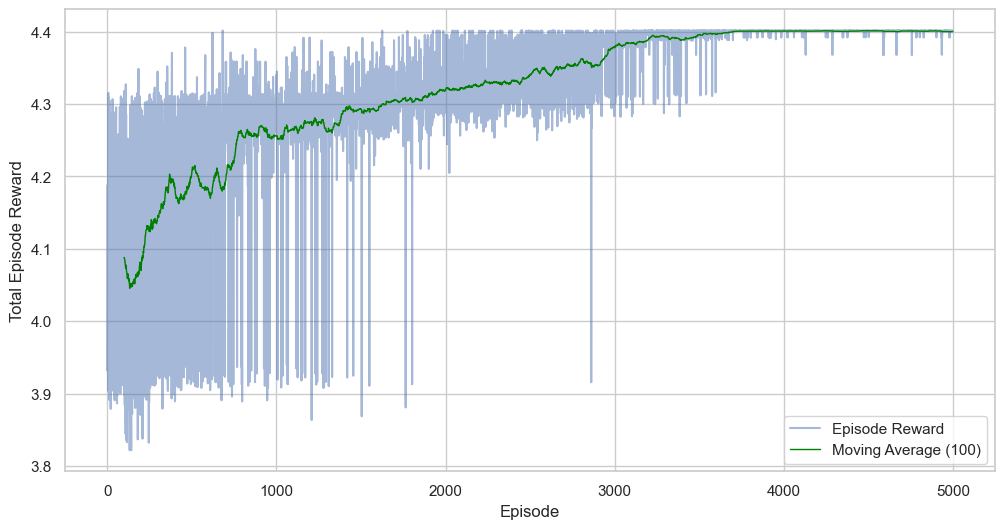

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the 100-episode moving average
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Plot the episode LoS, moving average, and max value
sns.set(style='whitegrid') 
plt.figure(figsize=(12, 6))

# Episode LoS
plt.plot(np.array(training_reward_list), label='Episode Reward', alpha=0.5)

# Moving Average (100)
moving_avg = moving_average(training_reward_list, window_size=100)
plt.plot(range(99, len(training_reward_list)), moving_avg, color='green', linewidth=1, label='Moving Average (100)')

# Add title, labels, and legend
# plt.title('Episode Rewards in Training over 10,000 Episodes', fontsize=16)
plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.legend()

# plt.savefig('hdrl_learning_10c.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

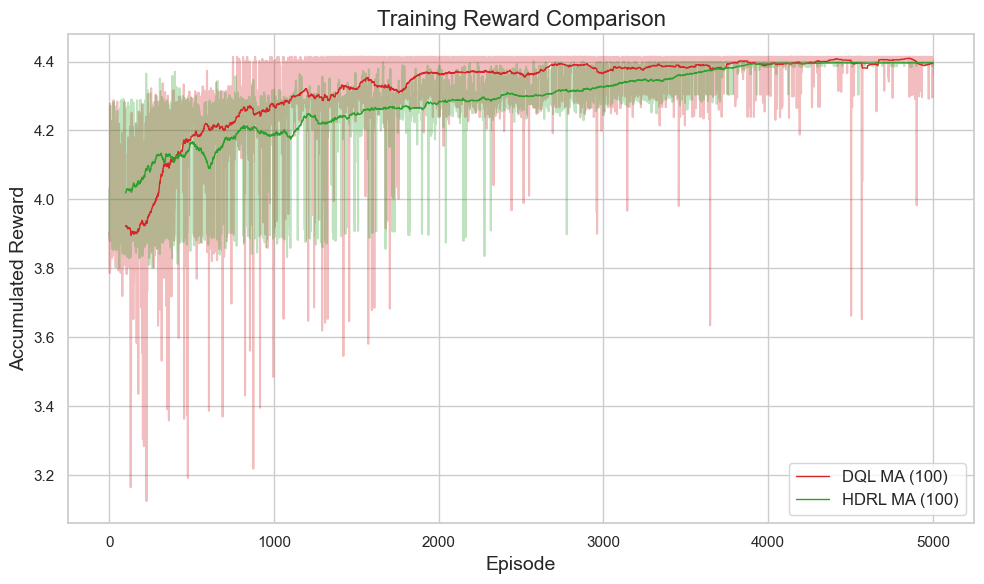

In [23]:
import numpy as np
import matplotlib.pyplot as plt

dql = np.load('training_rewards_dql2.npy')
hdrl = np.load('training_rewards_hdrl.npy')
episodes = np.arange(1, dql.size + 1)

window = 100
ma_dql = np.convolve(dql, np.ones(window) / window, mode='valid')
ma_hdrl = np.convolve(hdrl, np.ones(window) / window, mode='valid')
episodes_ma = np.arange(window, dql.size + 1)

plt.figure(figsize=(10,6))
plt.plot(episodes, dql, color='tab:red', alpha=0.3)
plt.plot(episodes, hdrl, color='tab:green', alpha=0.3)
plt.plot(episodes_ma, ma_dql, color='tab:red', linewidth=1, label='DQL MA (100)')
plt.plot(episodes_ma, ma_hdrl, color='tab:green', linewidth=1, label='HDRL MA (100)')
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Accumulated Reward', fontsize=14)
plt.title('Training Reward Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('training_reward_comparison.png', dpi=300)
plt.show()

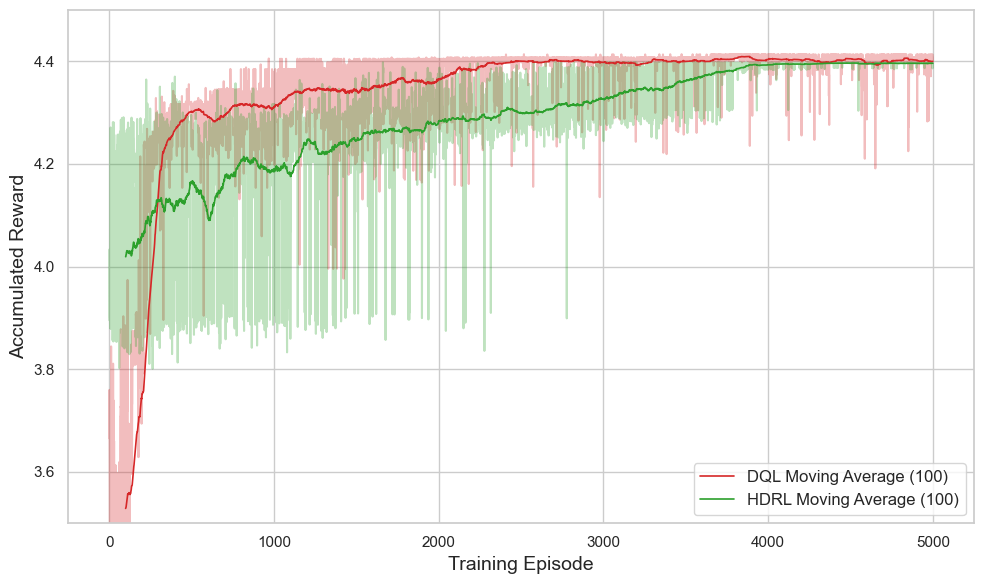

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
dql = np.load('training_rewards_dql6.npy')
hdrl = np.load('training_rewards_hdrl.npy')
episodes = np.arange(1, dql.size + 1)
window = 100
ma_dql = np.convolve(dql, np.ones(window) / window, mode='valid')
ma_hdrl = np.convolve(hdrl, np.ones(window) / window, mode='valid')
episodes_ma = np.arange(window, dql.size + 1)

plt.figure(figsize=(10, 6))
plt.plot(episodes, dql, color='tab:red', alpha=0.3)
plt.plot(episodes, hdrl, color='tab:green', alpha=0.3)
plt.plot(episodes_ma, ma_dql, color='tab:red', linewidth=1.2, label='DQL Moving Average (100)')
plt.plot(episodes_ma, ma_hdrl, color='tab:green', linewidth=1.2, label='HDRL Moving Average (100)')
plt.xlabel('Training Episode', fontsize=14)
plt.ylabel('Accumulated Reward', fontsize=14)
# plt.title('Training Reward Comparison', fontsize=16)
plt.ylim(3.5,4.5)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('training_reward_comparison.png', dpi=300)
plt.show()

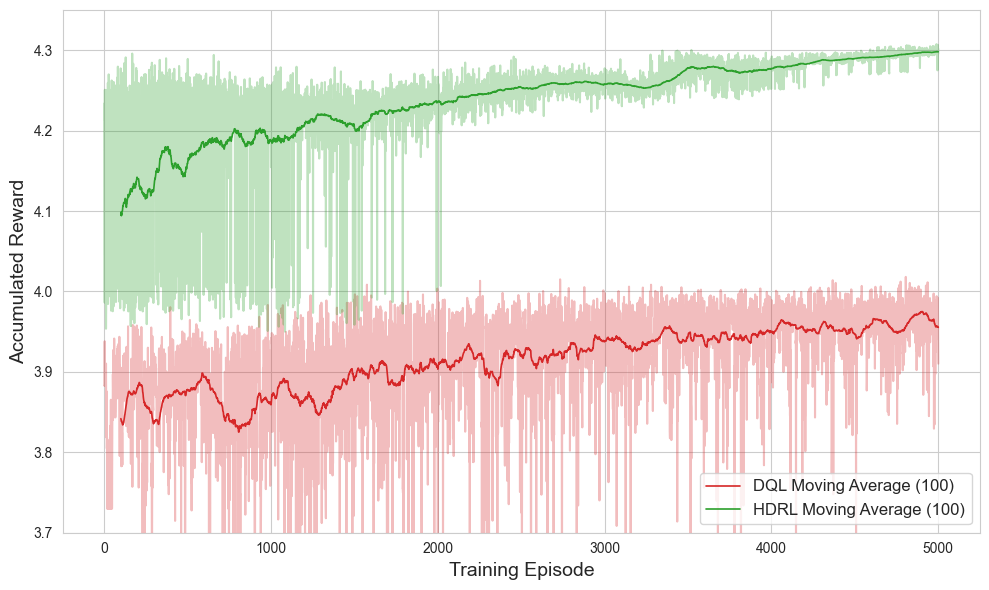

In [130]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
dql = np.load('training_rewards_dql_20c.npy')
hdrl = np.load('training_rewards_hdrl_20c.npy')
episodes = np.arange(1, dql.size + 1)
window = 100
ma_dql = np.convolve(dql, np.ones(window) / window, mode='valid')
ma_hdrl = np.convolve(hdrl, np.ones(window) / window, mode='valid')
episodes_ma = np.arange(window, dql.size + 1)

plt.figure(figsize=(10, 6))
plt.plot(episodes, dql, color='tab:red', alpha=0.3)
plt.plot(episodes, hdrl, color='tab:green', alpha=0.3)
plt.plot(episodes_ma, ma_dql, color='tab:red', linewidth=1.2, label='DQL Moving Average (100)')
plt.plot(episodes_ma, ma_hdrl, color='tab:green', linewidth=1.2, label='HDRL Moving Average (100)')
plt.xlabel('Training Episode', fontsize=14)
plt.ylabel('Accumulated Reward', fontsize=14)
# plt.title('Training Reward Comparison', fontsize=16)
plt.ylim(3.7,4.35)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('training_reward_comparison_20c.png', dpi=300)
plt.show()

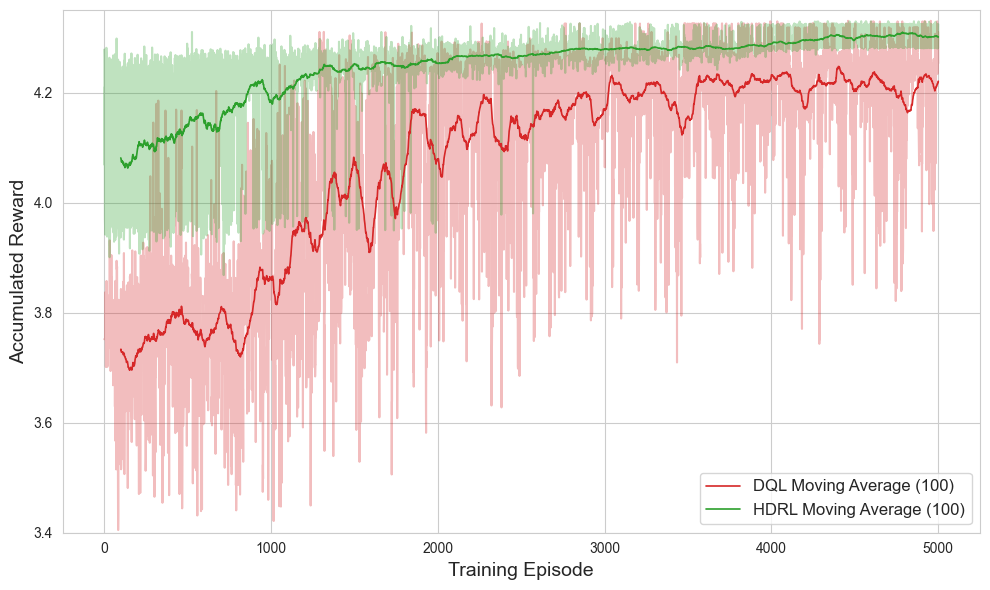

In [136]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
dql = np.load('training_rewards_dql_15c.npy')
hdrl = np.load('training_rewards_hdrl_15c.npy')
episodes = np.arange(1, dql.size + 1)
window = 100
ma_dql = np.convolve(dql, np.ones(window) / window, mode='valid')
ma_hdrl = np.convolve(hdrl, np.ones(window) / window, mode='valid')
episodes_ma = np.arange(window, dql.size + 1)

plt.figure(figsize=(10, 6))
plt.plot(episodes, dql, color='tab:red', alpha=0.3)
plt.plot(episodes, hdrl, color='tab:green', alpha=0.3)
plt.plot(episodes_ma, ma_dql, color='tab:red', linewidth=1.2, label='DQL Moving Average (100)')
plt.plot(episodes_ma, ma_hdrl, color='tab:green', linewidth=1.2, label='HDRL Moving Average (100)')
plt.xlabel('Training Episode', fontsize=14)
plt.ylabel('Accumulated Reward', fontsize=14)
# plt.title('Training Reward Comparison', fontsize=16)
plt.ylim(3.4,4.35)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('training_reward_comparison_15c.png', dpi=300)
plt.show()

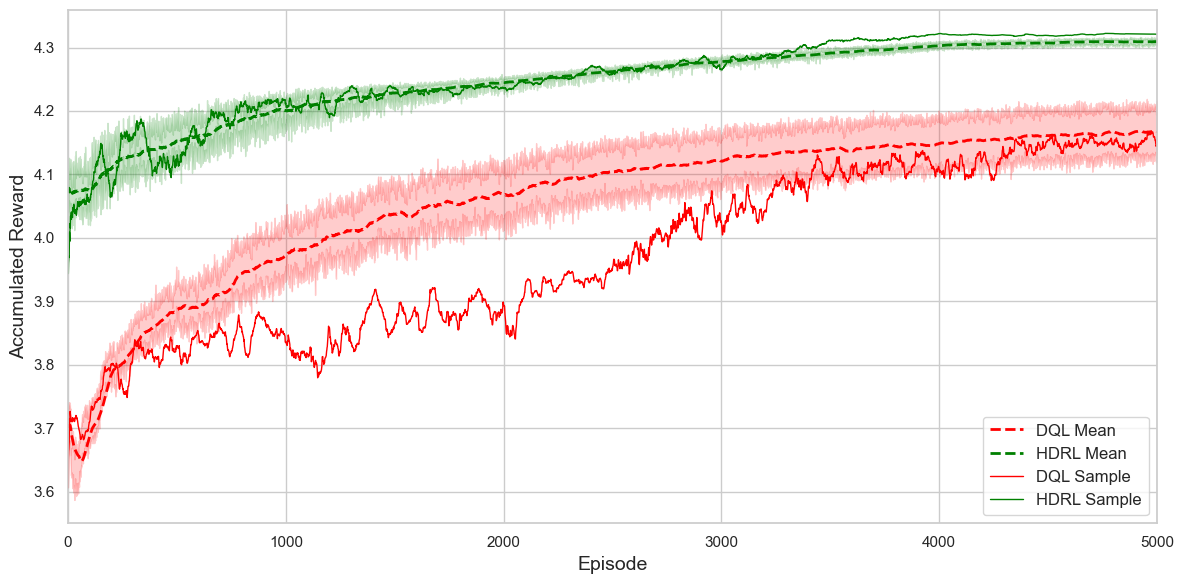

In [297]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dql = np.vstack([np.array(r, dtype=float) for r in
                 np.load('hdrl_paper/15c/training_rewards_all.npy', allow_pickle=True)])
hdrl = np.vstack([np.array(r, dtype=float) for r in
                  np.load('hdrl_results/hdrl_15c/hdrl_training_rewards_all.npy', allow_pickle=True)])

n_eps = dql.shape[1]
episodes = np.arange(1, n_eps + 1)

df = pd.DataFrame({
    **{f'dql_{i+1}': dql[i] for i in range(dql.shape[0])},
    **{f'hdrl_{i+1}': hdrl[i] for i in range(hdrl.shape[0])}
})
df['episode'] = episodes
df_long = df.melt(id_vars='episode', var_name='run', value_name='reward')
df_long['method'] = df_long['run'].str.split('_').str[0]
df_long['rolling'] = df_long.groupby('run')['reward']\
                             .transform(lambda x: x.rolling(50, min_periods=1).mean())

palette = {'dql': 'red', 'hdrl': 'green'}
sns.set_theme(style='whitegrid', context='notebook')
plt.figure(figsize=(12, 6))

# disable the built-in legend here so only our custom labels appear later
sns.lineplot(
    data=df_long, x='episode', y='reward', hue='method',
    palette=palette, estimator='mean', errorbar=('ci', 99),
    lw=0, legend=False
)

mean_roll = df_long.groupby(['episode', 'method'])['rolling']\
                   .mean().reset_index()
styles = {'dql': '--', 'hdrl': '--'}
for m, grp in mean_roll.groupby('method'):
    plt.plot(
        grp['episode'], grp['rolling'],
        color=palette[m], linestyle=styles[m], linewidth=2,
        label=f'{m.upper()} Mean'
    )

sample_roll_dql  = pd.Series(dql[57]).rolling(50, min_periods=1).mean()
sample_roll_hdrl = pd.Series(hdrl[0]).rolling(50, min_periods=1).mean()
plt.plot(
    episodes, sample_roll_dql,
    color=palette['dql'], linestyle='-', linewidth=1, alpha=1,
    label='DQL Sample'
)

plt.plot(
    episodes, sample_roll_hdrl,
    color=palette['hdrl'], linestyle='-', linewidth=1, alpha=1,
    label='HDRL Sample'
)

plt.xlabel('Episode', fontsize=14)
plt.ylabel('Accumulated Reward', fontsize=14)
plt.xlim(0, n_eps)

# now only our four custom lines appear
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('training_reward_comparison_15c.png', dpi=300)
plt.show()

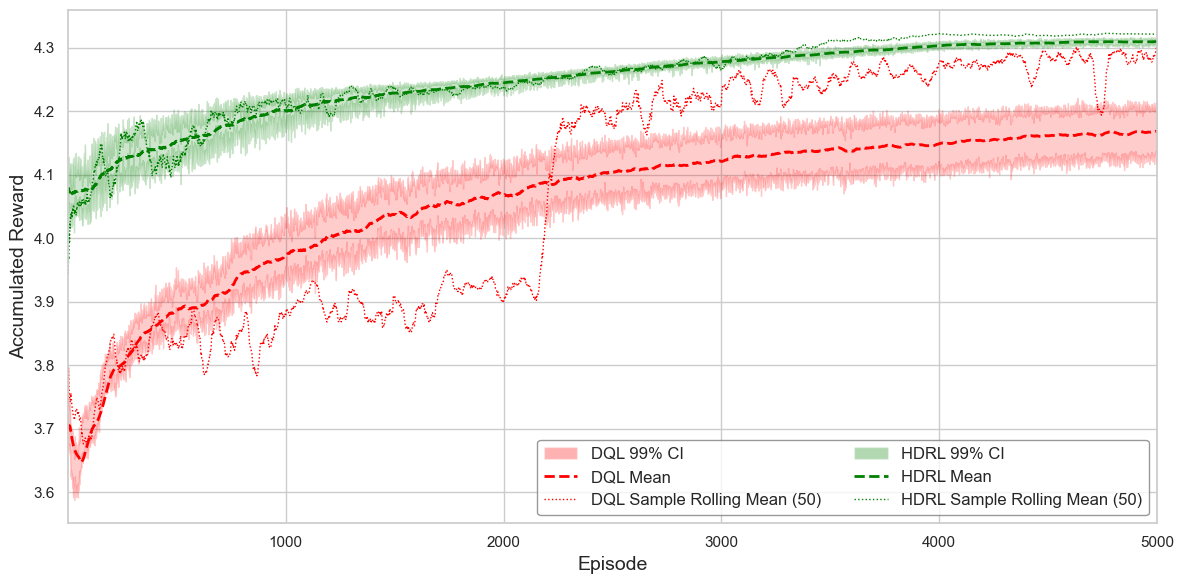

In [300]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

dql = np.vstack([np.array(r, dtype=float) for r in
                 np.load('hdrl_paper/15c/training_rewards_all.npy', allow_pickle=True)])
hdrl = np.vstack([np.array(r, dtype=float) for r in
                  np.load('hdrl_results/hdrl_15c/hdrl_training_rewards_all.npy', allow_pickle=True)])
 
n_eps = dql.shape[1]
episodes = np.arange(1, n_eps + 1)

df = pd.DataFrame({
    **{f'dql_{i+1}': dql[i] for i in range(dql.shape[0])},
    **{f'hdrl_{i+1}': hdrl[i] for i in range(hdrl.shape[0])}
})
df['episode'] = episodes
df_long = df.melt(id_vars='episode', var_name='run', value_name='reward')
df_long['method'] = df_long['run'].str.split('_').str[0]
df_long['rolling'] = df_long.groupby('run')['reward']\
                             .transform(lambda x: x.rolling(50, min_periods=1).mean())

palette = {'dql': 'red', 'hdrl': 'green'}
sns.set_theme(style='whitegrid', context='notebook')
plt.figure(figsize=(12, 6))

# plot mean ± 99% CI shading without legend
sns.lineplot(
    data=df_long, x='episode', y='reward', hue='method',
    palette=palette, estimator='mean', errorbar=('ci', 99),
    lw=0, legend=False
)

# plot rolling‐mean curves
styles = {'dql': '--', 'hdrl': '--'}
for m in ['dql', 'hdrl']:
    grp = (df_long[df_long['method']==m]
           .groupby('episode')['rolling']
           .mean()
           .reset_index())
    plt.plot(
        grp['episode'], grp['rolling'],
        color=palette[m], linestyle=styles[m], linewidth=2
    )

# plot one sample trajectory for each
sample_roll_dql  = pd.Series(dql[57]).rolling(50, min_periods=1).mean()
sample_roll_hdrl = pd.Series(hdrl[0]).rolling(50, min_periods=1).mean()
plt.plot(
    episodes, sample_roll_dql,
    color=palette['dql'], linestyle=':', linewidth=1, alpha=1
)
plt.plot(
    episodes, sample_roll_hdrl,
    color=palette['hdrl'], linestyle=':', linewidth=1, alpha=1
)

plt.xlabel('Episode', fontsize=14)
plt.ylabel('Accumulated Reward', fontsize=14)
plt.xlim(1, n_eps)

# build a complete, ordered legend with proxy artists
ci_dql   = Patch(facecolor='red',   alpha=0.3, label='DQL 99% CI')
mean_dql = Line2D([0], [0], color='red',   lw=2, linestyle='--', label='DQL Mean')
samp_dql = Line2D([0], [0], color='red',   lw=1, linestyle=':', label='DQL Sample Rolling Mean (50)')
ci_hdrl   = Patch(facecolor='green', alpha=0.3, label='HDRL 99% CI')
mean_hdrl = Line2D([0], [0], color='green', lw=2, linestyle='--', label='HDRL Mean')
samp_hdrl = Line2D([0], [0], color='green', lw=1, linestyle=':', label='HDRL Sample Rolling Mean (50)')

plt.legend(
    handles=[ci_dql, mean_dql, samp_dql, ci_hdrl, mean_hdrl, samp_hdrl],
    fontsize=12, ncol=2, frameon=True, edgecolor='gray'
)

plt.tight_layout()
plt.savefig('training_reward_comparison_15c.png', dpi=300)
plt.show()


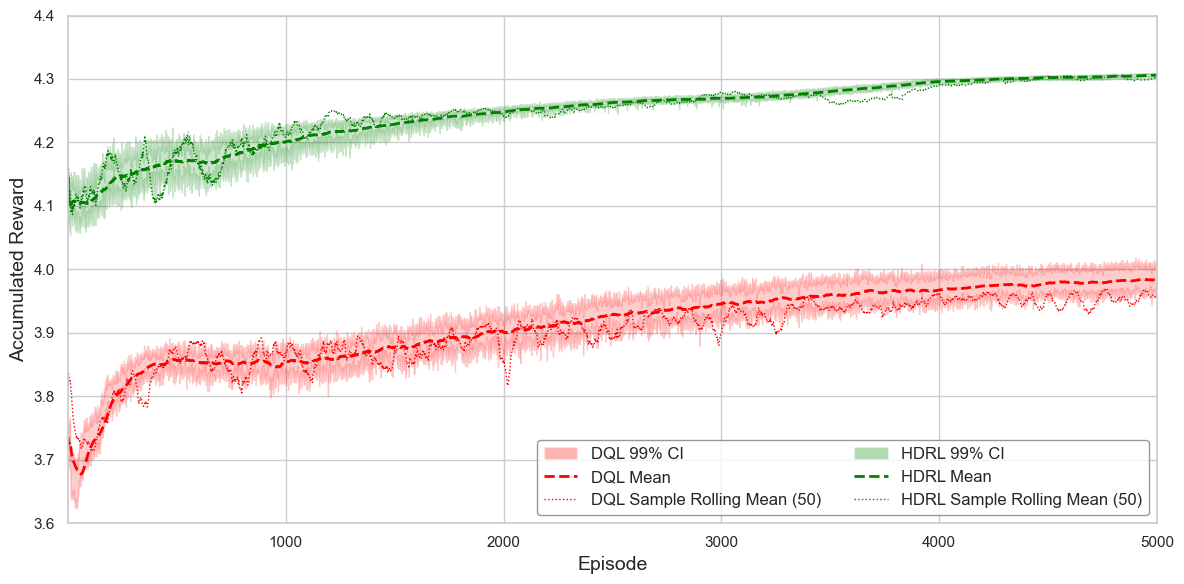

In [304]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

dql = np.vstack([np.array(r, dtype=float) for r in
                 np.load('hdrl_paper/20c/training_rewards_all.npy', allow_pickle=True)])
hdrl = np.vstack([np.array(r, dtype=float) for r in
                  np.load('hdrl_results/hdrl_20c/hdrl_training_rewards_all.npy', allow_pickle=True)])
 
n_eps = dql.shape[1]
episodes = np.arange(1, n_eps + 1)

df = pd.DataFrame({
    **{f'dql_{i+1}': dql[i] for i in range(dql.shape[0])},
    **{f'hdrl_{i+1}': hdrl[i] for i in range(hdrl.shape[0])}
})
df['episode'] = episodes
df_long = df.melt(id_vars='episode', var_name='run', value_name='reward')
df_long['method'] = df_long['run'].str.split('_').str[0]
df_long['rolling'] = df_long.groupby('run')['reward']\
                             .transform(lambda x: x.rolling(50, min_periods=1).mean())

palette = {'dql': 'red', 'hdrl': 'green'}
sns.set_theme(style='whitegrid', context='notebook')
plt.figure(figsize=(12, 6))

# plot mean ± 99% CI shading without legend
sns.lineplot(
    data=df_long, x='episode', y='reward', hue='method',
    palette=palette, estimator='mean', errorbar=('ci', 99),
    lw=0, legend=False
)

# plot rolling‐mean curves
styles = {'dql': '--', 'hdrl': '--'}
for m in ['dql', 'hdrl']:
    grp = (df_long[df_long['method']==m]
           .groupby('episode')['rolling']
           .mean()
           .reset_index())
    plt.plot(
        grp['episode'], grp['rolling'],
        color=palette[m], linestyle=styles[m], linewidth=2
    )

# plot one sample trajectory for each
sample_roll_dql  = pd.Series(dql[0]).rolling(50, min_periods=1).mean()
sample_roll_hdrl = pd.Series(hdrl[0]).rolling(50, min_periods=1).mean()
plt.plot(
    episodes, sample_roll_dql,
    color=palette['dql'], linestyle=':', linewidth=1, alpha=1
)
plt.plot(
    episodes, sample_roll_hdrl,
    color=palette['hdrl'], linestyle=':', linewidth=1, alpha=1
)

plt.xlabel('Episode', fontsize=14)
plt.ylabel('Accumulated Reward', fontsize=14)
plt.xlim(1, n_eps)

# build a complete, ordered legend with proxy artists
ci_dql   = Patch(facecolor='red',   alpha=0.3, label='DQL 99% CI')
mean_dql = Line2D([0], [0], color='red',   lw=2, linestyle='--', label='DQL Mean')
samp_dql = Line2D([0], [0], color='red',   lw=1, linestyle=':', label='DQL Sample Rolling Mean (50)')
ci_hdrl   = Patch(facecolor='green', alpha=0.3, label='HDRL 99% CI')
mean_hdrl = Line2D([0], [0], color='green', lw=2, linestyle='--', label='HDRL Mean')
samp_hdrl = Line2D([0], [0], color='green', lw=1, linestyle=':', label='HDRL Sample Rolling Mean (50)')

plt.legend(
    handles=[ci_dql, mean_dql, samp_dql, ci_hdrl, mean_hdrl, samp_hdrl],
    fontsize=12, ncol=2, frameon=True, edgecolor='gray'
)

plt.ylim(3.6,4.4)

plt.tight_layout()
plt.savefig('training_reward_comparison_20c.png', dpi=300)
plt.show()


In [294]:
for i in range(100):
    if (pd.Series(dql[i]).rolling(50, min_periods=1).mean()[4999] > 4.1) and (pd.Series(dql[i]).rolling(50, min_periods=1).mean()[4999] < 4.21):
        print(i)

57


In [293]:
pd.Series(dql[54]).rolling(50, min_periods=1).mean()[4999]

4.282265712082387

# 15c

[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Plan for each Catchment:
PS4NS : [1.0, 0.0, 0.0, 0.0, 1.0]
PS4SN_5 : [0.0, 0.0, 0.0, 0.0, 0.0]
YRJD : [0.0, 0.0, 1.0, 0.0, 0.0]
YRHS_26 : [0.0, 0.0, 0.0, 1.0, 0.0]
24 : [0.0, 0.0, 1.0, 0.0, 0.0]
23 : [0.0, 1.0, 0.0, 0.0, 0.0]
7 : [0.0, 0.0, 0.0, 1.0, 0.0]
17 : [0.0, 0.0, 1.0, 0.0, 0.0]
6 : [0.0, 0.0, 0.0, 0.0, 0.0]
20 : [0.0, 0.0, 0.0, 1.0, 0.0]
12 : [0.0, 1.0, 0.0, 0.0, 0.0]
2 : [0.0, 0.0, 0.0, 1.0, 0.0]
8 : [0.0, 1.0, 0.0, 0.0, 0.0]
22 : [0.0, 1.0, 0.0, 0.0, 0.0]
YRWB : [0.0, 1.0, 0.0, 0.0, 0.0]

Yearly Budget violations =  (0, 0)

Total Budget violations =  (0, 0)

Minimum flush violations =  (2, 0.22246541173461773)

Required budget for this plan:  [103929.9, 95798.6, 95149.6, 95121.0, 103929.9]

Total required budget:  493928.9

Network objective without penalty:  1.5320256211046475

                   1    2    3    4    5
Catchment_Group                         
PS4NS            1.0  0.0  0.0  0.0  1.0
PS4SN_5          0.0  0.0  0.0  0.0  0.0
YRJD             0.0  0.0  1.0  0.0  0.0
YRHS_26          0.0  0.0  0.0  1.0  0.0
24               0.0  0.0  1.0  0.0  0.0
23               0.0  1.0  0.0  0.0  0.0
7                0.0  0.0  0.0  1.0  0.0
17               0.0  0.0  1.0  0.0  0.0
6                0.0  0.0  0.0  0.0  0.0
20               0.0  0.0  0.0  1.0  0.0
12               0.0  1.0  0.0  0.0  0.0
2                0.0  0.0  0.0  1.0  0.0
8                0.0  1.0  0.0  0.0  0.0
22               0.0  1.0  0.0  0.0  0.0
YRWB             0.0  1.0  0.0  0.0  0.0

In [181]:
import numpy as np
import random
import gym
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
import gym.spaces
import argparse
from torch.utils.tensorboard import SummaryWriter
import time

from gym import Env
from gym.spaces import Discrete, Box, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
from torch.distributions import Normal



def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class SharedBackbone(nn.Module):
    def __init__(self, state_size, hidden_size=256):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
    def forward(self, state):
        x = F.relu(self.ln1(self.fc1(state)))
        x = F.relu(self.ln2(self.fc2(x)))
        return x

class ActorHead(nn.Module):
    def __init__(self, backbone_out, action_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super().__init__()
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.fc = nn.Linear(backbone_out, backbone_out)
        self.ln = nn.LayerNorm(backbone_out)
        self.mu = nn.Linear(backbone_out, action_size)
        self.log_std_linear = nn.Linear(backbone_out, action_size)
        self.init_w = init_w
    def reset_parameters(self):
        self.fc.weight.data.uniform_(*hidden_init(self.fc))
        self.mu.weight.data.uniform_(-self.init_w, self.init_w)
        self.log_std_linear.weight.data.uniform_(-self.init_w, self.init_w)
    def forward(self, features):
        x = F.relu(self.ln(self.fc(features)))
        mu = self.mu(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu, log_std

class CriticHead(nn.Module):
    def __init__(self, backbone_out, hidden_size=256):
        super().__init__()
        self.fc1 = nn.Linear(backbone_out, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)
    def forward(self, features):
        x = F.relu(self.ln1(self.fc1(features)))
        x = self.fc2(x)
        return x

class SharedActor(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden_size=256):
        super().__init__()
        torch.manual_seed(seed)
        self.backbone = SharedBackbone(state_size, hidden_size)
        self.head = ActorHead(hidden_size, action_size)
    def reset_parameters(self):
        self.head.reset_parameters()
    def forward(self, state):
        features = self.backbone(state)
        mu, log_std = self.head(features)
        return mu, log_std
    def evaluate(self, state, epsilon=1e-6):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(0, 1)
        e = dist.sample().to(device)
        action = torch.tanh(mu + e * std)
        log_prob = Normal(mu, std).log_prob(mu + e * std) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob
    def get_action(self, state, add_noise=True):
        mu, log_std = self.forward(state.unsqueeze(0))
        std = log_std.exp()
        dist = Normal(0, 1)
        e = dist.sample().to(device)
        action = torch.tanh(mu + e * std).cpu()
        if not add_noise:
            action = torch.tanh(mu).cpu()
        return action[0]

class SharedCritic(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden_size=256):
        super().__init__()
        torch.manual_seed(seed)
        self.backbone = SharedBackbone(state_size + action_size, hidden_size)
        self.head = CriticHead(hidden_size, hidden_size)
        self.reset_parameters()
    def reset_parameters(self):
        self.head.reset_parameters()
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        features = self.backbone(x)
        q = self.head(features)
        return q

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)
    def add(self, state, action, reward, next_state, done, plan):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        plan = np.expand_dims(plan, 0)
        e = (state, action, reward, next_state, done, plan)
        self.memory.append(e)
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states, actions, rewards, next_states, dones, plans = zip(*experiences)
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones, np.concatenate(plans)
    def __len__(self):
        return len(self.memory)

class HDRL_Agent():
    def __init__(self, state_size, action_size_primary, action_size_secondary, random_seed, action_prior="uniform"):
        self.state_size = state_size
        self.action_size_primary = action_size_primary
        self.action_size_secondary = action_size_secondary
        self.seed = random.seed(random_seed)
        self.actor1 = SharedActor(state_size, action_size_primary, random_seed).to(device)
        self.actor2 = SharedActor(state_size + action_size_primary, action_size_secondary, random_seed).to(device)
        self.critic1 = SharedCritic(state_size, action_size_primary + action_size_secondary, random_seed).to(device)
        self.critic2 = SharedCritic(state_size, action_size_primary + action_size_secondary, random_seed).to(device)
        self.critic1_target = SharedCritic(state_size, action_size_primary + action_size_secondary, random_seed).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target = SharedCritic(state_size, action_size_primary + action_size_secondary, random_seed).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        self.actor_optimizer = optim.Adam(self.actor1.parameters(), lr=LR_ACTOR)
        self.actor2_optimizer = optim.Adam(self.actor2.parameters(), lr=LR_ACTOR2)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.memory = ReplayBuffer(buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, seed=random_seed)
        self.actor_scheduler = optim.lr_scheduler.StepLR(self.actor_optimizer, step_size=100, gamma=0.99)
        self.actor2_scheduler = optim.lr_scheduler.StepLR(self.actor2_optimizer, step_size=100, gamma=0.99)
        self.critic1_scheduler = optim.lr_scheduler.StepLR(self.critic1_optimizer, step_size=100, gamma=0.99)
        self.critic2_scheduler = optim.lr_scheduler.StepLR(self.critic2_optimizer, step_size=100, gamma=0.99)
        self.log_alpha1 = torch.tensor([np.log(0.1)], requires_grad=True, device=device)
        self.log_alpha2 = torch.tensor([np.log(0.1)], requires_grad=True, device=device)
        self.alpha1 = torch.exp(self.log_alpha1).detach()
        self.alpha2 = torch.exp(self.log_alpha2).detach()
        self.alpha1_optimizer = optim.Adam([self.log_alpha1], lr=LR_ALPHA)
        self.alpha2_optimizer = optim.Adam([self.log_alpha2], lr=LR_ALPHA)
        self.target_entropy1 = -float(2)
        self.target_entropy2 = -float(10)
        self._action_prior = action_prior
        self.actor1_losses = []
        self.actor2_losses = []
        self.critic_losses = []
        self.alphas = []
        self.entropy_losses_1 = []
        self.q_losses_1 = []
        self.entropy_losses_2 = []
        self.q_losses_2 = []
    def add_sample(self, state, budget_action, reward, next_state, done, maintenance_plan):
        self.memory.add(state, budget_action, reward, next_state, done, maintenance_plan)
    def step(self):
        if len(self.memory) < BATCH_SIZE:
            return
        experiences = self.memory.sample()
        self.learn(experiences, GAMMA)
    def act(self, state, add_noise=True):
        state_tensor = torch.from_numpy(state).unsqueeze(0).float().to(device)
        budget_action = self.actor1.get_action(state_tensor, add_noise=add_noise).detach().to(device)
        obs_actor2 = torch.cat([state_tensor, budget_action], dim=1)
        maintenance_plan = self.actor2.get_action(obs_actor2, add_noise=add_noise).detach().squeeze(0)
        return budget_action.cpu().numpy(), maintenance_plan.cpu().numpy()
    def learn(self, experiences, gamma):
        states, actions_budget, rewards, next_states, dones, plans = experiences
        states = torch.FloatTensor(np.float32(states)).to(device)
        next_states = torch.FloatTensor(np.float32(next_states)).to(device)
        actions_budget = torch.cat(actions_budget).to(device)
        rewards = torch.FloatTensor(rewards).to(device).unsqueeze(1)
        dones = torch.FloatTensor(dones).to(device).unsqueeze(1)
        plans = torch.FloatTensor(plans).to(device)
        with torch.no_grad():
            next_actions_budget, log_pis_next_budget = self.actor1.evaluate(next_states)
            next_obs_actor2 = torch.cat([next_states, next_actions_budget], dim=1)
            next_actions_maintenance, log_pis_next_maintenance = self.actor2.evaluate(next_obs_actor2)
            combined_next = torch.cat([next_actions_budget, next_actions_maintenance], dim=1)
            Q_target1_next = self.critic1_target(next_states, combined_next)
            Q_target2_next = self.critic2_target(next_states, combined_next)
            Q_target_min = torch.min(Q_target1_next, Q_target2_next)
            entropy_term = (self.alpha1 * log_pis_next_budget.mean(dim=1, keepdim=True) +
                            self.alpha2 * log_pis_next_maintenance.mean(dim=1, keepdim=True))
            Q_targets = rewards + gamma * (1 - dones) * (Q_target_min - entropy_term)
        actions_combined = torch.cat([actions_budget, plans.squeeze(1)], dim=1)
        Q_1 = self.critic1(states, actions_combined)
        Q_2 = self.critic2(states, actions_combined)
        td_error1 = Q_targets.detach() - Q_1
        td_error2 = Q_targets.detach() - Q_2
        critic1_loss = 0.5 * (td_error1.pow(2)).mean()
        critic2_loss = 0.5 * (td_error2.pow(2)).mean()
        self.critic_losses.append(max(critic1_loss.item(), critic2_loss.item()))
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic1.parameters(), max_norm=1.0)
        self.critic1_optimizer.step()
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic2.parameters(), max_norm=1.0)
        self.critic2_optimizer.step()
        alpha_loss1 = - (self.log_alpha1 * (log_pis_next_budget + self.target_entropy1).detach()).mean()
        self.alpha1_optimizer.zero_grad()
        alpha_loss1.backward()
        self.alpha1_optimizer.step()
        self.alpha1 = torch.exp(self.log_alpha1).detach()
        alpha_loss2 = - (self.log_alpha2 * (log_pis_next_maintenance + self.target_entropy2).detach()).mean()
        self.alpha2_optimizer.zero_grad()
        alpha_loss2.backward()
        self.alpha2_optimizer.step()
        self.alpha2 = torch.exp(self.log_alpha2).detach()
        actions_pred_budget, log_pis_budget = self.actor1.evaluate(states)
        obs_actor2_pred = torch.cat([states, actions_pred_budget], dim=1)
        actions_pred_maintenance, _ = self.actor2.evaluate(obs_actor2_pred)
        combined_pred = torch.cat([actions_pred_budget, actions_pred_maintenance.detach()], dim=1)
        Q_critic1_actor1 = self.critic1(states, combined_pred)
        Q_critic2_actor1 = self.critic2(states, combined_pred)
        Q_actor1 = torch.min(Q_critic1_actor1, Q_critic2_actor1)
        actor1_loss = (self.alpha1 * log_pis_budget - Q_actor1).mean()
        self.q_losses_1.append(-1.0 * Q_actor1.mean().item())
        self.entropy_losses_1.append((self.alpha1 * log_pis_budget).mean().item())
        self.actor_optimizer.zero_grad()
        actor1_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor1.parameters(), max_norm=1.0)
        self.actor_optimizer.step()
        obs_actor2 = torch.cat([states, actions_budget.detach()], dim=1)
        maintenance_actions, log_pis_actor2 = self.actor2.evaluate(obs_actor2)
        combined_pred2 = torch.cat([actions_budget.detach(), maintenance_actions], dim=1)
        Q_critic1_actor2 = self.critic1(states, combined_pred2)
        Q_critic2_actor2 = self.critic2(states, combined_pred2)
        Q_actor2 = torch.min(Q_critic1_actor2, Q_critic2_actor2)
        actor2_loss = (self.alpha2 * log_pis_actor2.mean(dim=1, keepdim=True) - Q_actor2).mean()
        self.q_losses_2.append(-1.0 * Q_actor2.mean().item())
        self.entropy_losses_2.append((self.alpha2 * log_pis_actor2.mean(dim=1, keepdim=True)).mean().item())
        self.actor2_optimizer.zero_grad()
        actor2_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor2.parameters(), max_norm=1.0)
        self.actor2_optimizer.step()
        self.actor1_losses.append(actor1_loss.item())
        self.actor2_losses.append(actor2_loss.item())
        self.alphas.append((self.alpha1.item(), self.alpha2.item()))
#         self.actor_scheduler.step()
#         self.actor2_scheduler.step()
#         self.critic1_scheduler.step()
#         self.critic2_scheduler.step()
        self.soft_update(self.critic1, self.critic1_target, TAU)
        self.soft_update(self.critic2, self.critic2_target, TAU)
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    def evaluate(self, state):
        state_tensor = torch.from_numpy(state).unsqueeze(0).float().to(device)
        with torch.no_grad():
            budget_action = self.actor1.get_action(state_tensor, add_noise=False).detach().to(device)
        obs_actor2 = torch.cat([state_tensor, budget_action], dim=1)
        with torch.no_grad():
            maintenance_plan = self.actor2.get_action(obs_actor2, add_noise=False).detach().squeeze(0)
        return budget_action.cpu().numpy(), maintenance_plan.cpu().numpy()

num_years = 5
budgetb = 100000
Tol= 0.05
Total_budget = num_years*budgetb
BPF = 1
S = np.array([1,2,3,4,5])
trans = np.zeros(shape=[num_catchments,2,5,5])
trans[:, 1, :, 0] = 1.0
for i in range (num_catchments):
    trans[i,0] = dfCL.Tran[i]

class SewerBudgetEnv(Env):
    def __init__(self):
        self.time = 0
        self.components = num_catchments
        self.action_space = Box(low= -1.0, high=1.0, shape=(1,))
        self.observation_space = Box(low= 0.0, high=1.0, shape=(3+num_catchments,))
        self.state = self.reset()

    def reset(self):
        self.time = 0.0
        self.cond = np.stack(dfCL.Init.values)
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.RB = 1.0
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB
        self.oneflush = [0]*num_catchments
        self.s_cond_init = (s_cond-1)/4
        return self.state

    def step(self, budget_action, maintenance_action, render=False):
        self.pre_state = self.state[num_catchments]
        self.time += 1
        done = False
        if self.time >= num_years:
            done = True
        budget = budgetb*(1+budget_action[0]*Tol)
        budget = max(budget, budgetb*(1-Tol) + 100)
        annual_plan, _ , pcost = Annualplan(budget= budget, trans = trans, cond = self.cond, Priority_factors = maintenance_action+1)
        avg_cond_deter = np.zeros(num_catchments)
        for component in range(self.components):
            next_cond_deter = np.matmul(self.cond[component],trans[component, 0])
            avg_cond_deter[component] = np.matmul(next_cond_deter, S)
            self.cond[component] = np.matmul(self.cond[component],trans[component, int(annual_plan[component])])

        self.RB -= budget/Total_budget
        avg_cond = np.matmul(self.cond, S) + np.random.normal(0.01, 0.001, num_catchments)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        s_cond_deter = np.dot(avg_cond_deter,dfCL.Len)/dfCL.Len.sum()
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB
        reward = (1 - self.state[num_catchments])
        if self.RB < -0.005:
            reward += ((self.RB*BPF)-0.0)
        if pcost < budgetb * (1-Tol):
            reward -= 0.0
        if sum(annual_plan) == 0 :
            reward -= 0.0
        info = {}
        return self.state, reward, done, annual_plan

    def render(self):
        pass

sollist=deque(maxlen=num_years)
cond = np.stack(dfCL.Init.values)
budget = 100000
improvement = np.zeros((num_catchments,))
maintenance_action = np.zeros((num_catchments,))

def Annualplan(budget = 100000, trans = trans, cond = cond, Priority_factors = maintenance_action):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    x = {}
    for C in range(len(catchments)):
        x[C] = solver.BoolVar(f'x[{C}]')
    yearlyB_terms = [x[C]* dfCL.Len[C] * Ucost for C in range(len(catchments))]
    solver.Add(solver.Sum(yearlyB_terms) <= budget)
    solver.Add(solver.Sum(yearlyB_terms) >= budgetb * (1-Tol))
    for component in range(num_catchments):
        next_cond_flush = np.matmul(cond[component],trans[component, 1])
        next_cond_deter = np.matmul(cond[component],trans[component, 0])
        improvement[component] = (np.matmul(next_cond_deter, S)-1)/4 - (np.matmul(next_cond_flush, S)-1)/4
    objective_terms = []
    for C in range(len(catchments)):
        objective_terms.append(Priority_factors[C]*improvement[C]*x[C]*dfCL.Len[C])
    solver.Maximize(solver.Sum(objective_terms))
    status = solver.Solve()
    sol = []
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        for C in range(len(catchments)):
            sol.append(x[C].solution_value())
    objective_terms = []
    for C in range(len(catchments)):
        objective_terms.append(np.dot(S,np.matmul(cond[C],trans[C, 1]*x[C].solution_value()+ trans[C, 0]*(1-x[C].solution_value())))*dfCL.Len[C])
    objective = sum(objective_terms)/dfCL.Len.sum()
    cost =  sum([x[C].solution_value()* dfCL.Len[C] * Ucost for C in range(len(catchments))])
    if sol == []:
        sol = [0]*num_catchments
    sollist.append(sol)
    return sol, objective, cost

def HDRL_train(n_interactions, print_every=10):
    scores_deque = deque(maxlen=100)
    state = env.reset()
    score = 0
    episodes = 0
    max_ep_len = num_years
    t = 0
    while t < n_interactions:
        for i in range(max_ep_len):
            t +=1
            action, maintenance_action = agent.act(state)
            action_v = action[0]
            action_v = np.clip(action_v*action_high, action_low, action_high)
            ulb = 1e-1 + ((state[num_catchments+2]-((1-Tol)*(((1-state[num_catchments+1])*num_years)-1)/num_years)) * num_years -1)/(Tol)
            action_v[0] = np.clip(action_v[0], np.array([action_low]*1), np.array([ulb]*1))
            budget_action = torch.FloatTensor([action_v])
            next_state, reward, done, plan = env.step(budget_action = action_v, maintenance_action = maintenance_action)
            agent.add_sample(state, budget_action, reward, next_state, done, maintenance_action)
            state = next_state
            score += reward
            if done or i == max_ep_len:
                episodes += 1
                agent.step()
                training_reward_list.append(score)
                scores_deque.append(score)
                average_100.append(np.mean(scores_deque).item())
                writer.add_scalar("Reward", score, episodes)
                writer.add_scalar("average_X", np.mean(scores_deque), episodes)
                print('\rEpisode {} Reward: {:.2f}  Average100 Score: {:.2f} max:{:.2f}'.format(episodes, score, np.mean(scores_deque), np.max(scores_deque)), end="")
                if episodes % print_every == 0:
                    print('\rEpisode {}  Reward: {:.2f}  Average100 Score: {:.2f}'.format(episodes, score, np.mean(scores_deque)))
                    print(sollist)
                    sol = np.array(sollist).T.flatten().tolist()
                    printPlanInfo2(sol)
                    print(env.RB)
                    print('alpha1:  ' , agent.alpha1.detach().cpu().numpy().item())
                    print('alpha2:  ' , agent.alpha2.detach().cpu().numpy().item())
                    print(maintenance_action)
                state = env.reset()
                score = 0
                break

parser = argparse.ArgumentParser()
parser.add_argument("-env", type=str, default="Pendulum-v0", help="Name of the Environment")
parser.add_argument("-frames", type=int, default=5000*num_years, help="Number of frames to train, default = 20000")
parser.add_argument("-bs", "--buffer_size", type=int, default= int(1e3), help="Size of the Replay buffer, default= 1e6")
parser.add_argument("-bsize", "--batch_size", type=int, default=256, help="Batch size for the optimization process, default = 256")
parser.add_argument("-seed", type=int, default=1, help="Seed for the env and torch network weights, default is 0")
parser.add_argument("-lr", type=float, default=1e-3, help="Learning Rate, default 5e-4")
parser.add_argument("-g", type=float, default=1.00, help="discount factor gamma, default = 0.99")
parser.add_argument("-wd", type=float, default=0, help="Weight decay, default = 0")
parser.add_argument("-ls", "--layer_size", type=int, default=256, help="Number of nodes per neural network layer, default = 256")
parser.add_argument("--print_every", type=int, default=1000, help="Prints every x episodes the average reward over x episodes")
parser.add_argument("-info", type=str, default="SewerBudget", help="tensorboard test run information")
parser.add_argument("-device", type=str, default="cuda:0", help="Change to CPU computing or GPU, default=cuda:0")
parser.add_argument("--saved_model", type=str, default=None, help="Load a saved model to perform a test run!")
parser.add_argument("-t", "--tau", type=float, default=5e-2, help="Softupdate factor tau, default is 1e-2")
args = parser.parse_args(args=[])

sollist=deque(maxlen=num_years)
training_reward_list = []
average_100 = []

if __name__ == "__main__":
    seed = args.seed
    BUFFER_SIZE = args.buffer_size
    BATCH_SIZE = args.batch_size
    n_interactions = args.frames
    GAMMA = args.g
    TAU = 1e-3
    LR_ACTOR = args.lr
    LR_ACTOR2 = args.lr*5
    LR_CRITIC = args.lr*2
    LR_ALPHA = args.lr*3
    WEIGHT_DECAY = args.wd
    HIDDEN_SIZE = args.layer_size
    saved_model = args.saved_model
    print(LR_ACTOR, LR_ACTOR2, LR_CRITIC, LR_ALPHA)
    env = SewerBudgetEnv()
    device = torch.device("cpu")
    np.random.seed(seed)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    action_high = env.action_space.high[0]
    action_low = env.action_space.low[0]
    writer = SummaryWriter("runs/"+args.info)
    agent = HDRL_Agent(state_size=state_size, action_size_primary=action_size, action_size_secondary = env.components, random_seed=seed)
    start_time = time.time()
    HDRL_train(n_interactions=args.frames, print_every=args.print_every)
    end_time = time.time()
    env.close()
    print("Training took: {} min".format((end_time-start_time)/60))

0.001 0.005 0.002 0.003
Episode 3 Reward: 3.99  Average100 Score: 4.14 max:4.25

C:\Users\Admin\AppData\Local\Temp\ipykernel_2888\4152690337.py:413: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_v[0] = np.clip(action_v[0], np.array([action_low]*1), np.array([ulb]*1))


Episode 79 Reward: 4.00  Average100 Score: 4.13 max:4.29

KeyboardInterrupt: 

In [158]:
import numpy as np
import random
import gym
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
import gym.spaces
import argparse
from torch.utils.tensorboard import SummaryWriter
import time

from gym import Env
from gym.spaces import Discrete, Box, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
from torch.distributions import Normal

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden_size=256, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.init_w = init_w
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)
        self.mu = nn.Linear(hidden_size, action_size)
        self.log_std_linear = nn.Linear(hidden_size, action_size)

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.mu.weight.data.uniform_(-self.init_w, self.init_w)
        self.log_std_linear.weight.data.uniform_(-self.init_w, self.init_w)

    def forward(self, state):
        x = F.relu(self.ln1(self.fc1(state)))
        x = F.relu(self.ln2(self.fc2(x)))
        x = F.relu(self.ln3(self.fc3(x)))
        mu = self.mu(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu, log_std

    def evaluate(self, state, epsilon=1e-6):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(0, 1)
        e = dist.sample().to(device)
        action = torch.tanh(mu + e * std)
        log_prob = Normal(mu, std).log_prob(mu + e * std) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob

    def get_action(self, state, add_noise=True):
        mu, log_std = self.forward(state.unsqueeze(0))
        std = log_std.exp()
        dist = Normal(0, 1)
        e = dist.sample().to(device)
        action = torch.tanh(mu + e * std).cpu()
        if add_noise != True:
            action = torch.tanh(mu).cpu()
        return action[0]

class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden_size=256):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.ln1(self.fc1(x)))
        x = F.relu(self.ln2(self.fc2(x)))
        x = F.relu(self.ln3(self.fc3(x)))
        x = self.fc4(x)
        return x

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done, plan):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        plan = np.expand_dims(plan, 0)
        e = (state, action, reward, next_state, done, plan)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states, actions, rewards, next_states, dones, plans = zip(*experiences)
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones, np.concatenate(plans)

    def __len__(self):
        return len(self.memory)

class HDRL_Agent():
    def __init__(self, state_size, action_size_primary, action_size_secondary, random_seed, action_prior="uniform"):
        self.state_size = state_size
        self.action_size_primary = action_size_primary
        self.action_size_secondary = action_size_secondary
        self.seed = random.seed(random_seed)
        self.actor1_losses = []
        self.actor2_losses = []
        self.critic_losses = []
        self.alphas = []
        self.entropy_losses_1 = []
        self.q_losses_1 = []
        self.entropy_losses_2 = []
        self.q_losses_2 = []
        self.target_entropy1 = -float(20)
        self.target_entropy2 = -float(20)
        self.log_alpha1 = torch.tensor([np.log(0.1)], requires_grad=True, device=device)
        self.log_alpha2 = torch.tensor([np.log(0.1)], requires_grad=True, device=device)
        self.alpha1 = torch.exp(self.log_alpha1).detach()
        self.alpha2 = torch.exp(self.log_alpha2).detach()
        self.alpha1_optimizer = optim.Adam([self.log_alpha1], lr=LR_ALPHA)
        self.alpha2_optimizer = optim.Adam([self.log_alpha2], lr=LR_ALPHA)
        self._action_prior = action_prior
        self.actor1 = Actor(state_size, action_size_primary, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor1.parameters(), lr=LR_ACTOR)
        self.actor2 = Actor(state_size + action_size_primary, action_size_secondary, random_seed).to(device)
        self.actor2_optimizer = optim.Adam(self.actor2.parameters(), lr=LR_ACTOR2)
        total_action_size = action_size_primary + action_size_secondary
        self.critic1 = Critic(state_size, total_action_size, random_seed).to(device)
        self.critic2 = Critic(state_size, total_action_size, random_seed).to(device)
        self.critic1_target = Critic(state_size, total_action_size, random_seed).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target = Critic(state_size, total_action_size, random_seed).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.memory = ReplayBuffer(buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, seed=random_seed)
        self.actor_scheduler = optim.lr_scheduler.StepLR(self.actor_optimizer, step_size=100, gamma=0.99)
        self.actor2_scheduler = optim.lr_scheduler.StepLR(self.actor2_optimizer, step_size=100, gamma=0.99)
        self.critic1_scheduler = optim.lr_scheduler.StepLR(self.critic1_optimizer, step_size=100, gamma=0.99)
        self.critic2_scheduler = optim.lr_scheduler.StepLR(self.critic2_optimizer, step_size=100, gamma=0.99)

    def add_sample(self, state, budget_action, reward, next_state, done, maintenance_plan):
        self.memory.add(state, budget_action, reward, next_state, done, maintenance_plan)

    def step(self):
        if len(self.memory) < BATCH_SIZE:
            return
        experiences = self.memory.sample()
        self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        state_tensor = torch.from_numpy(state).unsqueeze(0).float().to(device)
        budget_action = self.actor1.get_action(state_tensor).detach().to(device)
        obs_actor2 = torch.cat([state_tensor, budget_action], dim=1)
        maintenance_plan = self.actor2.get_action(obs_actor2).detach().squeeze(0)
        return budget_action.cpu().numpy(), maintenance_plan.cpu().numpy()

    def learn(self, experiences, gamma):
        states, actions_budget, rewards, next_states, dones, plans = experiences
        states = torch.FloatTensor(np.float32(states)).to(device)
        next_states = torch.FloatTensor(np.float32(next_states)).to(device)
        actions_budget = torch.cat(actions_budget).to(device)
        rewards = torch.FloatTensor(rewards).to(device).unsqueeze(1)
        dones = torch.FloatTensor(dones).to(device).unsqueeze(1)
        plans = torch.FloatTensor(plans).to(device)
        with torch.no_grad():
            next_actions_budget, log_pis_next_budget = self.actor1.evaluate(next_states)
            next_obs_actor2 = torch.cat([next_states, next_actions_budget], dim=1)
            next_actions_maintenance, log_pis_next_maintenance = self.actor2.evaluate(next_obs_actor2)
            next_actions_combined = torch.cat([next_actions_budget, next_actions_maintenance], dim=1)
            Q_target1_next = self.critic1_target(next_states, next_actions_combined)
            Q_target2_next = self.critic2_target(next_states, next_actions_combined)
            Q_target_next = torch.min(Q_target1_next, Q_target2_next)
            entropy_term = (self.alpha1 * log_pis_next_budget.mean(dim=1, keepdim=True) +
                            self.alpha2 * log_pis_next_maintenance.mean(dim=1, keepdim=True))
            Q_targets = rewards + gamma * (1 - dones) * (Q_target_next - entropy_term)
        actions_combined = torch.cat([actions_budget, plans.squeeze(1)], dim=1)
        Q_1 = self.critic1(states, actions_combined)
        Q_2 = self.critic2(states, actions_combined)
        td_error1 = Q_targets.detach() - Q_1
        td_error2 = Q_targets.detach() - Q_2
        critic1_loss = 0.5 * (td_error1.pow(2)).mean()
        critic2_loss = 0.5 * (td_error2.pow(2)).mean()
        self.critic_losses.append(max(critic1_loss.item(), critic2_loss.item()))
        prios = abs(((td_error1 + td_error2)/2.0 + 1e-5).squeeze())
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic1.parameters(), max_norm=1.0)
        self.critic1_optimizer.step()
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic2.parameters(), max_norm=1.0)
        self.critic2_optimizer.step()
        alpha_loss1 = - (self.log_alpha1 * (log_pis_next_budget + self.target_entropy1).detach()).mean()
        self.alpha1_optimizer.zero_grad()
        alpha_loss1.backward()
        self.alpha1_optimizer.step()
        self.alpha1 = torch.exp(self.log_alpha1).detach()
        alpha_loss2 = - (self.log_alpha2 * (log_pis_next_maintenance + self.target_entropy2).detach()).mean()
        self.alpha2_optimizer.zero_grad()
        alpha_loss2.backward()
        self.alpha2_optimizer.step()
        self.alpha2 = torch.exp(self.log_alpha2).detach()
        actions_pred_budget, log_pis_budget = self.actor1.evaluate(states)
        obs_actor2_pred = torch.cat([states, actions_pred_budget], dim=1)
        actions_pred_maintenance, _ = self.actor2.evaluate(obs_actor2_pred)
        combined_pred_actor1 = torch.cat([actions_pred_budget, actions_pred_maintenance.detach()], dim=1)
        Q_critic1_actor1 = self.critic1(states, combined_pred_actor1)
        Q_critic2_actor1 = self.critic2(states, combined_pred_actor1)
        Q_actor1 = torch.min(Q_critic1_actor1, Q_critic2_actor1)
        actor1_loss = (self.alpha1 * log_pis_budget - Q_actor1).mean()
        self.q_losses_1.append(-1.0 * Q_actor1.mean().item())
        self.entropy_losses_1.append((self.alpha1 * log_pis_budget).mean().item())
        self.actor_optimizer.zero_grad()
        actor1_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor1.parameters(), max_norm=1.0)
        self.actor_optimizer.step()
        obs_actor2 = torch.cat([states, actions_budget.detach()], dim=1)
        maintenance_actions, log_pis_actor2 = self.actor2.evaluate(obs_actor2)
        combined_pred_actor2 = torch.cat([actions_budget.detach(), maintenance_actions], dim=1)
        Q_critic1_actor2 = self.critic1(states, combined_pred_actor2)
        Q_critic2_actor2 = self.critic2(states, combined_pred_actor2)
        Q_actor2 = torch.min(Q_critic1_actor2, Q_critic2_actor2)
        actor2_loss = (self.alpha2 * log_pis_actor2.mean(dim=1, keepdim=True) - Q_actor2).mean()
        self.q_losses_2.append(-1.0 * Q_actor2.mean().item())
        self.entropy_losses_2.append((self.alpha2 * log_pis_actor2.mean(dim=1, keepdim=True)).mean().item())
        self.actor2_optimizer.zero_grad()
        actor2_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor2.parameters(), max_norm=1.0)
        self.actor2_optimizer.step()
        self.actor1_losses.append(actor1_loss.item())
        self.actor2_losses.append(actor2_loss.item())
        self.alphas.append((self.alpha1.item(), self.alpha2.item()))
        self.actor_scheduler.step()
        self.actor2_scheduler.step()
        self.critic1_scheduler.step()
        self.critic2_scheduler.step()
        self.soft_update(self.critic1, self.critic1_target, TAU)
        self.soft_update(self.critic2, self.critic2_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

    def evaluate(self, state):
        state_tensor = torch.from_numpy(state).unsqueeze(0).float().to(device)
        with torch.no_grad():
            budget_action = self.actor1.get_action(state_tensor, add_noise=False).detach().to(device)
        obs_actor2 = torch.cat([state_tensor, budget_action], dim=1)
        with torch.no_grad():
            maintenance_plan = self.actor2.get_action(obs_actor2, add_noise=False).detach().squeeze(0)
        return budget_action.cpu().numpy(), maintenance_plan.cpu().numpy()


num_years = 5
budgetb = 100000
Tol= 0.05
Total_budget = num_years*budgetb
BPF = 1
S = np.array([1,2,3,4,5])
trans = np.zeros(shape=[num_catchments,2,5,5])
trans[:, 1, :, 0] = 1.0
for i in range (num_catchments):
    trans[i,0] = dfCL.Tran[i]

class SewerBudgetEnv(Env):
    def __init__(self):
        self.time = 0
        self.components = num_catchments
        self.action_space = Box(low= -1.0, high=1.0, shape=(1,))
        self.observation_space = Box(low= 0.0, high=1.0, shape=(3+num_catchments,))
        self.state = self.reset()

    def reset(self):
        self.time = 0.0
        self.cond = np.stack(dfCL.Init.values)
        avg_cond = np.matmul(self.cond, S)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        self.RB = 1.0
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB
        self.oneflush = [0]*num_catchments
        self.s_cond_init = (s_cond-1)/4
        return self.state

    def step(self, budget_action, maintenance_action, render=False):
        self.pre_state = self.state[num_catchments]
        self.time += 1
        done = False
        if self.time >= num_years:
            done = True
        budget = budgetb*(1+budget_action[0]*Tol)
        budget = max(budget, budgetb*(1-Tol) + 100)
        annual_plan, _ , pcost = Annualplan(budget= budget, trans = trans, cond = self.cond, Priority_factors = maintenance_action+1)
        avg_cond_deter = np.zeros(num_catchments)
        for component in range(self.components):
            next_cond_deter = np.matmul(self.cond[component],trans[component, 0])
            avg_cond_deter[component] = np.matmul(next_cond_deter, S)
            self.cond[component] = np.matmul(self.cond[component],trans[component, int(annual_plan[component])])

        self.RB -= budget/Total_budget
        avg_cond = np.matmul(self.cond, S) + np.random.normal(0.01, 0.001, num_catchments)
        s_cond = np.dot(avg_cond,dfCL.Len)/dfCL.Len.sum()
        s_cond_deter = np.dot(avg_cond_deter,dfCL.Len)/dfCL.Len.sum()
        self.state = self.observation_space.sample()
        self.state[:num_catchments] = (avg_cond-1)/4
        self.state[num_catchments] = (s_cond-1)/4
        self.state[num_catchments+1] = self.time/num_years
        self.state[num_catchments+2] = self.RB
        reward = (1 - self.state[num_catchments])
        if self.RB < -0.005:
            reward += ((self.RB*BPF)-0.0)
        if pcost < budgetb * (1-Tol):
            reward -= 0.0
        if sum(annual_plan) == 0 :
            reward -= 0.0
        info = {}
        return self.state, reward, done, annual_plan

    def render(self):
        pass

sollist=deque(maxlen=num_years)
cond = np.stack(dfCL.Init.values)
budget = 100000
improvement = np.zeros((num_catchments,))
maintenance_action = np.zeros((num_catchments,))

def Annualplan(budget = 100000, trans = trans, cond = cond, Priority_factors = maintenance_action):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    x = {}
    for C in range(len(catchments)):
        x[C] = solver.BoolVar(f'x[{C}]')
    yearlyB_terms = [x[C]* dfCL.Len[C] * Ucost for C in range(len(catchments))]
    solver.Add(solver.Sum(yearlyB_terms) <= budget)
    solver.Add(solver.Sum(yearlyB_terms) >= budgetb * (1-Tol))
    for component in range(num_catchments):
        next_cond_flush = np.matmul(cond[component],trans[component, 1])
        next_cond_deter = np.matmul(cond[component],trans[component, 0])
        improvement[component] = (np.matmul(next_cond_deter, S)-1)/4 - (np.matmul(next_cond_flush, S)-1)/4
    objective_terms = []
    for C in range(len(catchments)):
        objective_terms.append(Priority_factors[C]*improvement[C]*x[C]*dfCL.Len[C])
    solver.Maximize(solver.Sum(objective_terms))
    status = solver.Solve()
    sol = []
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        for C in range(len(catchments)):
            sol.append(x[C].solution_value())
    objective_terms = []
    for C in range(len(catchments)):
        objective_terms.append(np.dot(S,np.matmul(cond[C],trans[C, 1]*x[C].solution_value()+ trans[C, 0]*(1-x[C].solution_value())))*dfCL.Len[C])
    objective = sum(objective_terms)/dfCL.Len.sum()
    cost =  sum([x[C].solution_value()* dfCL.Len[C] * Ucost for C in range(len(catchments))])
    if sol == []:
        sol = [0]*num_catchments
    sollist.append(sol)
    return sol, objective, cost

def HDRL_train(n_interactions, print_every=10):
    scores_deque = deque(maxlen=100)
    state = env.reset()
    score = 0
    episodes = 0
    max_ep_len = num_years
    t = 0
    while t < n_interactions:
        for i in range(max_ep_len):
            t +=1
            action, maintenance_action = agent.act(state)
            action_v = action[0]
            action_v = np.clip(action_v*action_high, action_low, action_high)
            ulb = 1e-1 + ((state[num_catchments+2]-((1-Tol)*(((1-state[num_catchments+1])*num_years)-1)/num_years)) * num_years -1)/(Tol)
            action_v[0] = np.clip(action_v[0], np.array([action_low]*1), np.array([ulb]*1))
            budget_action = torch.FloatTensor([action_v])
            next_state, reward, done, plan = env.step(budget_action = action_v, maintenance_action = maintenance_action)
            agent.add_sample(state, budget_action, reward, next_state, done, maintenance_action)
            state = next_state
            score += reward
            if done or i == max_ep_len:
                episodes += 1
                agent.step()
                training_reward_list.append(score)
                scores_deque.append(score)
                average_100.append(np.mean(scores_deque).item())
                writer.add_scalar("Reward", score, episodes)
                writer.add_scalar("average_X", np.mean(scores_deque), episodes)
                print('\rEpisode {} Reward: {:.2f}  Average100 Score: {:.2f} max:{:.2f}'.format(episodes, score, np.mean(scores_deque), np.max(scores_deque)), end="")
                if episodes % print_every == 0:
                    print('\rEpisode {}  Reward: {:.2f}  Average100 Score: {:.2f}'.format(episodes, score, np.mean(scores_deque)))
                    print(sollist)
                    sol = np.array(sollist).T.flatten().tolist()
                    printPlanInfo2(sol)
                    print(env.RB)
                    print('alpha1:  ' , agent.alpha1.detach().cpu().numpy().item())
                    print('alpha2:  ' , agent.alpha2.detach().cpu().numpy().item())
                    print(maintenance_action)
                state = env.reset()
                score = 0
                break

parser = argparse.ArgumentParser()
parser.add_argument("-env", type=str, default="Pendulum-v0", help="Name of the Environment")
parser.add_argument("-frames", type=int, default=5000*num_years, help="Number of frames to train, default = 20000")
parser.add_argument("-bs", "--buffer_size", type=int, default= int(1e3), help="Size of the Replay buffer, default= 1e6")
parser.add_argument("-bsize", "--batch_size", type=int, default=256, help="Batch size for the optimization process, default = 256")
parser.add_argument("-seed", type=int, default=1, help="Seed for the env and torch network weights, default is 0")
parser.add_argument("-lr", type=float, default=1e-3, help="Learning Rate, default 5e-4")
parser.add_argument("-g", type=float, default=1.00, help="discount factor gamma, default = 0.99")
parser.add_argument("-wd", type=float, default=0, help="Weight decay, default = 0")
parser.add_argument("-ls", "--layer_size", type=int, default=256, help="Number of nodes per neural network layer, default = 256")
parser.add_argument("--print_every", type=int, default=1000, help="Prints every x episodes the average reward over x episodes")
parser.add_argument("-info", type=str, default="SewerBudget", help="tensorboard test run information")
parser.add_argument("-device", type=str, default="cuda:0", help="Change to CPU computing or GPU, default=cuda:0")
parser.add_argument("--saved_model", type=str, default=None, help="Load a saved model to perform a test run!")
parser.add_argument("-t", "--tau", type=float, default=5e-2, help="Softupdate factor tau, default is 1e-2")
args = parser.parse_args(args=[])

sollist=deque(maxlen=num_years)
training_reward_list = []
average_100 = []

if __name__ == "__main__":
    seed = args.seed
    BUFFER_SIZE = args.buffer_size
    BATCH_SIZE = args.batch_size
    n_interactions = args.frames
    GAMMA = args.g
    TAU = 1e-2
    LR_ACTOR = args.lr*1
    LR_ACTOR2 = args.lr*3
    LR_CRITIC = args.lr*1
    LR_ALPHA = args.lr*5
    WEIGHT_DECAY = args.wd
    HIDDEN_SIZE = args.layer_size
    saved_model = args.saved_model
    print(LR_ACTOR, LR_ACTOR2, LR_CRITIC, LR_ALPHA)
    env = SewerBudgetEnv()
    device = torch.device("cpu")
    np.random.seed(seed)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    action_high = env.action_space.high[0]
    action_low = env.action_space.low[0]
    writer = SummaryWriter("runs/"+args.info)
    agent = HDRL_Agent(state_size=state_size, action_size_primary=action_size, action_size_secondary = env.components, random_seed=seed)
    start_time = time.time()
    HDRL_train(n_interactions=args.frames, print_every=args.print_every)
    end_time = time.time()
    env.close()
    print("Training took: {} min".format((end_time-start_time)/60))

0.001 0.003 0.001 0.005
Episode 3 Reward: 4.27  Average100 Score: 4.15 max:4.27

C:\Users\Admin\AppData\Local\Temp\ipykernel_2888\1941644388.py:409: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_v[0] = np.clip(action_v[0], np.array([action_low]*1), np.array([ulb]*1))


Episode 1000  Reward: 4.29  Average100 Score: 4.28max:4.29
deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (5, 0.2680485377462828) 1.5587751406930113 499011.7
[103929.87, 104669.43, 100245.84, 95076.57, 95089.95]
-0.0014000020265578783
alpha1:   0.0010410979217773781
alpha2:   0.0008943972990346065
[ 0.9913181   0.323878    0.9187875   0.98302925  0.7720237   0.94345796
  0.8384336   0.35473713  0.9549775   0.54837376  0.76138306 -0.04015586
  0.21907397  0.8073673   0.48802486  0.32521126  0.9849794 

In [153]:
sollist=deque(maxlen=num_years)
env = SewerBudgetEnv()
state = env.reset()
for i in range(num_years):
    
    action, maintenance_action = agent.evaluate(state)
    action_v = action[0]

    action_v = np.clip(action_v*action_high, action_low, action_high)

    ulb = 1e-1 + ((state[num_catchments+2]-((1-Tol)*(((1-state[num_catchments+1])*num_years)-1)/num_years)) * num_years -1)/(Tol)
    action_v[0] = np.clip(action_v[0], np.array([action_low]*1), np.array([ulb]*1)) 
    budget_action = torch.FloatTensor([action_v])


    next_state, reward, done, plan = env.step(budget_action = action_v, maintenance_action = maintenance_action)

    state = next_state

sol = np.array(sollist).T.flatten().tolist()
print(sol)
printPlanInfo(sol)

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Plan for each Catchment:
PS4NS : [1.0, 0.0, 0.0, 0.0, 0.0]
PS4SN_5 : [0.0, 0.0, 0.0, 0.0, 1.0]
YRJD : [0.0, 1.0, 0.0, 0.0, 0.0]
YRHS_26 : [0.0, 1.0, 0.0, 0.0, 0.0]
24 : [0.0, 0.0, 0.0, 1.0, 0.0]
23 : [0.0, 0.0, 1.0, 0.0, 0.0]
7 : [0.0, 0.0, 0.0, 1.0, 0.0]
17 : [0.0, 0.0, 0.0, 0.0, 0.0]
6 : [0.0, 1.0, 0.0, 0.0, 0.0]
20 : [0.0, 0.0, 1.0, 0.0, 0.0]
12 : [0.0, 0.0, 1.0, 0.0, 0.0]
2 : [0.0, 0.0, 0.0, 1.0, 0.0]
8 : [0.0, 0.0, 0.0, 1.0, 0.0]
22 : [0.0, 0.0, 1.0, 0.0, 0.0]
YRWB : [0.0, 0.0, 0.0, 0.0, 0

C:\Users\Admin\AppData\Local\Temp\ipykernel_2888\2667998602.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_v[0] = np.clip(action_v[0], np.array([action_low]*1), np.array([ulb]*1))


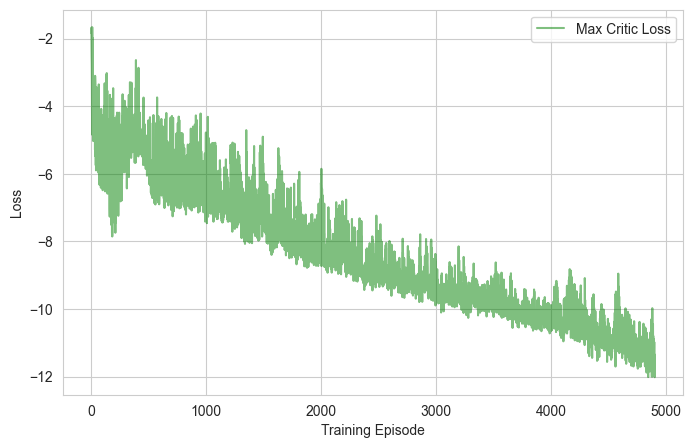

In [39]:
import matplotlib.pyplot as plt

# Plot Actor and Critic Losses
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))


plt.plot(np.log(agent.critic_losses), label='Max Critic Loss', alpha=0.5, color='green')

plt.xlabel('Training Episode')
plt.ylabel('Log Loss')
# plt.title('Critic Losses During Training')
plt.legend()

plt.show()

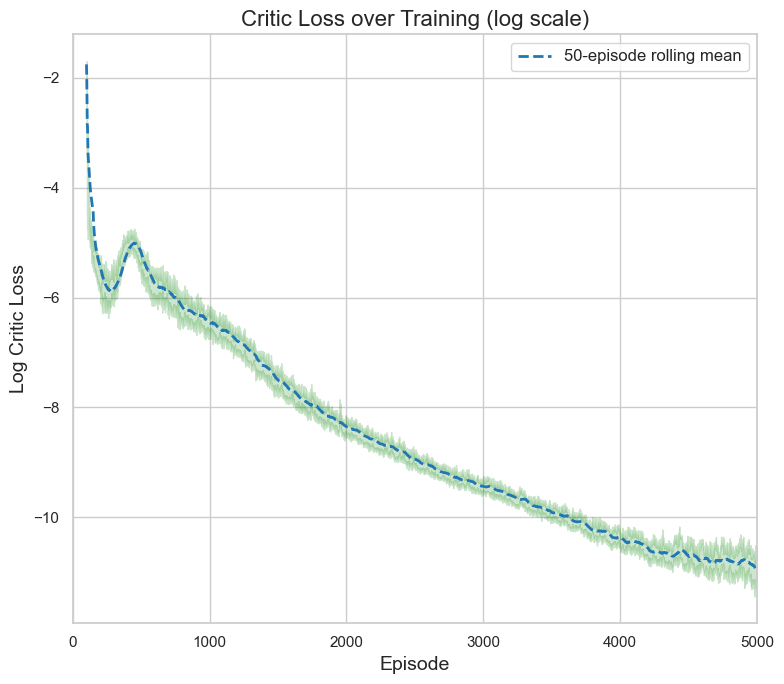

In [179]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load the multi-run critic loss data
runs = np.load(os.path.join(save_path, 'hdrl_training_critic.npy'), allow_pickle=True)
# each element of `runs` is a 1D array of loss over episodes
data = np.vstack([np.array(r, dtype=float) for r in runs])   # shape: (n_runs, n_eps)
# take the natural log
log_data = np.log(data)

n_runs, n_eps = log_data.shape
episodes = np.arange(101, n_eps + 101)

# build a long‐form DataFrame
df = pd.DataFrame(log_data.T, columns=[f'run_{i+1}' for i in range(n_runs)])
df['episode'] = episodes
df_long = df.melt(id_vars='episode', var_name='run', value_name='log_loss')

# compute 50‐episode rolling mean per run
df_long['rolling'] = df_long.groupby('run')['log_loss'] \
                           .transform(lambda x: x.rolling(50, min_periods=1).mean())

# plot mean ± 99% CI and rolling‐mean overlay
sns.set_theme(style='whitegrid', palette='colorblind', context='notebook')
plt.figure(figsize=(8, 7))

sns.lineplot(
    data=df_long,
    x='episode', y='log_loss',
    estimator='mean',
    color = 'green',
    errorbar=('ci', 99),
    lw=0

)

mean_roll = df_long.groupby('episode')['rolling'].mean().reset_index()
plt.plot(
    mean_roll['episode'], mean_roll['rolling'],
    color='tab:blue', linestyle='--', linewidth=2,
    label='50-episode rolling mean'
)

plt.xlabel('Episode', fontsize=14)
plt.ylabel('Log Critic Loss', fontsize=14)
plt.title('Critic Loss over Training (log scale)', fontsize=16)
plt.xlim(1, n_eps)
plt.legend(fontsize=12)
plt.xlim(0,5000)
plt.tight_layout()
plt.show()

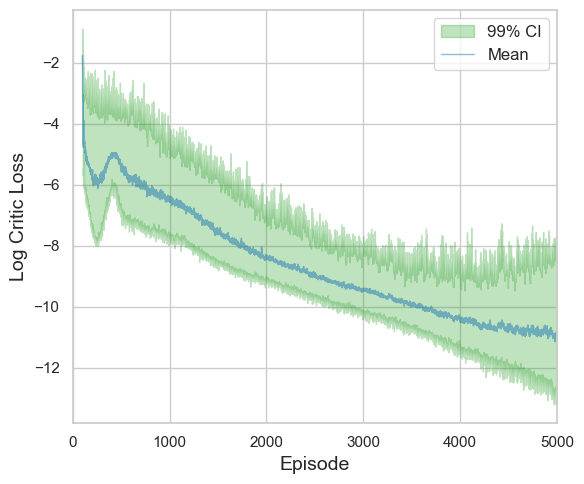

In [204]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# load multi‐run critic loss and take log
runs = np.load(os.path.join(save_path, 'hdrl_training_critic.npy'), allow_pickle=True)
data = np.vstack([r.astype(float) for r in runs])    # shape: (n_runs, n_eps)
log_data = np.log(data)

n_runs, n_eps = log_data.shape
# shift episode numbering so the first sample is at 100
episodes = np.arange(100, 100 + n_eps)

# compute per‐episode mean and 99% central CI without pandas
mean_loss = log_data.mean(axis=0)
lower_ci  = np.percentile(log_data, 0.5,  axis=0)
upper_ci  = np.percentile(log_data, 99.5, axis=0)

sns.set_style("whitegrid")
plt.figure(figsize=(6, 5))

plt.fill_between(episodes, lower_ci, upper_ci,
                 color='tab:green', alpha=0.3, label='99% CI')
plt.plot(episodes, mean_loss,
         color='tab:blue', linewidth=1, alpha=0.5, label='Mean')

plt.xlabel('Episode', fontsize=14)
plt.ylabel('Log Critic Loss', fontsize=14)
# plt.title('Critic Loss over Training (log scale)', fontsize=16)
plt.xlim(episodes[0], episodes[-1])
plt.legend(fontsize=12)
plt.xlim(0,5000)
plt.tight_layout()
plt.savefig("critic_max_loss.png", dpi=300)
plt.show()

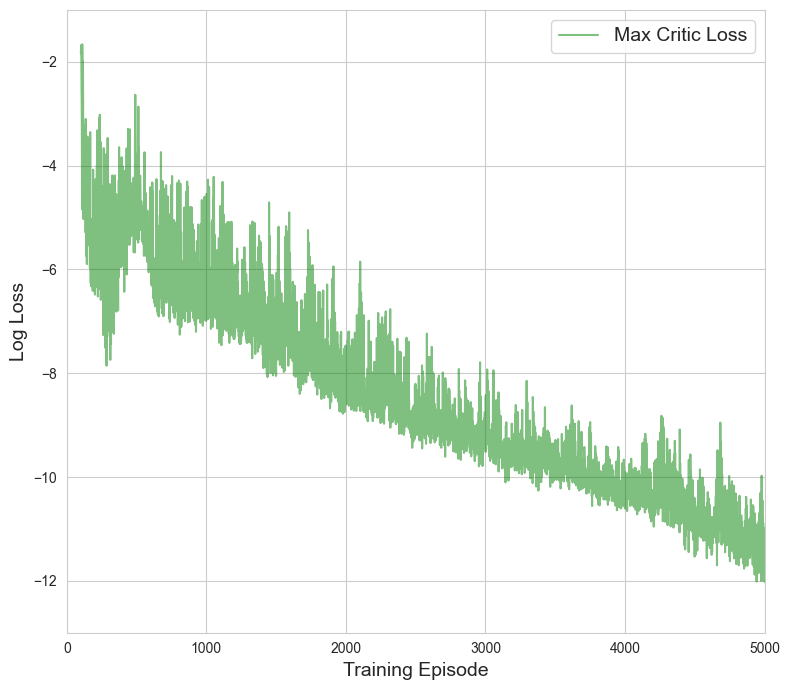

In [57]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
episodes = np.arange(100, 5001)
plt.figure(figsize=(8, 7))
plt.plot(episodes, np.log(agent.critic_losses), label="Max Critic Loss", alpha=0.5, color="green")
plt.xlabel("Training Episode", fontsize=14)
plt.ylabel("Log Loss", fontsize=14)
# plt.title("Maximum Critic Loss Over Training", fontsize=14)
plt.xlim(0,5000)
plt.ylim(-13,-1)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("critic_max_loss.png", dpi=300)
plt.show()

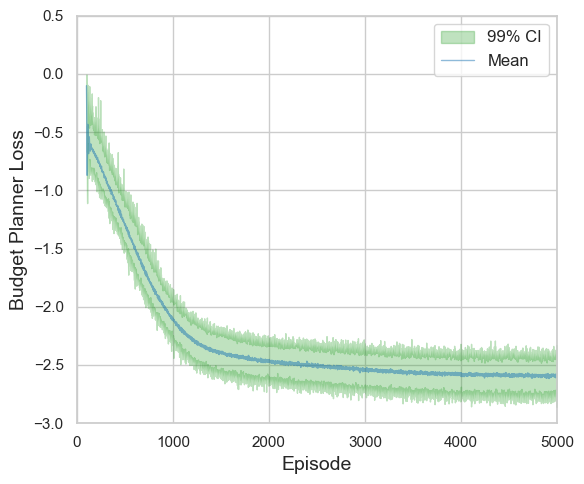

In [207]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fontsize = 12

runs = np.load(os.path.join(save_path, 'hdrl_training_actor1.npy'), allow_pickle=True)
data = np.vstack([r.astype(float) for r in runs])
log_data = data

n_runs, n_eps = log_data.shape
episodes = np.arange(100, 100 + n_eps)

mean_loss = log_data.mean(axis=0)
lower_ci  = np.percentile(log_data, 0.5,  axis=0)
upper_ci  = np.percentile(log_data, 99.5, axis=0)

sns.set_style("whitegrid")
plt.figure(figsize=(6, 5))

plt.fill_between(episodes, lower_ci, upper_ci,
                 color='tab:green', alpha=0.3, label='99% CI')
plt.plot(episodes, mean_loss,
         color='tab:blue', linewidth=1, alpha=0.5, label='Mean')


plt.xlabel('Episode', fontsize=fontsize+2)
plt.ylabel('Budget Planner Loss', fontsize=fontsize+2)
# plt.title('Actor 1 Loss over Training (log scale)', fontsize=16)
plt.xlim(episodes[0], episodes[-1])
plt.legend(fontsize=fontsize)
plt.ylim(-3, 0.5)
plt.xlim(0, 5000)
plt.tight_layout()
plt.savefig("actor_loss1.png", dpi=300)
plt.show()

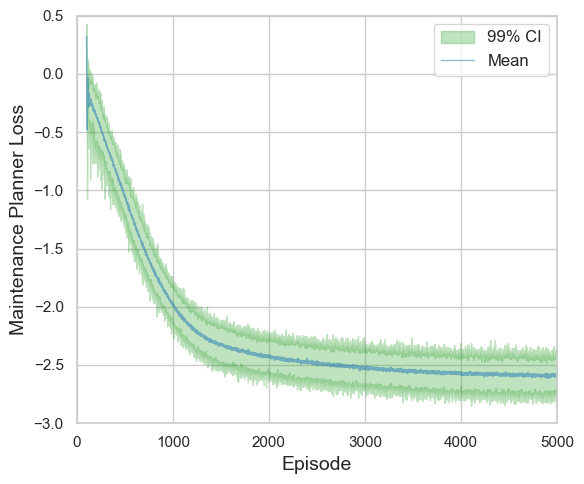

In [206]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fontsize = 12

runs = np.load(os.path.join(save_path, 'hdrl_training_actor2.npy'), allow_pickle=True)
data = np.vstack([r.astype(float) for r in runs])
log_data = data

n_runs, n_eps = log_data.shape
episodes = np.arange(100, 100 + n_eps)

mean_loss = log_data.mean(axis=0)
lower_ci  = np.percentile(log_data, 0.5,  axis=0)
upper_ci  = np.percentile(log_data, 99.5, axis=0)

sns.set_style("whitegrid")
plt.figure(figsize=(6, 5))

plt.fill_between(episodes, lower_ci, upper_ci,
                 color='tab:green', alpha=0.3, label='99% CI')
plt.plot(episodes, mean_loss,
         color='tab:blue', linewidth=1, alpha=0.5, label='Mean')


plt.xlabel('Episode', fontsize=fontsize+2)
plt.ylabel('Maintenance Planner Loss', fontsize=fontsize+2)
# plt.title('Actor 1 Loss over Training (log scale)', fontsize=16)
plt.xlim(episodes[0], episodes[-1])
plt.legend(fontsize=fontsize)
plt.xlim(0, 5000)
plt.ylim(-3, 0.5)
plt.tight_layout()
plt.savefig("actor_loss2.png", dpi=300)
plt.show()

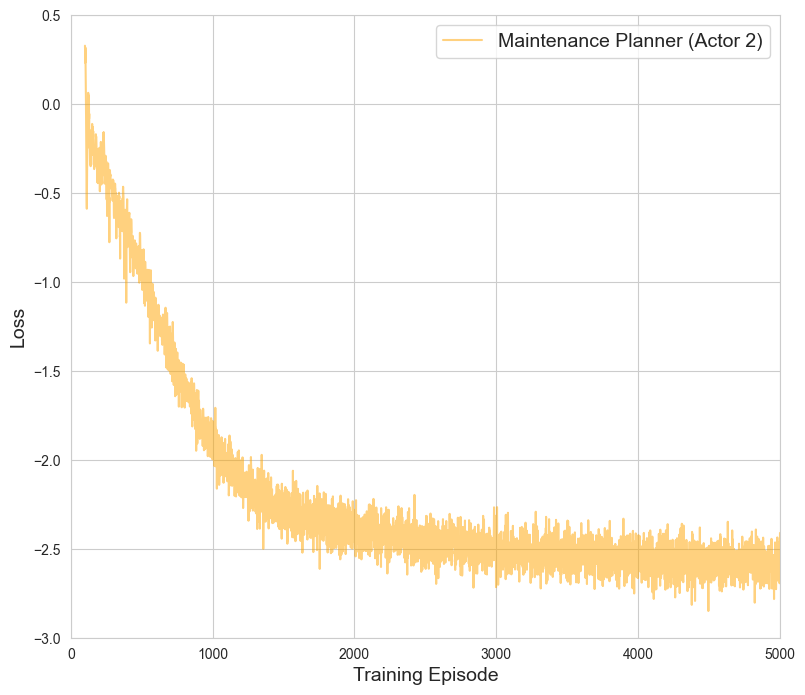

In [62]:
import matplotlib.pyplot as plt

# Plot Actor and Critic Losses
sns.set_style("whitegrid")
plt.figure(figsize=(8, 7))

# plt.plot(episodes, agent.actor1_losses, label='Budget Planner (Actor 1)', alpha=0.5, color='blue')
plt.plot(episodes, agent.actor2_losses, label='Maintenance Planner (Actor 2)', alpha=0.5, color='orange')
# plt.plot(np.log(agent.critic_losses), label='Max Critic Loss', alpha=0.5, color='green')

plt.xlabel('Training Episode', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.xlim(0,5000)
plt.ylim(-3, 0.5)
plt.savefig("actor_loss2.png", dpi=300)
plt.show()


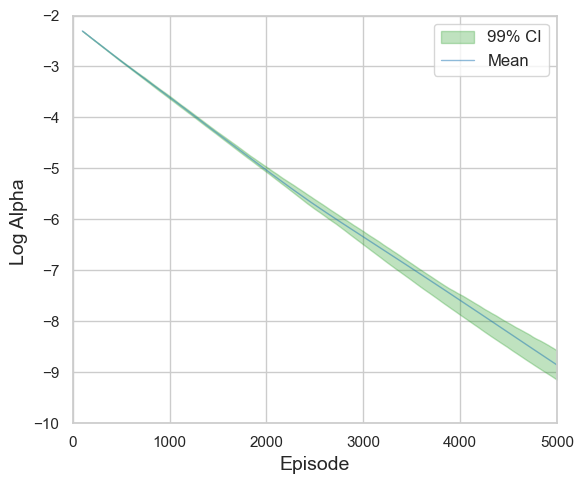

In [214]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fontsize = 12

runs = np.load(os.path.join(save_path, 'hdrl_training_alpha.npy'), allow_pickle=True)
data = np.vstack([r.astype(float) for r in runs])
log_data = np.log(data)

n_runs, n_eps = log_data.shape
episodes = np.arange(100, 100 + n_eps)

mean_loss = log_data.mean(axis=0)
lower_ci  = np.percentile(log_data, 0.5,  axis=0)
upper_ci  = np.percentile(log_data, 99.5, axis=0)

sns.set_style("whitegrid")
plt.figure(figsize=(6, 5))

plt.fill_between(episodes, lower_ci, upper_ci,
                 color='tab:green', alpha=0.3, label='99% CI')
plt.plot(episodes, mean_loss,
         color='tab:blue', linewidth=1, alpha=0.5, label='Mean')


plt.xlabel('Episode', fontsize=fontsize+2)
plt.ylabel('Log Alpha ', fontsize=fontsize+2)
# plt.title('Actor 1 Loss over Training (log scale)', fontsize=16)
plt.xlim(episodes[0], episodes[-1])
plt.legend(fontsize=fontsize)
plt.xlim(0, 5000)
plt.ylim(-10, -2)
plt.tight_layout()
plt.savefig("alpha.png", dpi=300)
plt.show()

In [210]:
lower_ci

array([0.1       , 0.09985011, 0.09970025, ..., 0.00010689, 0.00010677,
       0.00010666])

In [211]:
upper_ci

array([0.1       , 0.09985011, 0.09970626, ..., 0.00019026, 0.00019005,
       0.00018986])

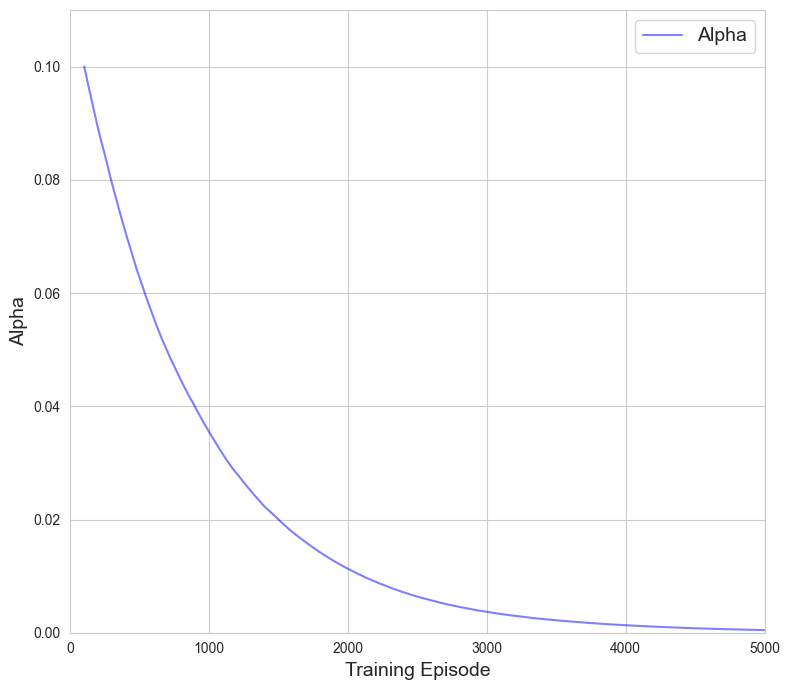

In [60]:
import matplotlib.pyplot as plt

# Plot Actor and Critic Losses
sns.set_style("whitegrid")
plt.figure(figsize=(8, 7))

plt.plot(episodes, agent.alphas, label='Alpha', alpha=0.5, color='blue')

plt.xlabel('Training Episode', fontsize=14)
plt.ylabel('Alpha', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(0,5000)
plt.ylim(0, 0.11)
plt.tight_layout()
plt.savefig("alpha.png", dpi=300)
plt.show()


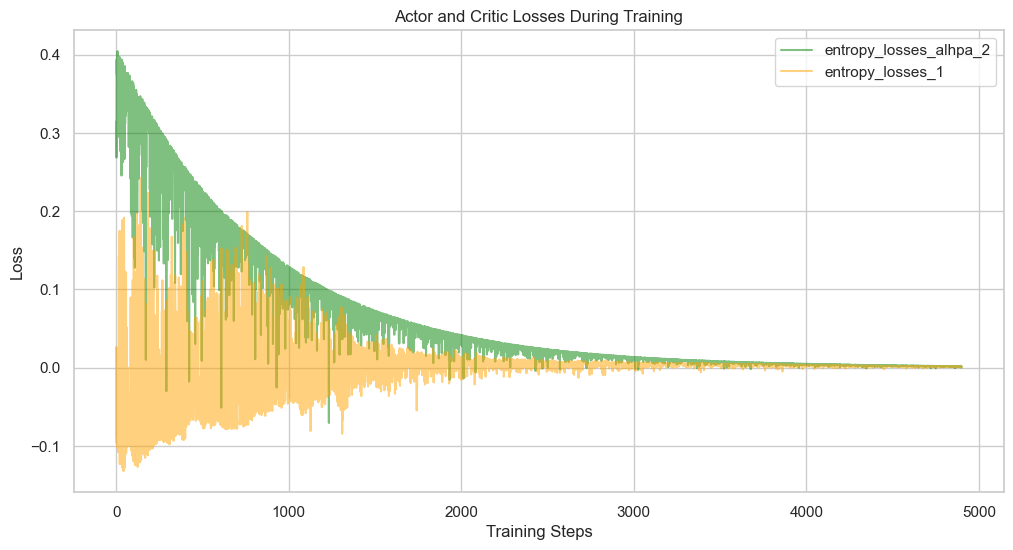

In [422]:
import matplotlib.pyplot as plt

# Plot Actor and Critic Losses
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# plt.plot(agent.q_losses_2, label='q2 Loss', alpha=0.5, color='blue')
# plt.plot(np.array(agent.entropy_losses_2)/np.array(agent.alphas), label='entropy_losses_2', alpha=0.5, color='orange')
# plt.plot(agent.actor2_losses, label='Actor2 Loss', alpha=0.5, color='orange')
plt.plot(np.array(agent.entropy_losses_2), label='entropy_losses_alhpa_2', alpha=0.5, color='green')
plt.plot(np.array(agent.entropy_losses_1), label='entropy_losses_1', alpha=0.5, color='orange')

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Actor and Critic Losses During Training')
plt.legend()

plt.show()

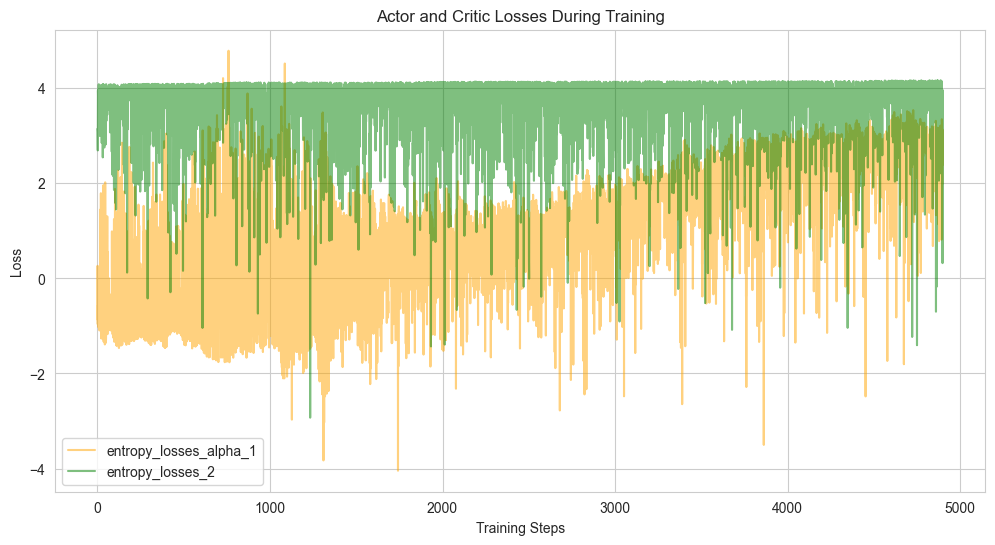

In [49]:
import matplotlib.pyplot as plt

# Plot Actor and Critic Losses
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# plt.plot(agent.q_losses_1, label='q1 Loss', alpha=0.5, color='blue')
plt.plot(np.array(agent.entropy_losses_1)/np.array(agent.alphas), label='entropy_losses_alpha_1', alpha=0.5, color='orange')
# plt.plot(agent.actor2_losses, label='Actor1 Loss', alpha=0.5, color='orange')
plt.plot(np.array(agent.entropy_losses_2)/np.array(agent.alphas), label='entropy_losses_2', alpha=0.5, color='green')

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Actor and Critic Losses During Training')
plt.legend()

plt.show()

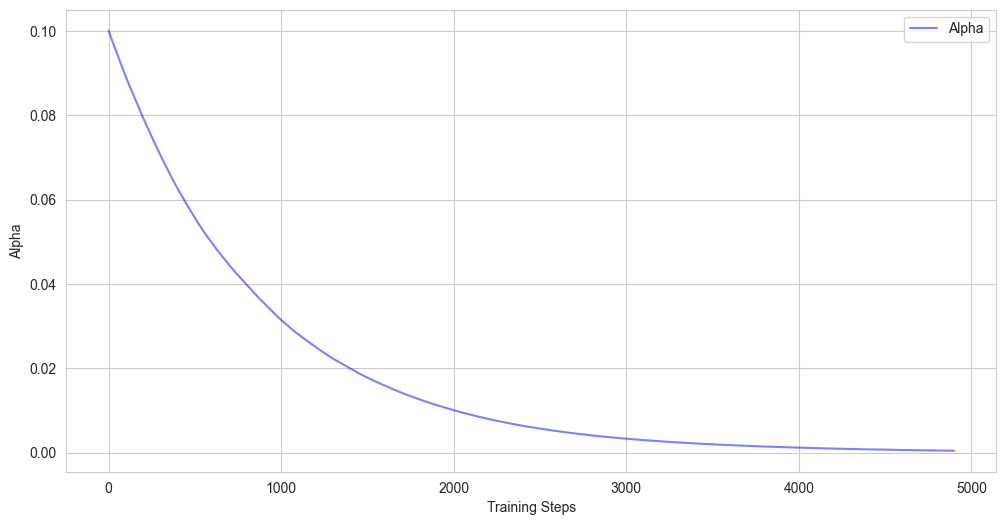

In [51]:
import matplotlib.pyplot as plt

# Plot Actor and Critic Losses
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

plt.plot(agent.alphas, label='Alpha', alpha=0.5, color='blue')
# plt.plot(agent.actor2_losses, label='Actor2 Loss', alpha=0.5, color='orange')
# plt.plot(agent.critic_losses, label='Max Critic Loss', alpha=0.5, color='green')

plt.xlabel('Training Steps')
plt.ylabel('Alpha')
# plt.title('Actor and Critic Losses During Training')
plt.legend()

plt.show()

In [99]:
((0.37989998 - 0.95 * 1 / 5) * 5 -1)/0.05

-1.0100019999999965

In [100]:
np.log(-1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_26892\153577755.py:1: RuntimeWarning: invalid value encountered in log
  np.log(-1)


nan

In [101]:
0.9**50

0.00515377520732012

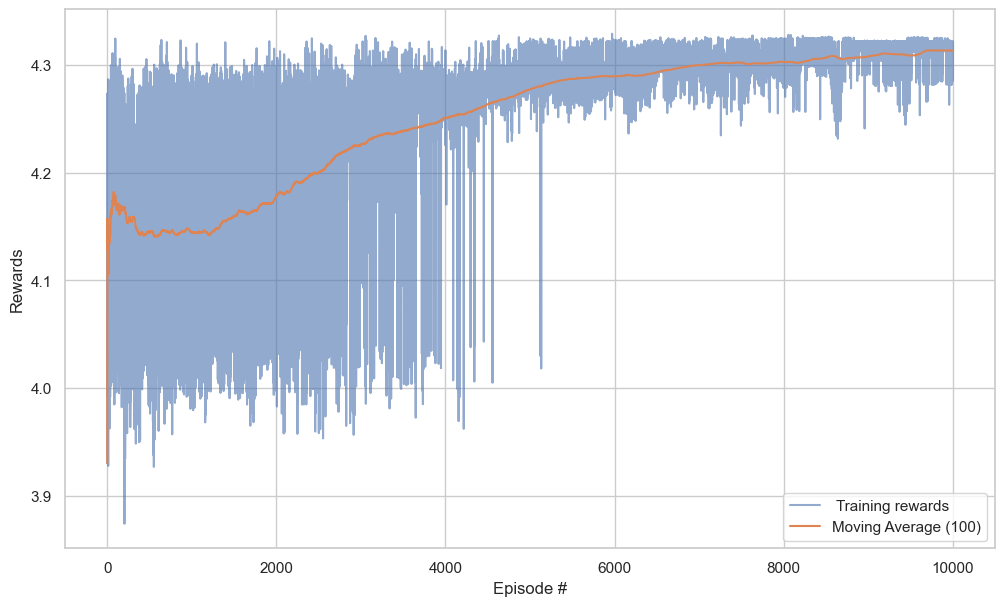

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(training_reward_list)+1), np.array(training_reward_list), alpha=0.6,  label = " Training rewards")
plt.plot(np.arange(1, len(average_100)+1), np.array(average_100), label = "Moving Average (100)")
plt.legend()
plt.ylabel('Rewards')
plt.xlabel('Episode #')
# plt.savefig('hdrl_learning_20.png', dpi=300, bbox_inches='tight')

plt.show()

In [133]:
np.max(training_reward_list)

4.330791153013706

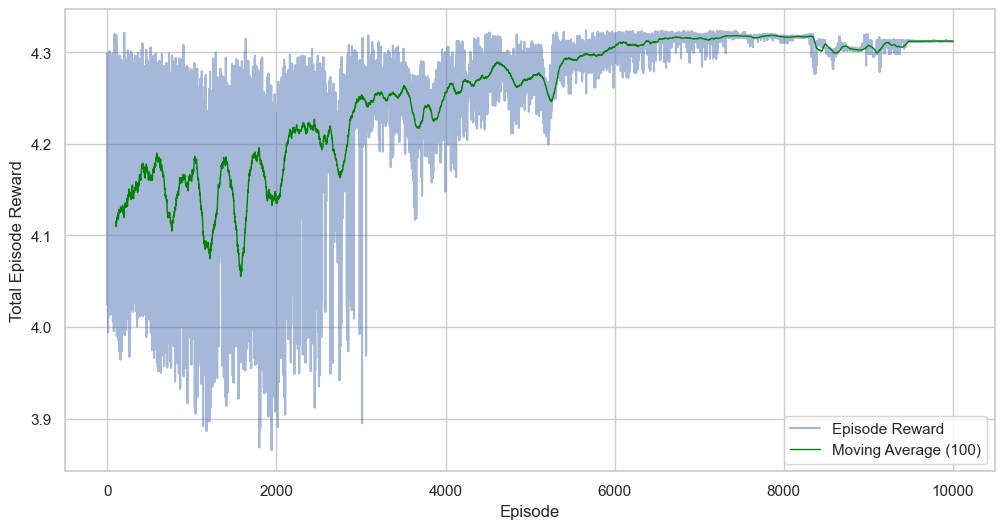

In [179]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the 100-episode moving average
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Plot the episode LoS, moving average, and max value
sns.set(style='whitegrid') 
plt.figure(figsize=(12, 6))

# Episode LoS
plt.plot(np.array(training_reward_list), label='Episode Reward', alpha=0.5)

# Moving Average (100)
moving_avg = moving_average(training_reward_list, window_size=100)
plt.plot(range(99, len(training_reward_list)), moving_avg, color='green', linewidth=1, label='Moving Average (100)')

# Add title, labels, and legend
# plt.title('Episode Rewards in Training over 10,000 Episodes', fontsize=16)
plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.legend()

# plt.savefig('hdrl_learning_10c.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

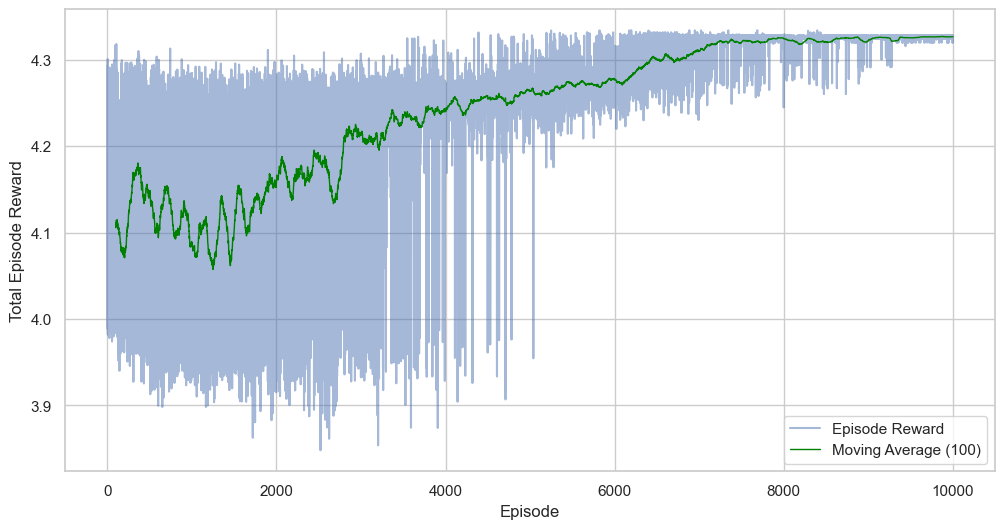

Figure and lists saved in 'hdrl_results/15component'


In [236]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define save path
save_path = 'hdrl_results/15component'

# Ensure the subfolder exists
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Calculate the 100-episode moving average
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Plot the episode rewards, moving average
sns.set(style='whitegrid') 
plt.figure(figsize=(12, 6))

# Episode Rewards
plt.plot(np.array(training_reward_list), label='Episode Reward', alpha=0.5)

# Moving Average (100)
moving_avg = moving_average(training_reward_list, window_size=100)
plt.plot(range(99, len(training_reward_list)), moving_avg, color='green', linewidth=1, label='Moving Average (100)')

# Add title, labels, and legend
plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.legend()

# Save the figure
plt.savefig(os.path.join(save_path, 'hdrl_learning_15c.png'), dpi=300, bbox_inches='tight')

# Show plot
plt.show()

# Save training rewards and additional lists as NumPy files
np.save(os.path.join(save_path, 'training_reward_list.npy'), training_reward_list)
np.save(os.path.join(save_path, 'actor1_losses.npy'), agent.actor1_losses)
np.save(os.path.join(save_path, 'actor2_losses.npy'), agent.actor2_losses)
np.save(os.path.join(save_path, 'critic_losses.npy'), agent.critic_losses)
np.save(os.path.join(save_path, 'alphas.npy'), agent.alphas)
np.save(os.path.join(save_path, 'entropy_losses_1.npy'), agent.entropy_losses_1)
np.save(os.path.join(save_path, 'q_losses_1.npy'), agent.q_losses_1)
np.save(os.path.join(save_path, 'entropy_losses_2.npy'), agent.entropy_losses_2)
np.save(os.path.join(save_path, 'q_losses_2.npy'), agent.q_losses_2)


torch.save(agent.actor1.state_dict(), os.path.join(save_path, 'primary_actor.pth'))
torch.save(agent.actor2.state_dict(), os.path.join(save_path, 'secondary_actor.pth'))
torch.save(agent.critic1.state_dict(), os.path.join(save_path, 'critic1.pth'))
torch.save(agent.critic2.state_dict(), os.path.join(save_path, 'critic2.pth'))

print(f"Figure and lists saved in '{save_path}'")

# 20 Component

deque([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], maxlen=5)
(0, 0) (0, 0) (5, 0.26870580458000665) 1.5322840341362742 496198.4
[103929.87, 95798.57999999999, 95778.93, 103929.87, 96761.13]
0.002046586632728692
alpha:   0.0018661765109675684
[-0.5641606   0.959053    0.56446874 -0.86413765  0.9925647   0.6228287
  0.96807736 -0.986189    0.7262013   0.76177806  0.3631307  -0.9776675
 -0.8577477   0.815441   -0.81160074 -0.16638872 -0.4914416  -0.6232499
  0.985902    0.6508843 ]
[-0.          0.          0.         -0.          0.99256468  0.
  0.96807736 -0.          0.7262013   0.76177806  0.         -0.
 -0.          0.         -0.         -0.         -0.         -0.
  0.          0.        ]
Training took: 204.5008572816849 min




[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Plan for each Catchment:
PS4NS : [1.0, 0.0, 0.0, 0.0, 1.0]
PS4SN_5 : [0.0, 0.0, 0.0, 0.0, 0.0]
YRJD : [0.0, 1.0, 0.0, 0.0, 0.0]
YRHS_26 : [0.0, 1.0, 0.0, 0.0, 0.0]
24 : [0.0, 0.0, 0.0, 1.0, 0.0]
23 : [0.0, 0.0, 1.0, 0.0, 0.0]
7 : [0.0, 0.0, 1.0, 0.0, 0.0]
17 : [0.0, 0.0, 0.0, 0.0, 0.0]
6 : [0.0, 0.0, 0.0, 0.0, 0.0]
20 : [0.0, 0.0, 0.0, 1.0, 0.0]
12 : [0.0, 0.0, 0.0, 1.0, 0.0]
2 : [0.0, 0.0, 0.0, 1.0, 0.0]
8 : [0.0, 0.0, 1.0, 0.0, 0.0]
22 : [0.0, 0.0, 1.0, 0.0, 0.0]
YRWB : [0.0, 1.0, 0.0, 0.0, 0.0]
13_25 : [0.0, 1.0, 0.0, 1.0, 0.0]
YRSR_YRWR : [0.0, 0.0, 0.0, 0.0, 0.0]
1 : [0.0, 0.0, 0.0, 0.0, 0.0]
21 : [0.0, 0.0, 0.0, 0.0, 0.0]
18 : [0.0, 0.0, 1.0, 0.0, 0.0]

Yearly Budget violations =  (0, 0)

Total Budget violations =  (0, 0)

Minimum flush violations =  (6, 0.2893039498369836)

Required budget for this plan:  [103929.9, 95542.2, 95647.3, 95165.3, 103929.9]

Total required budget:  494214.5

Network objective without penalty:  1.5416565580246109

                   1    2    3    4    5
Catchment_Group                         
PS4NS            1.0  0.0  0.0  0.0  1.0
PS4SN_5          0.0  0.0  0.0  0.0  0.0
YRJD             0.0  1.0  0.0  0.0  0.0
YRHS_26          0.0  1.0  0.0  0.0  0.0
24               0.0  0.0  0.0  1.0  0.0
23               0.0  0.0  1.0  0.0  0.0
7                0.0  0.0  1.0  0.0  0.0
17               0.0  0.0  0.0  0.0  0.0
6                0.0  0.0  0.0  0.0  0.0
20               0.0  0.0  0.0  1.0  0.0
12               0.0  0.0  0.0  1.0  0.0
2                0.0  0.0  0.0  1.0  0.0
8                0.0  0.0  1.0  0.0  0.0
22               0.0  0.0  1.0  0.0  0.0
YRWB             0.0  1.0  0.0  0.0  0.0
13_25            0.0  1.0  0.0  1.0  0.0
YRSR_YRWR        0.0  0.0  0.0  0.0  0.0
1                0.0  0.0  0.0  0.0  0.0
21               0.0  0.0  0.0  0.0  0.0
18               0.0  0.0  1.0  0.0  0.0

# 15 Component


[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Plan for each Catchment:
PS4NS : [1.0, 0.0, 0.0, 1.0, 0.0]
PS4SN_5 : [0.0, 0.0, 0.0, 0.0, 0.0]
YRJD : [0.0, 0.0, 1.0, 0.0, 0.0]
YRHS_26 : [0.0, 0.0, 1.0, 0.0, 0.0]
24 : [0.0, 0.0, 0.0, 0.0, 1.0]
23 : [0.0, 1.0, 0.0, 0.0, 0.0]
7 : [0.0, 0.0, 0.0, 0.0, 1.0]
17 : [0.0, 0.0, 1.0, 0.0, 0.0]
6 : [0.0, 0.0, 0.0, 0.0, 1.0]
20 : [0.0, 0.0, 0.0, 0.0, 0.0]
12 : [0.0, 1.0, 0.0, 0.0, 1.0]
2 : [0.0, 0.0, 0.0, 0.0, 0.0]
8 : [0.0, 1.0, 0.0, 0.0, 0.0]
22 : [0.0, 1.0, 0.0, 0.0, 0.0]
YRWB : [0.0, 1.0, 0.0, 0.0, 0.0]

Yearly Budget violations =  (0, 0)

Total Budget violations =  (0, 0)

Minimum flush violations =  (3, 0.2532591491680569)

Required budget for this plan:  [103929.9, 95798.6, 95883.3, 103929.9, 96092.3]

Total required budget:  495633.9

Network objective without penalty:  1.5277255290726417

                   1    2    3    4    5
Catchment_Group                         
PS4NS            1.0  0.0  0.0  1.0  0.0
PS4SN_5          0.0  0.0  0.0  0.0  0.0
YRJD             0.0  0.0  1.0  0.0  0.0
YRHS_26          0.0  0.0  1.0  0.0  0.0
24               0.0  0.0  0.0  0.0  1.0
23               0.0  1.0  0.0  0.0  0.0
7                0.0  0.0  0.0  0.0  1.0
17               0.0  0.0  1.0  0.0  0.0
6                0.0  0.0  0.0  0.0  1.0
20               0.0  0.0  0.0  0.0  0.0
12               0.0  1.0  0.0  0.0  1.0
2                0.0  0.0  0.0  0.0  0.0
8                0.0  1.0  0.0  0.0  0.0
22               0.0  1.0  0.0  0.0  0.0
YRWB             0.0  1.0  0.0  0.0  0.0


# 10 Component

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Plan for each Catchment:
PS4NS : [1.0, 0.0, 0.0, 1.0, 0.0]
PS4SN_5 : [0.0, 0.0, 0.0, 0.0, 0.0]
YRJD : [0.0, 1.0, 0.0, 0.0, 1.0]
YRHS_26 : [0.0, 0.0, 1.0, 0.0, 0.0]
24 : [0.0, 0.0, 0.0, 0.0, 1.0]
23 : [0.0, 1.0, 0.0, 0.0, 0.0]
7 : [0.0, 0.0, 1.0, 0.0, 0.0]
17 : [0.0, 1.0, 0.0, 0.0, 1.0]
6 : [0.0, 0.0, 1.0, 0.0, 0.0]
20 : [0.0, 0.0, 1.0, 0.0, 0.0]

Yearly Budget violations =  (0, 0)

Total Budget violations =  (0, 0)

Minimum flush violations =  (1, 0.21826876757276314)

Required budget for this plan:  [103929.9, 95060.3, 97494.9, 103929.9, 95149.6]

Total required budget:  495564.5

Network objective without penalty:  1.4691342959567348

                   1    2    3    4    5
Catchment_Group                         
PS4NS            1.0  0.0  0.0  1.0  0.0
PS4SN_5          0.0  0.0  0.0  0.0  0.0
YRJD             0.0  1.0  0.0  0.0  1.0
YRHS_26          0.0  0.0  1.0  0.0  0.0
24               0.0  0.0  0.0  0.0  1.0
23               0.0  1.0  0.0  0.0  0.0
7                0.0  0.0  1.0  0.0  0.0
17               0.0  1.0  0.0  0.0  1.0
6                0.0  0.0  1.0  0.0  0.0
20               0.0  0.0  1.0  0.0  0.0

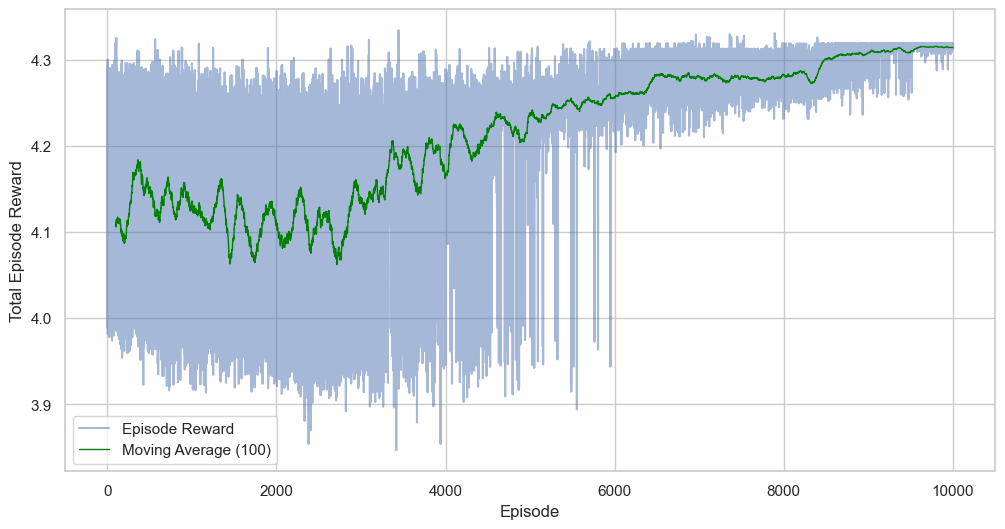

Figure and training rewards saved in 'hdrl_results/15component'


In [113]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define save path
save_path = 'hdrl_results/10component'

# Ensure the subfolder exists
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Calculate the 100-episode moving average
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Plot the episode rewards, moving average
sns.set(style='whitegrid') 
plt.figure(figsize=(12, 6))

# Episode Rewards
plt.plot(np.array(training_reward_list), label='Episode Reward', alpha=0.5)

# Moving Average (100)
moving_avg = moving_average(training_reward_list, window_size=100)
plt.plot(range(99, len(training_reward_list)), moving_avg, color='green', linewidth=1, label='Moving Average (100)')

# Add title, labels, and legend
plt.xlabel('Episode')
plt.ylabel('Total Episode Reward')
plt.legend()

# Save the figure
plt.savefig(os.path.join(save_path, 'hdrl_learning_10c.png'), dpi=300, bbox_inches='tight')

# Show plot
plt.show()

# Save training rewards as a NumPy file
np.save(os.path.join(save_path, 'training_reward_list.npy'), training_reward_list)



print(f"Figure and list saved in '{save_path}'")

In [ ]:
# # Load the NumPy file
# training_reward_list = np.load('hdrl_results/20component/training_reward_list.npy')


In [21]:
import os

# Define the subfolder path
save_path = 'hdrl_results/20component'

# Create the directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [22]:
torch.save(agent.actor1.state_dict(), os.path.join(save_path, 'primary_actor.pth'))
torch.save(agent.actor2.state_dict(), os.path.join(save_path, 'secondary_actor.pth'))
torch.save(agent.critic1.state_dict(), os.path.join(save_path, 'critic1.pth'))
torch.save(agent.critic2.state_dict(), os.path.join(save_path, 'critic2.pth'))

In [ ]:
# Load the models
agent.actor1.load_state_dict(torch.load(os.path.join(save_path, 'primary_actor.pth')))
agent.actor2.load_state_dict(torch.load(os.path.join(save_path, 'secondary_actor.pth')))
agent.critic1.load_state_dict(torch.load(os.path.join(save_path, 'critic1.pth')))
agent.critic2.load_state_dict(torch.load(os.path.join(save_path, 'critic2.pth')))

In [10]:
sollist=deque(maxlen=num_years)
cond = np.stack(dfCL.Init.values)
budget = 100000
q_list = np.zeros((num_catchments,))

S = np.array([1,2,3,4,5])

trans = np.zeros(shape=[num_catchments,2,5,5])
trans[:, 1, :, 0] = 1.0  # replace action
# no-actions for all components
for i in range (num_catchments):
    trans[i,0] = dfCL.Tran[i]

def LPplan(budget = 100000, trans = trans, cond = cond, q_list= q_list):

    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver('SCIP')
    # Variables
    # x[i, j] is an array of 0-1 variables, which will be 1
    # if plan j is addopted for catchment j.
    x = {}
    for C in range(len(catchments)):
        x[C] = solver.BoolVar(f'x[{C}]')

    # Constraints
      

    # Yearly budget constraint.

    yearlyB_terms = [x[C]* dfCL.Len[C] * Ucost for C in range(len(catchments))]
    solver.Add(solver.Sum(yearlyB_terms) <= budget)
    solver.Add(solver.Sum(yearlyB_terms) >= budgetb * (1-Tol))
    
    


        
    # Objective
    objective_terms = []
    for C in range(len(catchments)):
#         objective_terms.append((q_list1[C,1]* x[C]+ q_list1[C,0]*(1-x[C]))*dfCL.Len[C])
        objective_terms.append(q_list[C]*x[C]*dfCL.Len[C])

#         objective_terms.append(q_list[C]*x[C])
    
    solver.Maximize(solver.Sum(objective_terms))
#     solver.Minimize(solver.Sum(objective_terms))

    # Solve
    status = solver.Solve()

    # Print solution.
    sol = []
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
#         print(f'Total cost = {solver.Objective().Value()}\n')
        for C in range(len(catchments)):
            sol.append(x[C].solution_value())
    else:
#         print('No solution found.')
        pass

    objective_terms = []
    for C in range(len(catchments)):
        objective_terms.append(np.dot(S,np.matmul(cond[C],trans[C, 1]*x[C].solution_value()+ trans[C, 0]*(1-x[C].solution_value())))*dfCL.Len[C])  
        
    
    objective = sum(objective_terms)/dfCL.Len.sum()
    
    cost =  sum([x[C].solution_value()* dfCL.Len[C] * Ucost for C in range(len(catchments))])
    if sol == []:
        sol = [0]*num_catchments
    sollist.append(sol)
    return sol, objective, cost




for component in range(num_catchments):  # for each component
    next_cond_flush = np.matmul(cond[component],trans[component, 1])
    next_cond_deter = np.matmul(cond[component],trans[component, 0])
    q_list[component] = (np.matmul(next_cond_deter, S)-1)/4 - (np.matmul(next_cond_flush, S)-1)/4
    



In [11]:
LPplan(budget = 100000, trans = trans, cond = cond, q_list= q_list)

([0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0],
 1.6385822108171888,
 96814.68)

In [12]:
sollist=deque(maxlen=num_years)
cond = np.stack(dfCL.Init.values)
budget = 100000
q_list = np.zeros((num_catchments,))

for year in range(num_years):

    for component in range(num_catchments):  # for each component
        next_cond_flush = np.matmul(cond[component],trans[component, 1])
        next_cond_deter = np.matmul(cond[component],trans[component, 0])
        q_list[component] = (np.matmul(next_cond_deter, S)-1)/4 - (np.matmul(next_cond_flush, S)-1)/4

    annual_plan, _ , pcost = LPplan(budget = budget, trans = trans, cond = cond, q_list= q_list)  
    for component in range(num_catchments):  # for each component
        cond[component] = np.matmul(cond[component],trans[component, int(annual_plan[component])])
            

In [13]:
sol = np.array(sollist).T.flatten().tolist()
print(sol)
printPlanInfo(sol)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Plan for each Catchment:
PS4NS : [0.0, 0.0, 0.0, 0.0, 0.0]
PS4SN_5 : [0.0, 0.0, 0.0, 1.0, 0.0]
YRJD : [1.0, 0.0, 0.0, 0.0, 1.0]
YRHS_26 : [0.0, 1.0, 0.0, 0.0, 1.0]
24 : [0.0, 0.0, 1.0, 0.0, 0.0]
23 : [0.0, 1.0, 0.0, 0.0, 0.0]
7 : [0.0, 0.0, 0.0, 0.0, 1.0]
17 : [0.0, 0.0, 0.0, 0.0, 0.0]
6 : [0.0, 0.0, 1.0, 0.0, 0.0]
20 : [0.0, 1.0, 0.0, 0.0, 0.0]
12 : [1.0, 0.0, 1.0, 0.0, 0.0]
2 : [0.0, 0.0, 0.0, 0.0, 0.0]
8 : [1.0, 0.0, 0.0, 0.0, 0.0]
22 : [1.0, 0.0, 1.0, 0.0, 0.0]
YRWB : [0.0, 1.0, 0.0, 0.0, 0